In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import brentq # For the Riemann solver root finding

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GAMMA = 1.4  # Ratio of specific heats
print(f"Using device: {DEVICE}")

# --- 1. Euler Equations & Riemann Problem Utilities ---
def primitive_to_conserved(rho, u, p):
    rho = torch.as_tensor(rho, dtype=torch.float32, device=DEVICE)
    u = torch.as_tensor(u, dtype=torch.float32, device=DEVICE)
    p = torch.as_tensor(p, dtype=torch.float32, device=DEVICE)
    E_internal = p / ((GAMMA - 1.0) * rho.clamp(min=1e-9))
    E_total = rho * (E_internal + 0.5 * u**2)
    return torch.stack([rho, rho * u, E_total], dim=-1)

def conserved_to_primitive(Q_conserved):
    rho = Q_conserved[..., 0:1].clamp(min=1e-9)
    rhou = Q_conserved[..., 1:2]
    E_total_conserved = Q_conserved[..., 2:3]
    u = rhou / rho 
    pressure_val = (E_total_conserved - 0.5 * rhou**2 / rho) * (GAMMA - 1.0)
    p = pressure_val.clamp(min=1e-9)
    return rho, u, p

def euler_fluxes_conserved(Q_conserved):
    rho, u, p = conserved_to_primitive(Q_conserved)
    F_component_0 = Q_conserved[..., 1:2]
    F_component_1 = Q_conserved[..., 1:2] * u + p
    F_component_2 = (Q_conserved[..., 2:3] + p) * u
    return torch.cat([F_component_0, F_component_1, F_component_2], dim=-1)

# --- Initial Conditions (Sod Shock Tube) ---
DIAPHRAGM_LOCATION = 0.5
def get_sod_initial_conditions(x_coords): 
    rho_ic = torch.where(x_coords < DIAPHRAGM_LOCATION, torch.tensor(1.0), torch.tensor(0.125)).to(DEVICE)
    p_ic = torch.where(x_coords < DIAPHRAGM_LOCATION, torch.tensor(1.0), torch.tensor(0.1)).to(DEVICE)
    u_ic = torch.zeros_like(x_coords).to(DEVICE)
    return primitive_to_conserved(rho_ic, u_ic, p_ic)

# --- Exact Riemann Solver for Sod Problem (Ground Truth) ---
def exact_sod_solver(x_np, t_val):
    rho_L, u_L, p_L = 1.0, 0.0, 1.0
    rho_R, u_R, p_R = 0.125, 0.0, 0.1
    
    if abs(t_val) < 1e-9: 
        rho = np.where(x_np < DIAPHRAGM_LOCATION, rho_L, rho_R)
        u = np.where(x_np < DIAPHRAGM_LOCATION, u_L, u_R)
        p = np.where(x_np < DIAPHRAGM_LOCATION, p_L, p_R)
        return rho, u, p

    a_L = np.sqrt(GAMMA * p_L / rho_L)
    a_R = np.sqrt(GAMMA * p_R / rho_R)

    def F_k(P_star_func, P_k_func, RHO_k_func, A_k_func):
        if P_star_func > P_k_func:
            den_shock = RHO_k_func * ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star_func + (GAMMA - 1.0) / (2.0 * GAMMA) * P_k_func )
            return (P_star_func - P_k_func) / np.sqrt(max(1e-12, den_shock))
        else:
            pressure_ratio_clipped = max(1e-12, P_star_func / P_k_func)
            return (2.0 * A_k_func / (GAMMA - 1.0)) * ( pressure_ratio_clipped**((GAMMA - 1.0) / (2.0 * GAMMA)) - 1.0 )

    def pressure_function_for_root(P_star_guess_func):
        return F_k(P_star_guess_func, p_L, rho_L, a_L) + F_k(P_star_guess_func, p_R, rho_R, a_R) - (u_L - u_R)

    p_min_search = 1e-7 
    p_max_search = max(p_L, p_R) * 50.0 
    P_star = 0.30313 
    try:
        P_star = brentq(pressure_function_for_root, p_min_search, p_max_search, xtol=1e-12, rtol=1e-12)
    except (ValueError, RuntimeError) as e:
        print(f"Warning: Root finding for P_star failed or did not converge. Error: {e}. Using approximate P_star={P_star} for Sod.")

    U_star = 0.5 * (u_L + u_R) + 0.5 * (F_k(P_star, p_R, rho_R, a_R) - F_k(P_star, p_L, rho_L, a_L))

    if P_star > p_L:
        rho_star_L = rho_L * ( (P_star / p_L + (GAMMA - 1.0) / (GAMMA + 1.0)) / \
                               ( max(1e-12, (GAMMA - 1.0) / (GAMMA + 1.0) * P_star / p_L + 1.0)) )
    else:
        rho_star_L = rho_L * max(1e-12, P_star / p_L)**(1.0 / GAMMA)

    if P_star > p_R:
        rho_star_R = rho_R * ( (P_star / p_R + (GAMMA - 1.0) / (GAMMA + 1.0)) / \
                               ( max(1e-12, (GAMMA - 1.0) / (GAMMA + 1.0) * P_star / p_R + 1.0)) )
    else:
        rho_star_R = rho_R * max(1e-12, P_star / p_R)**(1.0 / GAMMA)
    
    rho_star_L = max(1e-9, rho_star_L) 
    rho_star_R = max(1e-9, rho_star_R) 

    S_contact = U_star 
    
    if P_star > p_L: 
        S_L = u_L - a_L * np.sqrt( max(1e-12, ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star / p_L + (GAMMA - 1.0) / (2.0 * GAMMA) ) ))
    else: 
        a_star_L = np.sqrt(GAMMA * P_star / rho_star_L) # rho_star_L already clamped
        S_HL = u_L - a_L 
        S_TL = U_star - a_star_L 

    if P_star > p_R: 
        S_R = u_R + a_R * np.sqrt( max(1e-12, ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star / p_R + (GAMMA - 1.0) / (2.0 * GAMMA) ) ))
    else: 
        a_star_R = np.sqrt(GAMMA * P_star / rho_star_R) # rho_star_R already clamped
        S_HR = u_R + a_R 
        S_TR = U_star + a_star_R 
        
    rho_sol = np.zeros_like(x_np)
    u_sol = np.zeros_like(x_np)
    p_sol = np.zeros_like(x_np)

    for i, x_pos in enumerate(x_np):
        s_lambda = (x_pos - DIAPHRAGM_LOCATION) / t_val 
        
        if s_lambda <= S_contact: 
            if P_star > p_L: # Left Shock
                if s_lambda < S_L: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_L, u_L, p_L
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_L, U_star, P_star
            else: # Left Rarefaction
                if s_lambda < S_HL: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_L, u_L, p_L
                elif s_lambda <= S_TL: 
                    u_sol[i] = (2.0 / (GAMMA + 1.0)) * (a_L + (GAMMA - 1.0) / 2.0 * u_L + s_lambda)
                    common_term_L = (2.0 / (GAMMA + 1.0)) + ( (GAMMA - 1.0) / ((GAMMA + 1.0) * a_L) ) * (u_L - s_lambda)
                    rho_sol[i] = rho_L * max(1e-12, common_term_L)**(2.0 / (GAMMA - 1.0))
                    p_sol[i] = p_L * max(1e-12, rho_sol[i] / max(1e-12, rho_L))**GAMMA
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_L, U_star, P_star
        else: 
            if P_star > p_R: # Right Shock
                if s_lambda < S_R: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_R, U_star, P_star
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_R, u_R, p_R
            else: # Right Rarefaction
                if s_lambda <= S_TR: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_R, U_star, P_star
                elif s_lambda < S_HR: 
                    u_sol[i] = (2.0 / (GAMMA + 1.0)) * (-a_R + (GAMMA - 1.0) / 2.0 * u_R + s_lambda)
                    common_term_R = (2.0 / (GAMMA + 1.0)) - ( (GAMMA - 1.0) / ((GAMMA + 1.0) * a_R) ) * (u_R - s_lambda)
                    rho_sol[i] = rho_R * max(1e-12, common_term_R)**(2.0 / (GAMMA - 1.0))
                    p_sol[i] = p_R * max(1e-12, rho_sol[i] / max(1e-12, rho_R))**GAMMA
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_R, u_R, p_R
    return rho_sol, u_sol, p_sol


# --- Wavelet-Inspired Activation Functions (with learnable parameter option) ---
class GaussianActivation(nn.Module):
    def __init__(self, initial_alpha=1.0, learnable=False): 
        super().__init__()
        if learnable:
            self.alpha = nn.Parameter(torch.tensor(float(initial_alpha)))
        else:
            self.alpha_val = initial_alpha 
            self.alpha = None # To indicate it's not a learnable parameter for printing logic
    def forward(self, x):
        current_alpha = self.alpha if self.alpha is not None else self.alpha_val
        return torch.exp(-current_alpha * x**2)

class MexicanHatActivation(nn.Module):
    def __init__(self, initial_sigma=1.0, learnable=False): 
        super().__init__()
        if learnable:
            self.sigma = nn.Parameter(torch.tensor(float(initial_sigma)))
        else:
            self.sigma_val = initial_sigma
            self.sigma = None
    def forward(self, x):
        current_sigma = self.sigma if self.sigma is not None else self.sigma_val
        # Clamp current_sigma if it's learnable to prevent division by zero or very small values
        effective_sigma = current_sigma.clamp(min=1e-6) if isinstance(current_sigma, torch.Tensor) else max(1e-6, current_sigma)
        x_scaled = x / effective_sigma
        return (1 - x_scaled**2) * torch.exp(-x_scaled**2 / 2.0)

class MorletActivation(nn.Module):
    def __init__(self, initial_sigma=1.0, initial_omega0=5.0, learnable=False): 
        super().__init__()
        if learnable:
            self.sigma = nn.Parameter(torch.tensor(float(initial_sigma)))
            self.omega0 = nn.Parameter(torch.tensor(float(initial_omega0)))
        else:
            self.sigma_val = initial_sigma
            self.omega0_val = initial_omega0
            self.sigma = None # To indicate not learnable
            self.omega0 = None # To indicate not learnable
            
    def forward(self, x):
        current_sigma = self.sigma if self.sigma is not None else self.sigma_val
        current_omega0 = self.omega0 if self.omega0 is not None else self.omega0_val
        
        effective_sigma = current_sigma.clamp(min=1e-6) if isinstance(current_sigma, torch.Tensor) else max(1e-6, current_sigma)
        scaled_x_env = x / effective_sigma
        envelope = torch.exp(-0.5 * scaled_x_env**2)
        carrier = torch.cos(current_omega0 * x) 
        return envelope * carrier

# --- PINN Model (Accepts custom activation) ---
class CustomActivationPINN(nn.Module):
    def __init__(self, num_input_features=2, num_output_features=3, num_layers=5, hidden_units=64, activation_module=None):
        super(CustomActivationPINN, self).__init__()
        self.activation = activation_module if activation_module is not None else nn.Tanh()

        layers = []
        layers.append(nn.Linear(num_input_features, hidden_units))
        layers.append(self.activation)
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_units, hidden_units), self.activation])
        layers.append(nn.Linear(hidden_units, num_output_features))
        self.network = nn.Sequential(*layers)

    def forward(self, x_t_coords):
        return self.network(x_t_coords)

# --- Loss Functions ---
def pde_residual_loss_euler(model, x_colloc, t_colloc):
    x_colloc.requires_grad_(True)
    t_colloc.requires_grad_(True)
    xt_coords = torch.stack([x_colloc, t_colloc], dim=-1)
    Q_pred = model(xt_coords)

    dQ_dt_components = []
    for i in range(Q_pred.shape[1]):
        grad_q_i_dt = torch.autograd.grad(Q_pred[:, i].sum(), t_colloc, create_graph=True)[0]
        dQ_dt_components.append(grad_q_i_dt.unsqueeze(-1))
    dQ_dt = torch.cat(dQ_dt_components, dim=-1)

    F_pred = euler_fluxes_conserved(Q_pred)
    dF_dx_components = []
    for i in range(F_pred.shape[1]):
        grad_f_i_dx = torch.autograd.grad(F_pred[:, i].sum(), x_colloc, create_graph=True)[0]
        dF_dx_components.append(grad_f_i_dx.unsqueeze(-1))
    dF_dx = torch.cat(dF_dx_components, dim=-1)

    residuals = dQ_dt + dF_dx
    return torch.mean(residuals**2)

def initial_condition_loss_euler(model, x_ic_coords, ic_func):
    t_ic_coords = torch.zeros_like(x_ic_coords)
    Q_ic_true = ic_func(x_ic_coords)
    xt_coords_ic = torch.stack([x_ic_coords, t_ic_coords], dim=-1)
    Q_ic_pred = model(xt_coords_ic)
    return torch.mean((Q_ic_pred - Q_ic_true)**2)

# --- Training Loop (with stability enhancements) ---
def train_pinn(
    pinn_model, ic_func_train,
    epochs=10000, learning_rate=1e-3,
    x_domain_train=(-1.0, 1.0), t_max_train=0.2,
    num_colloc_train=2048, num_ic_train=512,
    pde_loss_weight_train=1.0, ic_loss_weight_train=10.0,
    print_every=1000,
    gradient_clip_value=None 
):
    optimizer = torch.optim.Adam(pinn_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(1, epochs // 4), gamma=0.85) 

    for epoch in range(epochs):
        pinn_model.train()
        optimizer.zero_grad()

        x_colloc = torch.rand(num_colloc_train, device=DEVICE) * (x_domain_train[1] - x_domain_train[0]) + x_domain_train[0]
        t_colloc = torch.rand(num_colloc_train, device=DEVICE) * t_max_train
        x_ic = torch.linspace(x_domain_train[0], x_domain_train[1], num_ic_train, device=DEVICE)

        loss_pde = pde_residual_loss_euler(pinn_model, x_colloc, t_colloc)
        loss_ic = initial_condition_loss_euler(pinn_model, x_ic, ic_func_train)
        total_loss = pde_loss_weight_train * loss_pde + ic_loss_weight_train * loss_ic
        
        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"Epoch {epoch}: Encountered NaN/Inf loss. Stopping training for this configuration.")
            return pinn_model 

        total_loss.backward()

        if gradient_clip_value is not None:
            torch.nn.utils.clip_grad_value_(pinn_model.parameters(), gradient_clip_value)

        optimizer.step()
        scheduler.step()

        if epoch % print_every == 0 or epoch == epochs - 1:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch}/{epochs} -> Loss: {total_loss.item():.4e} (PDE: {loss_pde.item():.4e}, IC: {loss_ic.item():.4e}), LR: {current_lr:.2e}")
            
            if epoch > 0 and epoch % (print_every * 5) == 0 : 
                pinn_model.eval()
                with torch.no_grad():
                    x_debug_sample = torch.linspace(x_domain_train[0], x_domain_train[1], 100, device=DEVICE)
                    t_debug_sample = torch.full_like(x_debug_sample, t_max_train / 2.0) 
                    xt_debug = torch.stack([x_debug_sample, t_debug_sample], dim=-1)
                    Q_debug = pinn_model(xt_debug)
                    rho_debug, u_debug, p_debug = conserved_to_primitive(Q_debug)
                    print(f"    Debug Preds (min/max @ t={t_max_train/2:.2f}): rho({rho_debug.min().item():.2e}/{rho_debug.max().item():.2e}), "
                          f"u({u_debug.min().item():.2e}/{u_debug.max().item():.2e}), "
                          f"p({p_debug.min().item():.2e}/{p_debug.max().item():.2e})")
                pinn_model.train()
    return pinn_model

# --- Evaluation and Plotting ---
def calculate_relative_errors(y_pred, y_true):
    epsilon = 1e-9
    l1_rel_error = torch.mean(torch.abs(y_pred - y_true)) / (torch.mean(torch.abs(y_true)).clamp(min=epsilon))
    l2_rel_error = torch.sqrt(torch.mean((y_pred - y_true)**2)) / (torch.sqrt(torch.mean(y_true**2)).clamp(min=epsilon))
    return l1_rel_error.item(), l2_rel_error.item()

def evaluate_and_plot_pinn(
    pinn_model_eval, problem_name_eval, activation_name,
    x_domain_eval, t_final_eval,
    ground_truth_provider_eval,
    time_points_for_temporal_evolution=None
):
    print(f"\n--- Evaluating: {problem_name_eval} (Activation: {activation_name}) ---")
    pinn_model_eval.eval()
    results_at_t_final = {}

    if time_points_for_temporal_evolution is None:
        time_points_for_temporal_evolution = [t_final_eval]
    if abs(t_final_eval) > 1e-7 and t_final_eval not in time_points_for_temporal_evolution :
        time_points_for_temporal_evolution.append(t_final_eval)
    time_points_for_temporal_evolution = sorted(list(set(time_points_for_temporal_evolution)))
    if not time_points_for_temporal_evolution and abs(t_final_eval) < 1e-7 : 
        time_points_for_temporal_evolution = [0.0]

    temporal_errors_data = {'t': [], 'rho_l2_rel': [], 'u_l2_rel': [], 'p_l2_rel': []}

    for t_eval in time_points_for_temporal_evolution:
        x_test_np = np.linspace(x_domain_eval[0], x_domain_eval[1], 400)
        x_test_torch = torch.tensor(x_test_np, dtype=torch.float32, device=DEVICE).unsqueeze(1)
        t_test_torch = torch.full_like(x_test_torch, t_eval)
        xt_coords_for_eval = torch.cat([x_test_torch, t_test_torch], dim=-1).squeeze(1)

        with torch.no_grad():
            Q_pred_conserved = pinn_model_eval(xt_coords_for_eval)
            rho_pred, u_pred, p_pred = conserved_to_primitive(Q_pred_conserved)

        rho_pred_torch = rho_pred.squeeze()
        u_pred_torch = u_pred.squeeze()
        p_pred_torch = p_pred.squeeze()

        rho_true_np, u_true_np, p_true_np = ground_truth_provider_eval(x_test_np, t_eval)
        rho_true_torch = torch.tensor(rho_true_np, dtype=torch.float32, device=DEVICE)
        u_true_torch = torch.tensor(u_true_np, dtype=torch.float32, device=DEVICE)
        p_true_torch = torch.tensor(p_true_np, dtype=torch.float32, device=DEVICE)

        l1_rho, l2_rho = calculate_relative_errors(rho_pred_torch, rho_true_torch)
        l1_u, l2_u = calculate_relative_errors(u_pred_torch, u_true_torch)
        l1_p, l2_p = calculate_relative_errors(p_pred_torch, p_true_torch)

        temporal_errors_data['t'].append(t_eval)
        temporal_errors_data['rho_l2_rel'].append(l2_rho)
        temporal_errors_data['u_l2_rel'].append(l2_u)
        temporal_errors_data['p_l2_rel'].append(l2_p)

        if abs(t_eval - t_final_eval) < 1e-6:
            print(f"  Results at t={t_eval:.3f}:")
            print(f"    Density  | L1 Rel: {l1_rho:.3e} | L2 Rel: {l2_rho:.3e}")
            print(f"    Velocity | L1 Rel: {l1_u:.3e} | L2 Rel: {l2_u:.3e}")
            print(f"    Pressure | L1 Rel: {l1_p:.3e} | L2 Rel: {l2_p:.3e}")
            results_at_t_final = {
                'rho_L1': l1_rho, 'rho_L2': l2_rho,
                'u_L1': l1_u, 'u_L2': l2_u,
                'p_L1': l1_p, 'p_L2': l2_p,
            }

            fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
            fig.suptitle(f"{problem_name_eval} @ t={t_eval:.3f} (Activation: {activation_name})", fontsize=14)
            plot_data_list = [
                (rho_true_np, rho_pred_torch.cpu().numpy(), 'Density $\\rho$'),
                (u_true_np, u_pred_torch.cpu().numpy(), 'Velocity $u$'),
                (p_true_np, p_pred_torch.cpu().numpy(), 'Pressure $p$')
            ]
            plot_colors = ['r', 'g', 'b']
            for idx, (true_data_plot, pred_data_plot, label_plot) in enumerate(plot_data_list):
                axs[idx].plot(x_test_np, true_data_plot, 'k-', linewidth=2, label=f'Exact {label_plot.split()[0]}')
                axs[idx].plot(x_test_np, pred_data_plot, f'{plot_colors[idx]}--', linewidth=2, label=f'PINN {label_plot.split()[0]}')
                axs[idx].set_ylabel(label_plot)
                axs[idx].legend(loc='best'); axs[idx].grid(True, linestyle=':', alpha=0.7)
            axs[2].set_xlabel('x')
            plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    if len(temporal_errors_data['t']) > 1:
        plt.figure(figsize=(10, 6))
        plt.plot(temporal_errors_data['t'], temporal_errors_data['rho_l2_rel'], 'o-', label='L2 Rel Error Density')
        plt.plot(temporal_errors_data['t'], temporal_errors_data['u_l2_rel'], 's-', label='L2 Rel Error Velocity')
        plt.plot(temporal_errors_data['t'], temporal_errors_data['p_l2_rel'], '^-', label='L2 Rel Error Pressure')
        plt.xlabel('Time')
        plt.ylabel('L2 Relative Error')
        plt.title(f'Temporal Error Evolution ({problem_name_eval} - Activation: {activation_name})')
        plt.legend(); plt.grid(True, linestyle=':', alpha=0.7); plt.yscale('log')
        plt.xticks(time_points_for_temporal_evolution)
        plt.show()
    
    return results_at_t_final


# --- Main Execution ---
if __name__ == "__main__":
    # --- Common Setup ---
    problem_name = "SodShockTube"
    sod_ic_func = get_sod_initial_conditions
    sod_x_domain = (0.0, 1.0) 
    sod_t_final = 0.20       
    sod_gt_provider = exact_sod_solver

    # Base training parameters
    base_epochs = 30000  # Increased epochs from user feedback and previous suggestions
    base_lr = 5e-4       
    base_num_layers = 7
    base_hidden_units = 128
    base_ic_weight = 500.0 
    base_pde_weight = 1.0
    base_grad_clip = 1.0

    time_points_for_eval = [0.0, 0.05, 0.1, 0.15, sod_t_final] 

    experiments = []

    # 1. Baseline Tanh
    experiments.append({
        "name": "Tanh (Baseline)", "activation_module": nn.Tanh(),
        "learnable_params": {}, # No specific learnable params in Tanh itself
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })

    # 2. Gaussian with Fixed and Learnable Alpha
    experiments.append({
        "name": "Gaussian (alpha=5 Fixed)", "activation_module": GaussianActivation(initial_alpha=5.0, learnable=False),
        "learnable_params": {"alpha": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Gaussian (alpha Learn, init=5)", "activation_module": GaussianActivation(initial_alpha=5.0, learnable=True),
        "learnable_params": {"initial_alpha": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })

    # 3. Mexican Hat with Fixed and Learnable Sigma
    experiments.append({
        "name": "MexicanHat (s=1 Fixed)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=False),
        "learnable_params": {"sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    experiments.append({
        "name": "MexicanHat (s Learn, init=1)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=True),
        "learnable_params": {"initial_sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    experiments.append({ 
        "name": "MexHat (s Learn, init=1, L8_U192)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=True),
        "learnable_params": {"initial_sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": 8, "units": 192, # Modified architecture
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    
    # 4. Morlet with Fixed and Learnable Parameters
    experiments.append({
        "name": "Morlet (s0.7,w5 Fixed)", "activation_module": MorletActivation(initial_sigma=0.7, initial_omega0=5.0, learnable=False),
        "learnable_params": {"sigma": 0.7, "omega0": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Morlet (s,w0 Learn, init s0.7,w5)", "activation_module": MorletActivation(initial_sigma=0.7, initial_omega0=5.0, learnable=True),
        "learnable_params": {"initial_sigma": 0.7, "initial_omega0": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })

    all_results_summary = {}

    for exp_config in experiments:
        act_name = exp_config["name"]
        act_module = exp_config["activation_module"]
        current_epochs = exp_config["epochs"]
        current_lr = exp_config["lr"]
        current_layers = exp_config["layers"]
        current_units = exp_config["units"]
        current_ic_w = exp_config["ic_w"]
        current_pde_w = exp_config["pde_w"]
        current_clip = exp_config["clip"]
        
        print(f"\n--- Running Experiment for Activation: {act_name} ---")
        print(f"Parameters: Epochs={current_epochs}, LR={current_lr}, IC_Weight={current_ic_w}, GradClip={current_clip}, Layers={current_layers}, Units={current_units}")

        pinn_model = CustomActivationPINN(
            num_layers=current_layers,
            hidden_units=current_units,
            activation_module=act_module
        ).to(DEVICE)

        start_time = time.time()
        trained_pinn = train_pinn(
            pinn_model=pinn_model,
            ic_func_train=sod_ic_func,
            epochs=current_epochs, learning_rate=current_lr,
            x_domain_train=sod_x_domain, t_max_train=sod_t_final,
            pde_loss_weight_train=current_pde_w, ic_loss_weight_train=current_ic_w,
            print_every=max(1, current_epochs // 25),
            gradient_clip_value=current_clip
        )
        training_time = time.time() - start_time
        print(f"Training for {act_name} finished in {training_time:.2f} seconds.")
        
        results_at_t_final = evaluate_and_plot_pinn(
            pinn_model_eval=trained_pinn,
            problem_name_eval=problem_name,
            activation_name=act_name,
            x_domain_eval=sod_x_domain,
            t_final_eval=sod_t_final,
            ground_truth_provider_eval=sod_gt_provider,
            time_points_for_temporal_evolution=time_points_for_eval
        )
        if results_at_t_final: # Check if results_at_t_final is not None (e.g. training was not stopped by NaN loss)
             results_at_t_final['training_time_s'] = training_time
        all_results_summary[act_name] = results_at_t_final
        
        # Corrected: Print final learnable parameters
        if isinstance(act_module, GaussianActivation):
            if act_module.alpha is not None and isinstance(act_module.alpha, nn.Parameter): # Check if alpha is learnable
                print(f"  Final learnable alpha (for {act_name}): {act_module.alpha.item():.4f}")
        elif isinstance(act_module, MexicanHatActivation):
            if act_module.sigma is not None and isinstance(act_module.sigma, nn.Parameter): # Check if sigma is learnable
                 print(f"  Final learnable sigma (for {act_name}): {act_module.sigma.item():.4f}")
        elif isinstance(act_module, MorletActivation):
            if act_module.sigma is not None and isinstance(act_module.sigma, nn.Parameter): # Check if sigma is learnable
                 print(f"  Final learnable sigma (for {act_name}): {act_module.sigma.item():.4f}")
            if act_module.omega0 is not None and isinstance(act_module.omega0, nn.Parameter): # Check if omega0 is learnable
                 print(f"  Final learnable omega0 (for {act_name}): {act_module.omega0.item():.4f}")

    # --- Comparison Table ---
    print("\n\n--- Overall Comparison Summary (Errors at t_final) ---")
    header = f"{'Activation Config':<45} | {'Rho L1':<7} | {'Rho L2':<7} | {'U L1':<7} | {'U L2':<7} | {'P L1':<7} | {'P L2':<7} | {'Time (s)':<8}"
    print(header)
    print("-" * len(header))
    for act_name_table, metrics_table in all_results_summary.items():
        if metrics_table and isinstance(metrics_table, dict):
            row = f"{act_name_table:<45} | " \
                  f"{metrics_table.get('rho_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('rho_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('u_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('u_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('p_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('p_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('training_time_s', float('nan')):.2f}"
            print(row)
        else:
            print(f"{act_name_table:<45} | {'No valid results collected or training/evaluation failed':<70}")

    print("\n--- End of All Phases ---")

Using device: cuda

--- Running Experiment for Activation: Tanh (Baseline) ---
Parameters: Epochs=30000, LR=0.0005, IC_Weight=500.0, GradClip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 6.4656e+02 (PDE: 7.2636e-05, IC: 1.2931e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 5.2726e+00 (PDE: 1.9382e+00, IC: 6.6688e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 1.9124e+00 (PDE: 6.5992e-01, IC: 2.5050e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 3.0867e+00 (PDE: 1.5299e-01, IC: 5.8675e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.2158e+00 (PDE: 1.3312e+00, IC: 1.7692e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 2.0905e+00 (PDE: 2.1709e-01, IC: 3.7468e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.24e-01/1.00e+00), u(3.34e-02/1.03e+00), p(9.85e-02/1.01e+00)
Epoch 7200/30000 -> Loss: 1.0765e+00 (PDE: 1.3113e-01, IC: 1.8908e-03), LR: 5.00e-04
Epoch 8400/30000 -> Loss: 1.2519e+00 (PDE: 6.9512e-02, IC: 2.3647e-03), LR: 4.25e-04
Epoch 9600/30000 -> Loss: 1.0119e+00 (PDE: 5.3262e-01

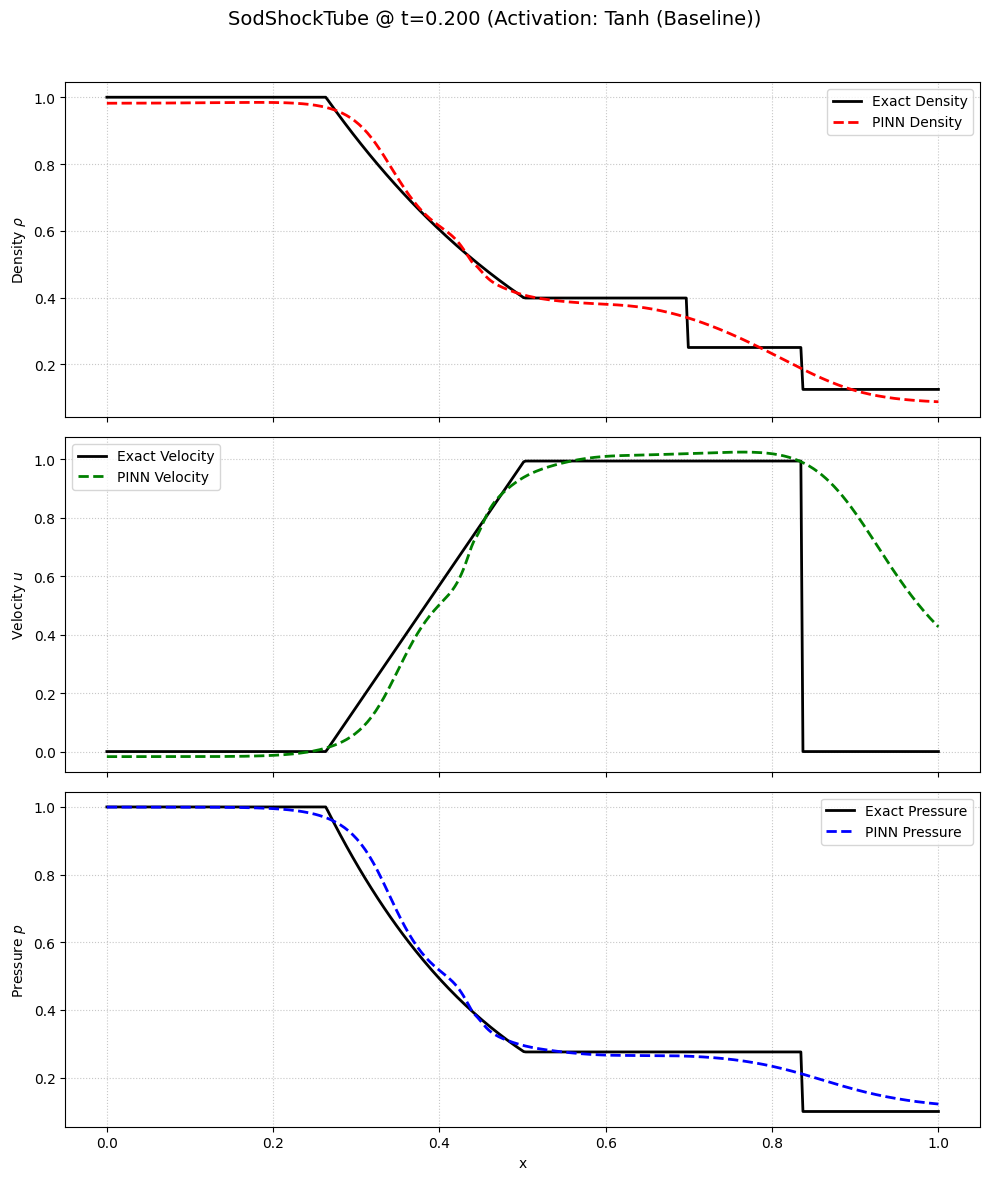

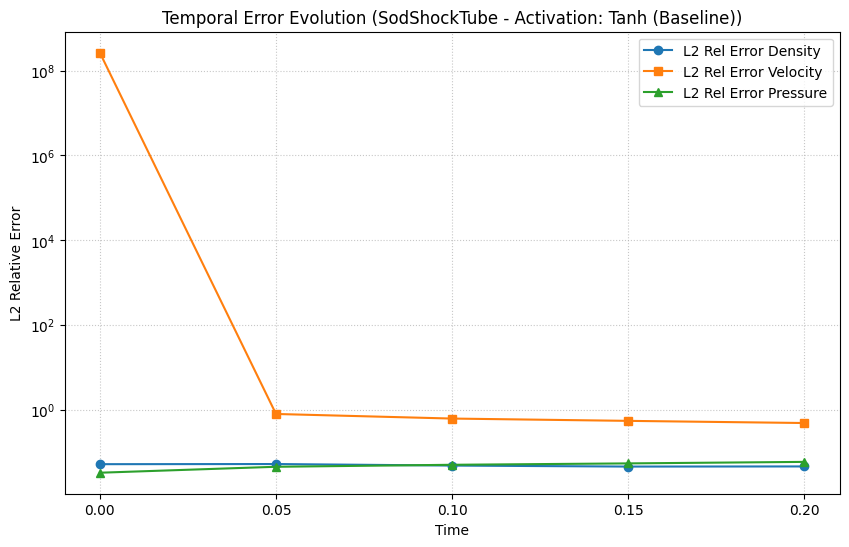


--- Running Experiment for Activation: Gaussian (alpha=5 Fixed) ---
Parameters: Epochs=30000, LR=0.0005, IC_Weight=500.0, GradClip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 8.7993e+14 (PDE: 8.7993e+14, IC: 1.7650e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 4.7284e+00 (PDE: 1.2946e-01, IC: 9.1978e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.9804e+00 (PDE: 5.8183e-02, IC: 7.8445e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 3.1987e+00 (PDE: 1.1314e-01, IC: 6.1712e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.9838e+00 (PDE: 1.8125e-01, IC: 5.6050e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 1.8635e+00 (PDE: 7.0058e-02, IC: 3.5868e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.14e-01/1.01e+00), u(-6.99e-03/9.90e-01), p(9.77e-02/1.01e+00)
Epoch 7200/30000 -> Loss: 2.0280e+00 (PDE: 6.9738e-02, IC: 3.9164e-03), LR: 5.00e-04
Epoch 8400/30000 -> Loss: 4.0093e+00 (PDE: 8.6765e-02, IC: 7.8451e-03), LR: 4.25e-04
Epoch 9600/30000 -> Loss: 1.5617e+00 (PDE: 1.1240e-01, IC: 2.8

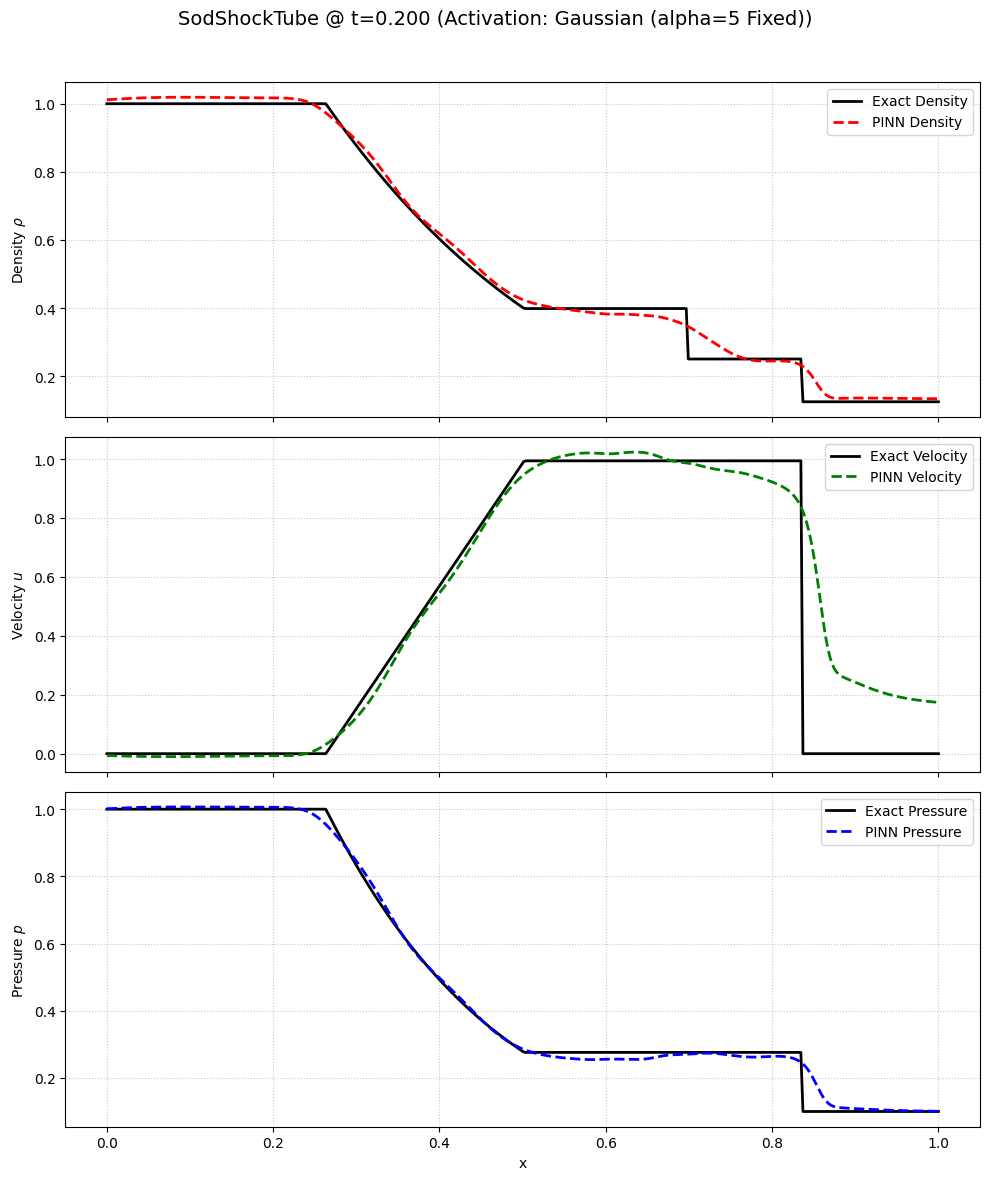

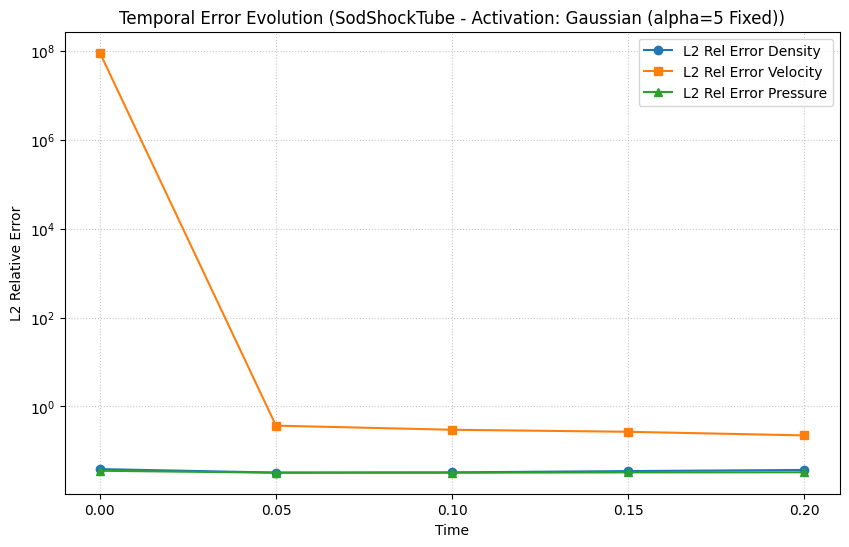


--- Running Experiment for Activation: Gaussian (alpha Learn, init=5) ---
Parameters: Epochs=30000, LR=0.0005, IC_Weight=500.0, GradClip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 5.0408e+14 (PDE: 5.0408e+14, IC: 8.5708e-01), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 3.5237e+00 (PDE: 1.3623e-01, IC: 6.7750e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 4.1534e+00 (PDE: 4.8913e-01, IC: 7.3285e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 4.0416e+00 (PDE: 3.3481e-01, IC: 7.4135e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 5.4487e+00 (PDE: 1.3887e-01, IC: 1.0620e-02), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 1.4940e+00 (PDE: 7.7449e-02, IC: 2.8332e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.22e-01/9.99e-01), u(9.50e-03/1.02e+00), p(9.99e-02/1.01e+00)
Epoch 7200/30000 -> Loss: 8.1753e+00 (PDE: 1.9334e-01, IC: 1.5964e-02), LR: 5.00e-04
Epoch 8400/30000 -> Loss: 1.5062e+00 (PDE: 1.2113e-01, IC: 2.7701e-03), LR: 4.25e-04
Epoch 9600/30000 -> Loss: 9.2667e-01 (PDE: 8.9072e-02, IC

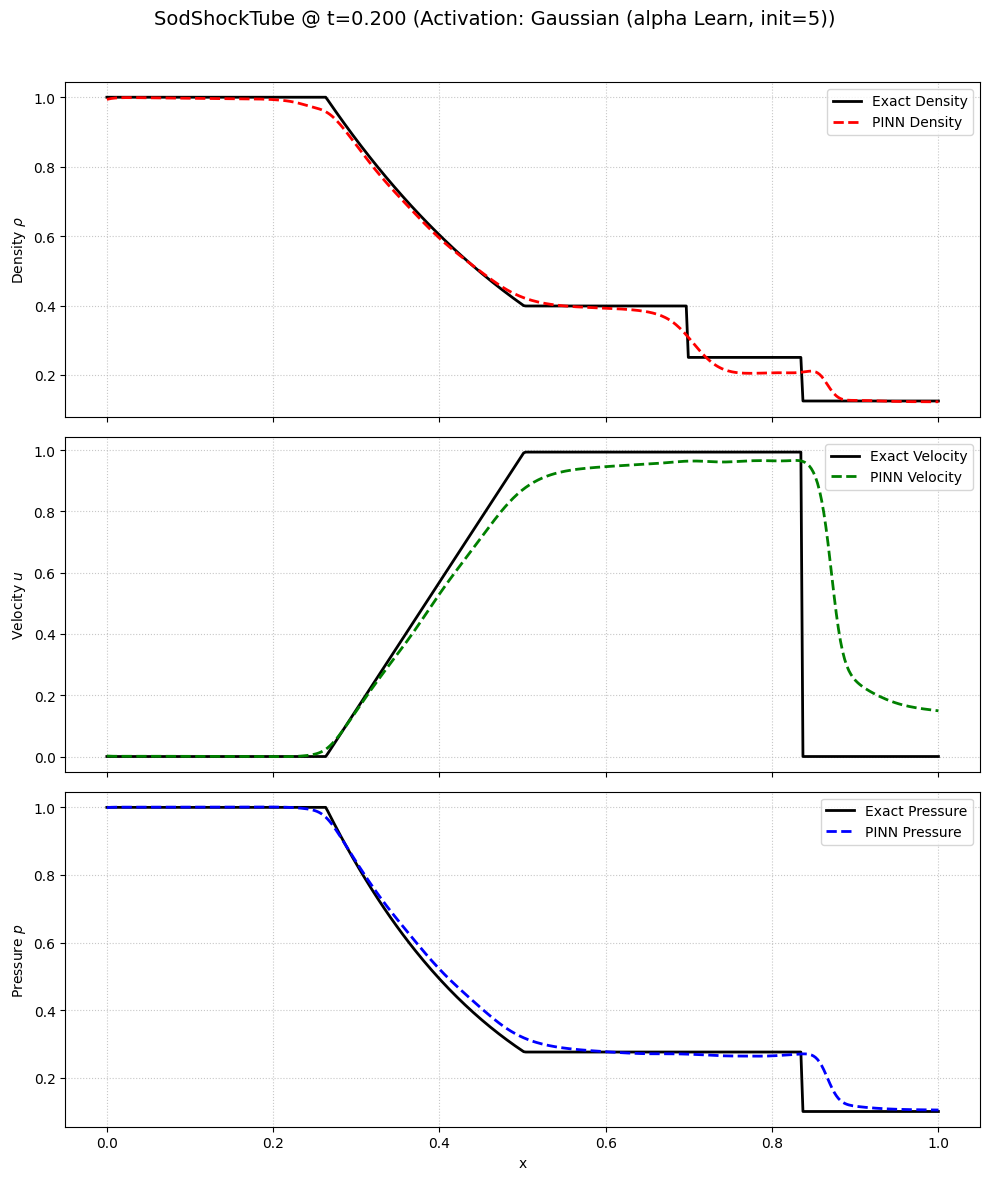

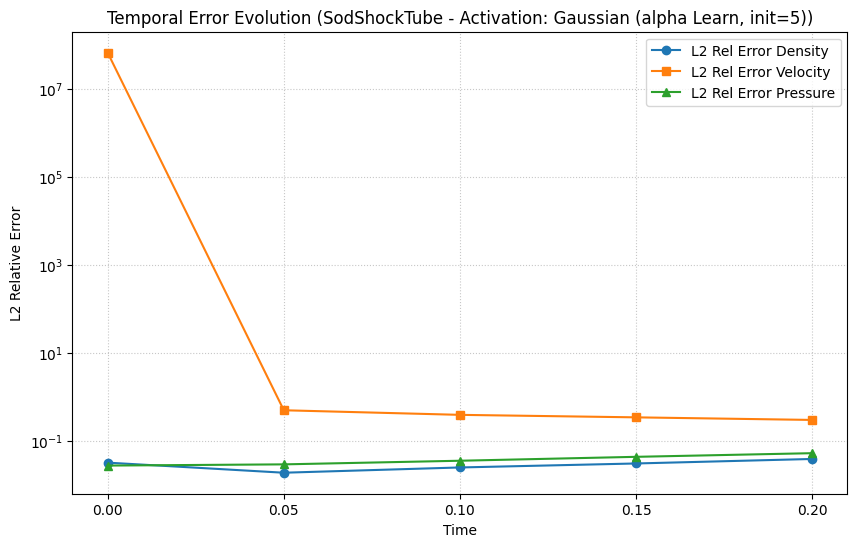

  Final learnable alpha (for Gaussian (alpha Learn, init=5)): 5.1815

--- Running Experiment for Activation: MexicanHat (s=1 Fixed) ---
Parameters: Epochs=30000, LR=0.0005, IC_Weight=500.0, GradClip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 4.3202e+02 (PDE: 3.0399e-05, IC: 8.6405e-01), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 3.9838e+00 (PDE: 7.8015e-01, IC: 6.4073e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.3096e+00 (PDE: 5.1888e-01, IC: 5.5814e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.3861e+00 (PDE: 1.4133e-01, IC: 4.4895e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.2299e+00 (PDE: 5.1315e-01, IC: 3.4336e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 3.6876e+00 (PDE: 1.2347e+00, IC: 4.9059e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.13e-01/1.01e+00), u(-1.20e-01/9.23e-01), p(1.04e-01/1.01e+00)
Epoch 7200/30000 -> Loss: 1.5077e+00 (PDE: 2.4692e-01, IC: 2.5216e-03), LR: 5.00e-04
Epoch 8400/30000 -> Loss: 1.3159e+00 (PDE: 1.1022e-01, IC: 2.4113e-03), LR: 4.25

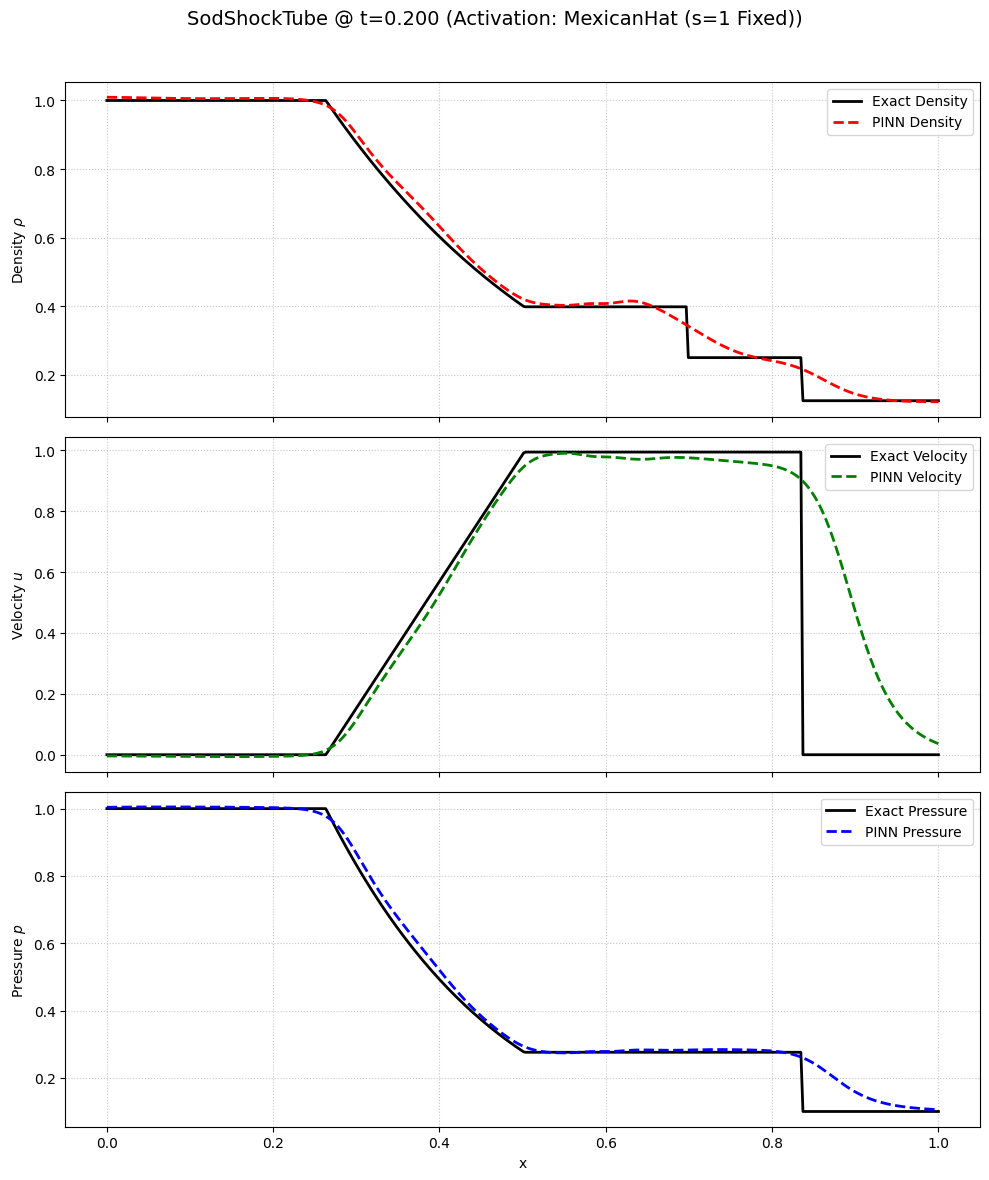

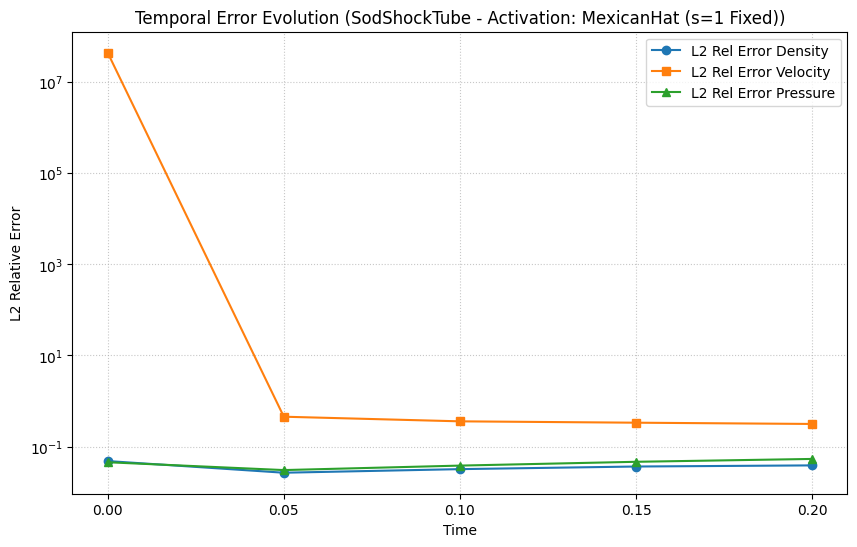


--- Running Experiment for Activation: MexicanHat (s Learn, init=1) ---
Parameters: Epochs=30000, LR=0.0005, IC_Weight=500.0, GradClip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 6.0758e+12 (PDE: 6.0758e+12, IC: 1.5189e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 3.3823e+00 (PDE: 3.1754e-01, IC: 6.1295e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.2286e+00 (PDE: 7.5903e-02, IC: 6.3054e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.6675e+00 (PDE: 7.2449e-02, IC: 5.1902e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.9587e+00 (PDE: 6.7570e-02, IC: 5.7822e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 2.4909e+00 (PDE: 5.5731e-02, IC: 4.8704e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.09e-01/1.00e+00), u(-3.58e-02/1.02e+00), p(9.69e-02/1.00e+00)
Epoch 7200/30000 -> Loss: 2.7850e+00 (PDE: 3.2594e-01, IC: 4.9181e-03), LR: 5.00e-04
Epoch 8400/30000 -> Loss: 1.9702e+00 (PDE: 5.4709e-02, IC: 3.8310e-03), LR: 4.25e-04
Epoch 9600/30000 -> Loss: 1.8668e+00 (PDE: 7.8637e-02, IC:

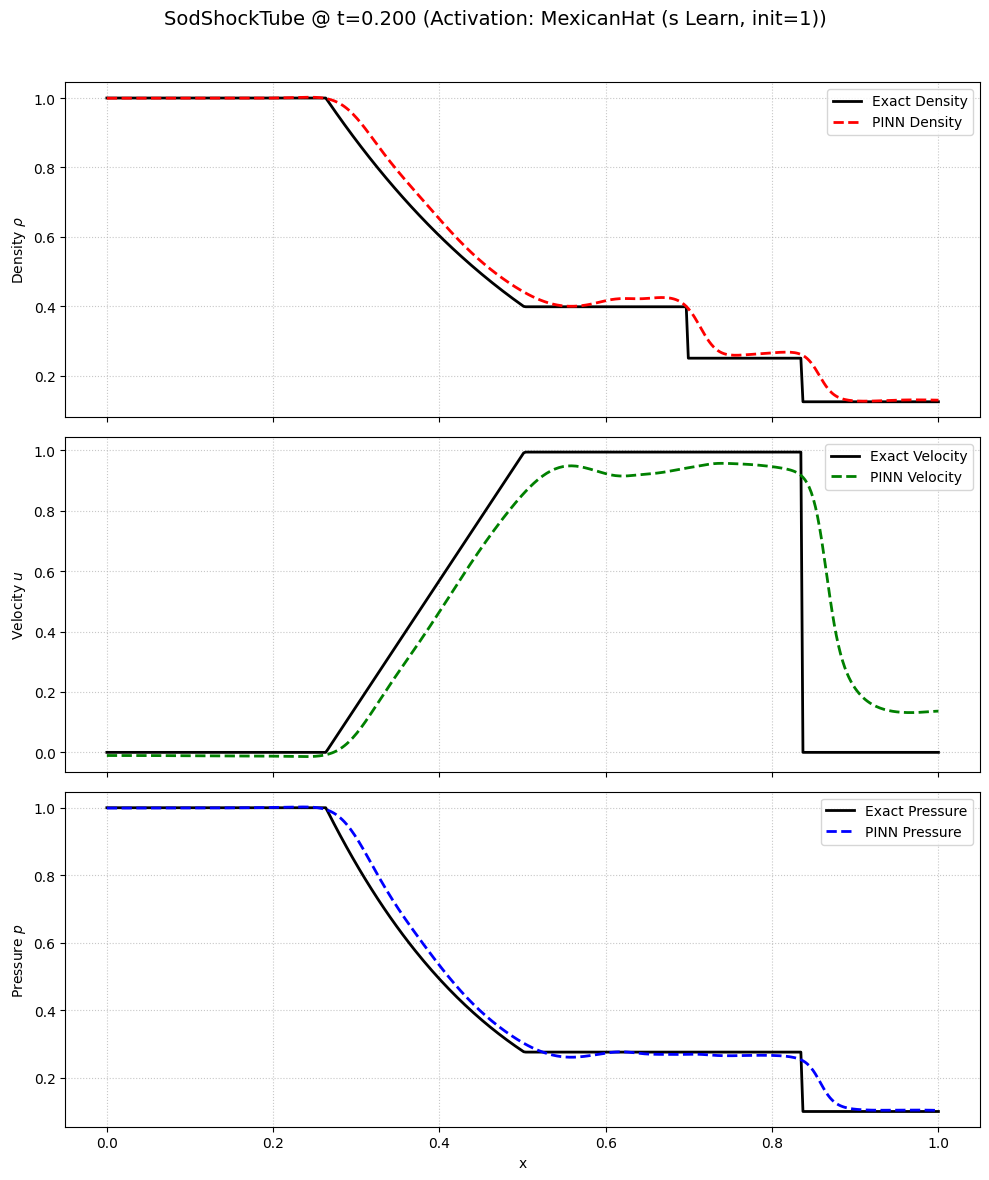

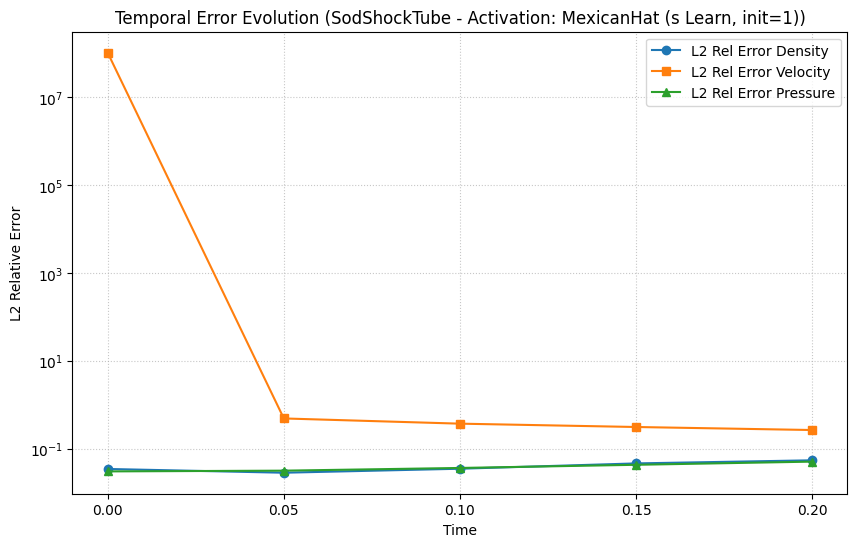

  Final learnable sigma (for MexicanHat (s Learn, init=1)): 0.9949

--- Running Experiment for Activation: MexHat (s Learn, init=1, L8_U192) ---
Parameters: Epochs=30000, LR=0.0005, IC_Weight=500.0, GradClip=1.0, Layers=8, Units=192
Epoch 0/30000 -> Loss: 2.3632e+12 (PDE: 2.3632e+12, IC: 3.0300e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 3.5558e+00 (PDE: 5.1058e-01, IC: 6.0905e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 6.7624e+00 (PDE: 5.2672e-01, IC: 1.2471e-02), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.5144e+00 (PDE: 2.4310e-01, IC: 4.5426e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.0305e+00 (PDE: 1.7008e-01, IC: 3.7208e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 7.4944e+00 (PDE: 4.5052e-01, IC: 1.4088e-02), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.11e-01/1.00e+00), u(4.77e-03/9.37e-01), p(9.62e-02/1.00e+00)
Epoch 7200/30000 -> Loss: 2.8907e+00 (PDE: 8.4990e-01, IC: 4.0816e-03), LR: 5.00e-04
Epoch 8400/30000 -> Loss: 1.2715e+00 (PDE: 1.5781e-01, IC: 2.2274e-03), 

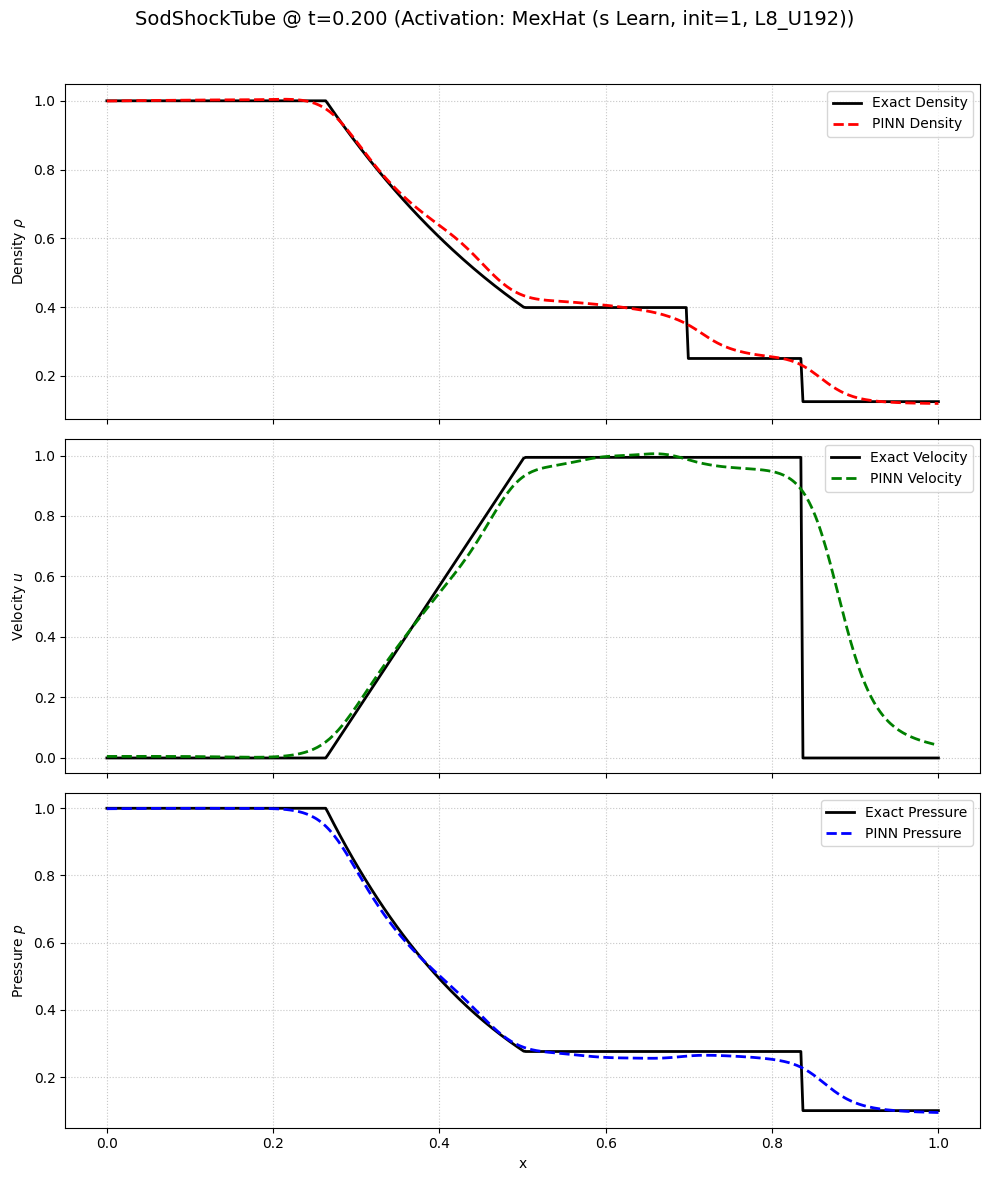

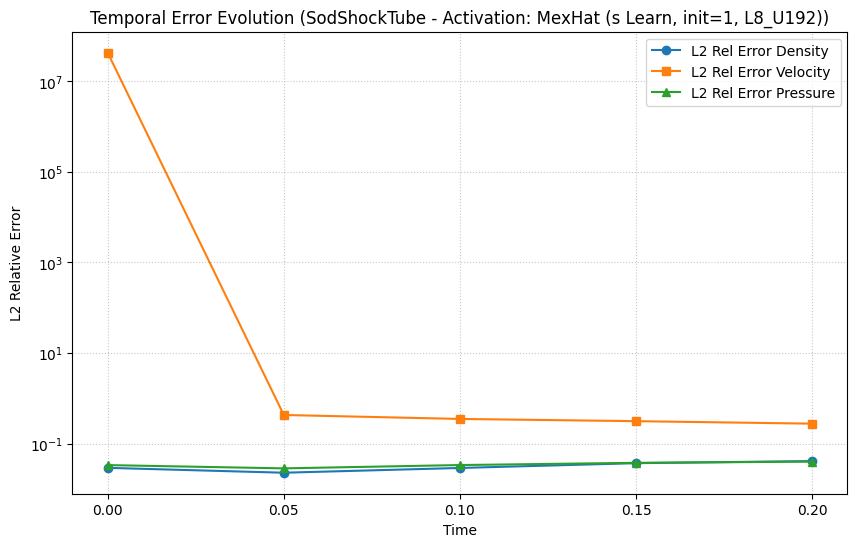

  Final learnable sigma (for MexHat (s Learn, init=1, L8_U192)): 0.9712

--- Running Experiment for Activation: Morlet (s0.7,w5 Fixed) ---
Parameters: Epochs=30000, LR=0.0005, IC_Weight=500.0, GradClip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 8.8262e+19 (PDE: 8.8262e+19, IC: 1.5289e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 1.2536e+01 (PDE: 2.9515e+00, IC: 1.9169e-02), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.8820e+00 (PDE: 1.3150e+00, IC: 5.1339e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 6.2345e+00 (PDE: 2.5914e+00, IC: 7.2861e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 8.3926e+00 (PDE: 2.5436e+00, IC: 1.1698e-02), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 3.2531e+00 (PDE: 2.0068e+00, IC: 2.4927e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.34e-01/1.02e+00), u(-3.67e-03/8.58e-01), p(9.76e-02/1.00e+00)
Epoch 7200/30000 -> Loss: 1.4319e+00 (PDE: 2.2455e-01, IC: 2.4147e-03), LR: 5.00e-04
Epoch 8400/30000 -> Loss: 2.5997e+00 (PDE: 1.0530e+00, IC: 3.0933e-03), LR: 4

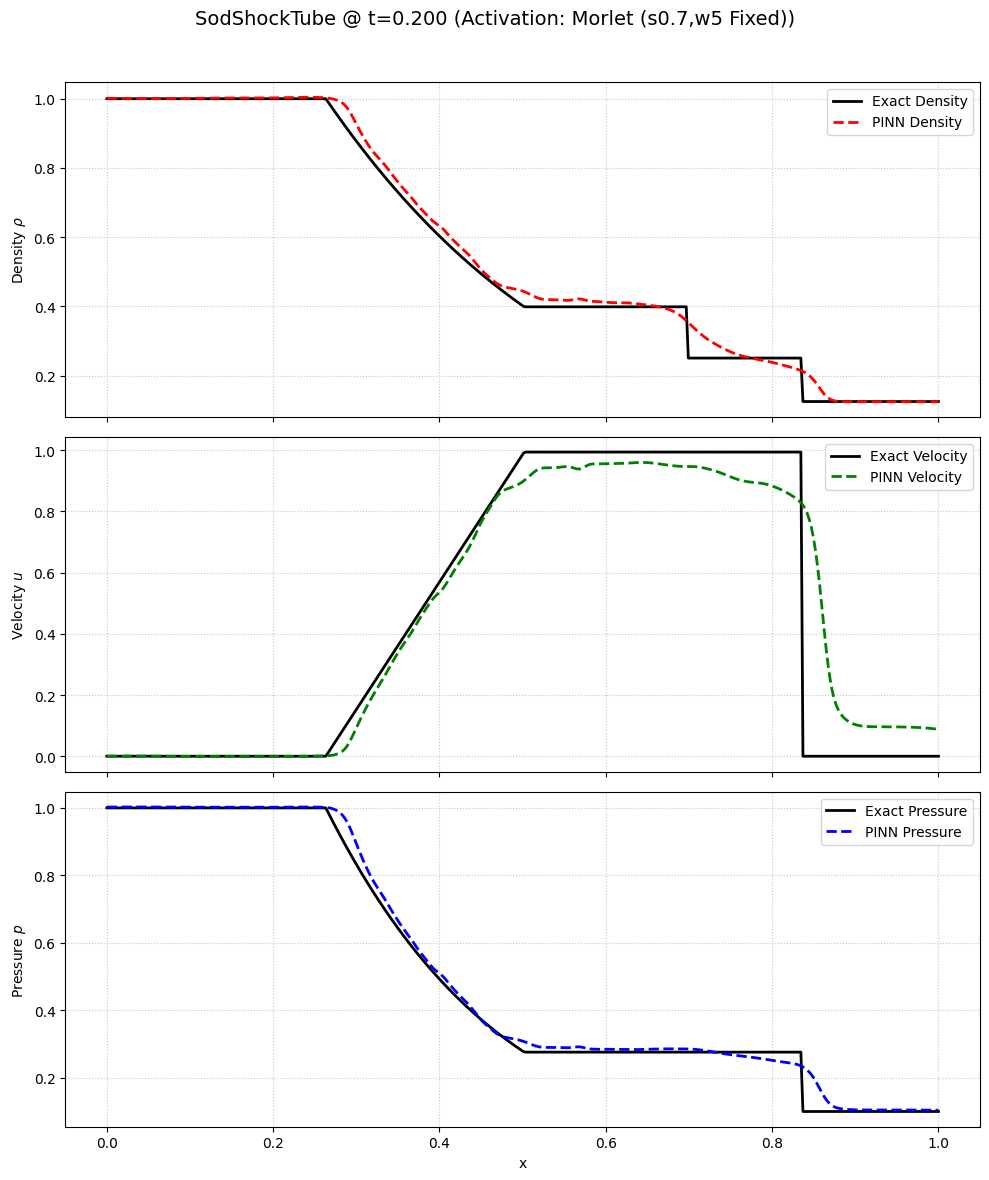

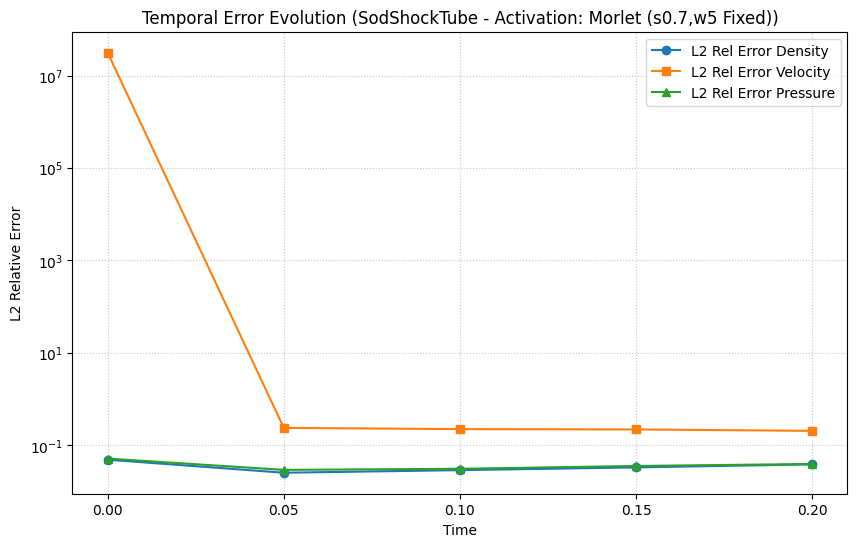


--- Running Experiment for Activation: Morlet (s,w0 Learn, init s0.7,w5) ---
Parameters: Epochs=30000, LR=0.0005, IC_Weight=500.0, GradClip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 1.5311e+20 (PDE: 1.5311e+20, IC: 1.1233e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 3.7661e+00 (PDE: 8.8720e-01, IC: 5.7577e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 2.4442e+00 (PDE: 9.6275e-01, IC: 2.9629e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 1.6999e+00 (PDE: 7.4582e-01, IC: 1.9082e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 1.3832e+00 (PDE: 2.8391e-01, IC: 2.1985e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 4.1252e+00 (PDE: 7.9896e-01, IC: 6.6524e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.20e-01/1.02e+00), u(-2.07e-02/6.85e-01), p(9.23e-02/1.01e+00)
Epoch 7200/30000 -> Loss: 1.2225e+00 (PDE: 3.8880e-01, IC: 1.6674e-03), LR: 5.00e-04
Epoch 8400/30000 -> Loss: 7.5444e+00 (PDE: 4.5974e-01, IC: 1.4169e-02), LR: 4.25e-04
Epoch 9600/30000 -> Loss: 8.7221e-01 (PDE: 3.6353e-01

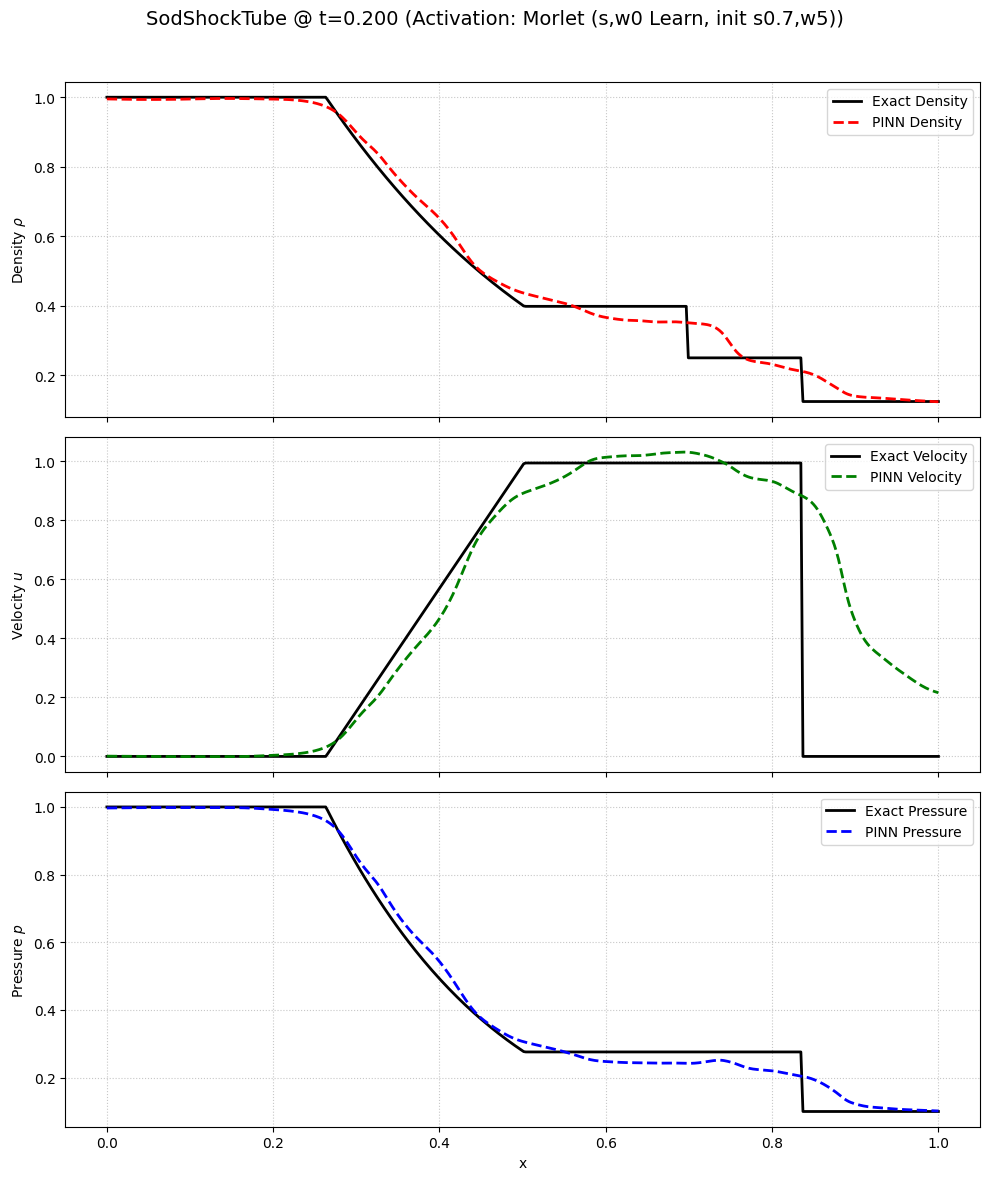

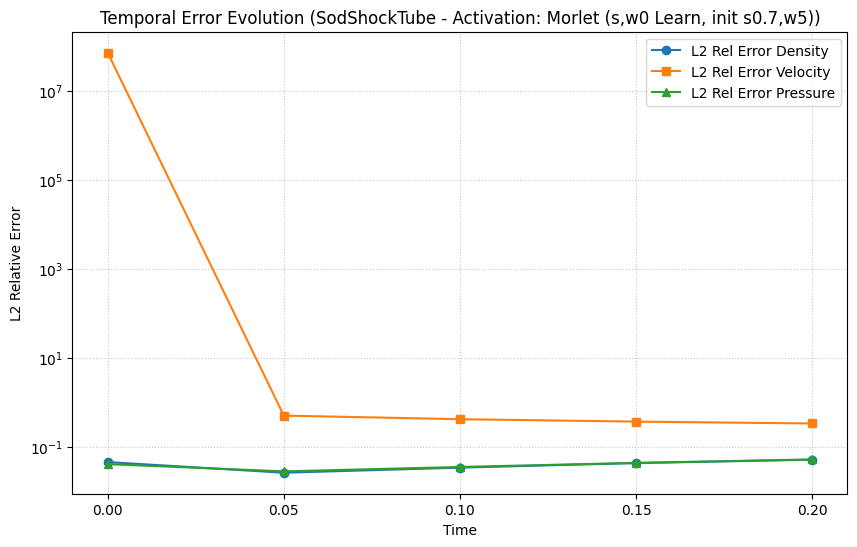

  Final learnable sigma (for Morlet (s,w0 Learn, init s0.7,w5)): 0.3110
  Final learnable omega0 (for Morlet (s,w0 Learn, init s0.7,w5)): 4.2786

--- Running Experiment for Activation: LeakyReLU (Default) ---
Parameters: Epochs=30000, LR=0.0005, IC_Weight=500.0, GradClip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 6.2966e+02 (PDE: 1.9006e-01, IC: 1.2589e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 8.5508e+00 (PDE: 2.4627e+00, IC: 1.2176e-02), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 4.7277e+00 (PDE: 1.1251e+00, IC: 7.2052e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.6433e+00 (PDE: 4.1335e-01, IC: 4.4598e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.1001e+00 (PDE: 3.1789e-01, IC: 3.5644e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 1.7929e+00 (PDE: 1.6636e-01, IC: 3.2531e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(9.37e-02/1.01e+00), u(-5.62e-04/1.12e+00), p(8.80e-02/1.01e+00)
Epoch 7200/30000 -> Loss: 1.5786e+00 (PDE: 1.7372e-01, IC: 2.8097e-03), LR: 5.00e-04
Epoch 8

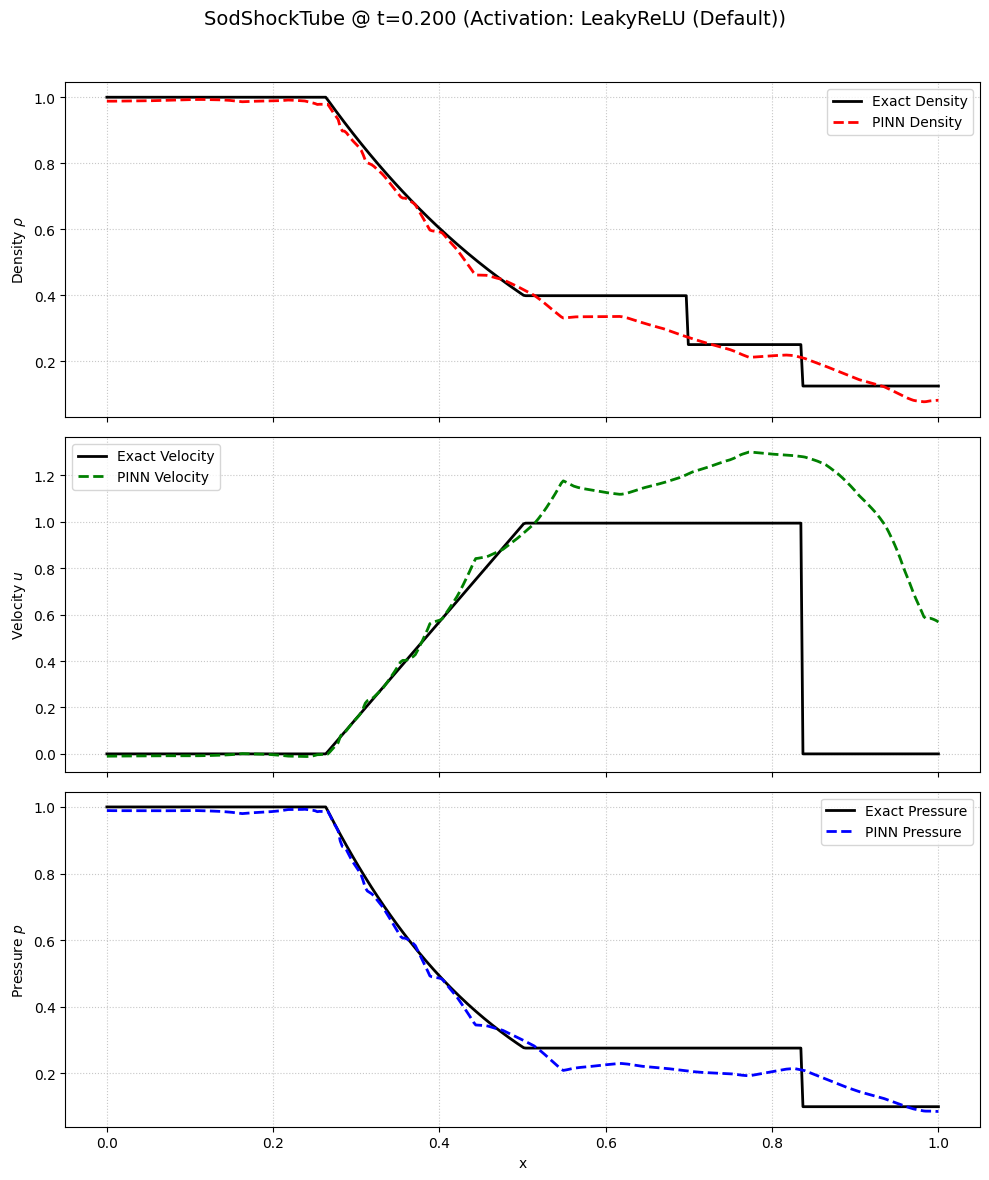

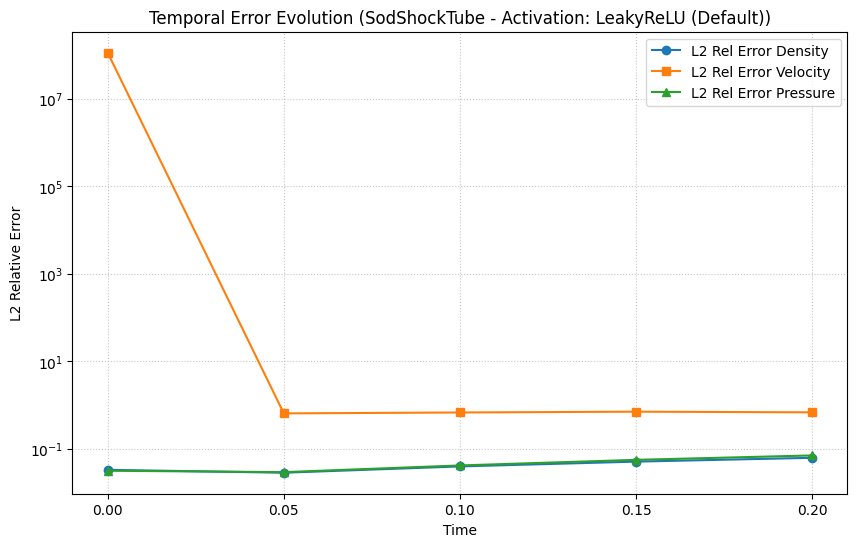


--- Running Experiment for Activation: Sigmoid ---
Parameters: Epochs=30000, LR=0.0005, IC_Weight=500.0, GradClip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 2.4198e+04 (PDE: 2.3392e+04, IC: 1.6122e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 2.4284e+02 (PDE: 1.3055e-11, IC: 4.8568e-01), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 2.4284e+02 (PDE: 2.2628e-11, IC: 4.8568e-01), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.4283e+02 (PDE: 2.6268e-10, IC: 4.8567e-01), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.4284e+02 (PDE: 1.2274e-12, IC: 4.8568e-01), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 2.4284e+02 (PDE: 6.2702e-12, IC: 4.8568e-01), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(5.62e-01/5.62e-01), u(1.09e-04/1.09e-04), p(5.50e-01/5.50e-01)
Epoch 7200/30000 -> Loss: 2.4284e+02 (PDE: 4.3187e-11, IC: 4.8567e-01), LR: 5.00e-04
Epoch 8400/30000 -> Loss: 2.4283e+02 (PDE: 1.7320e-09, IC: 4.8565e-01), LR: 4.25e-04
Epoch 9600/30000 -> Loss: 1.9046e+10 (PDE: 1.9046e+10, IC: 1.4249e-01), LR: 4.25

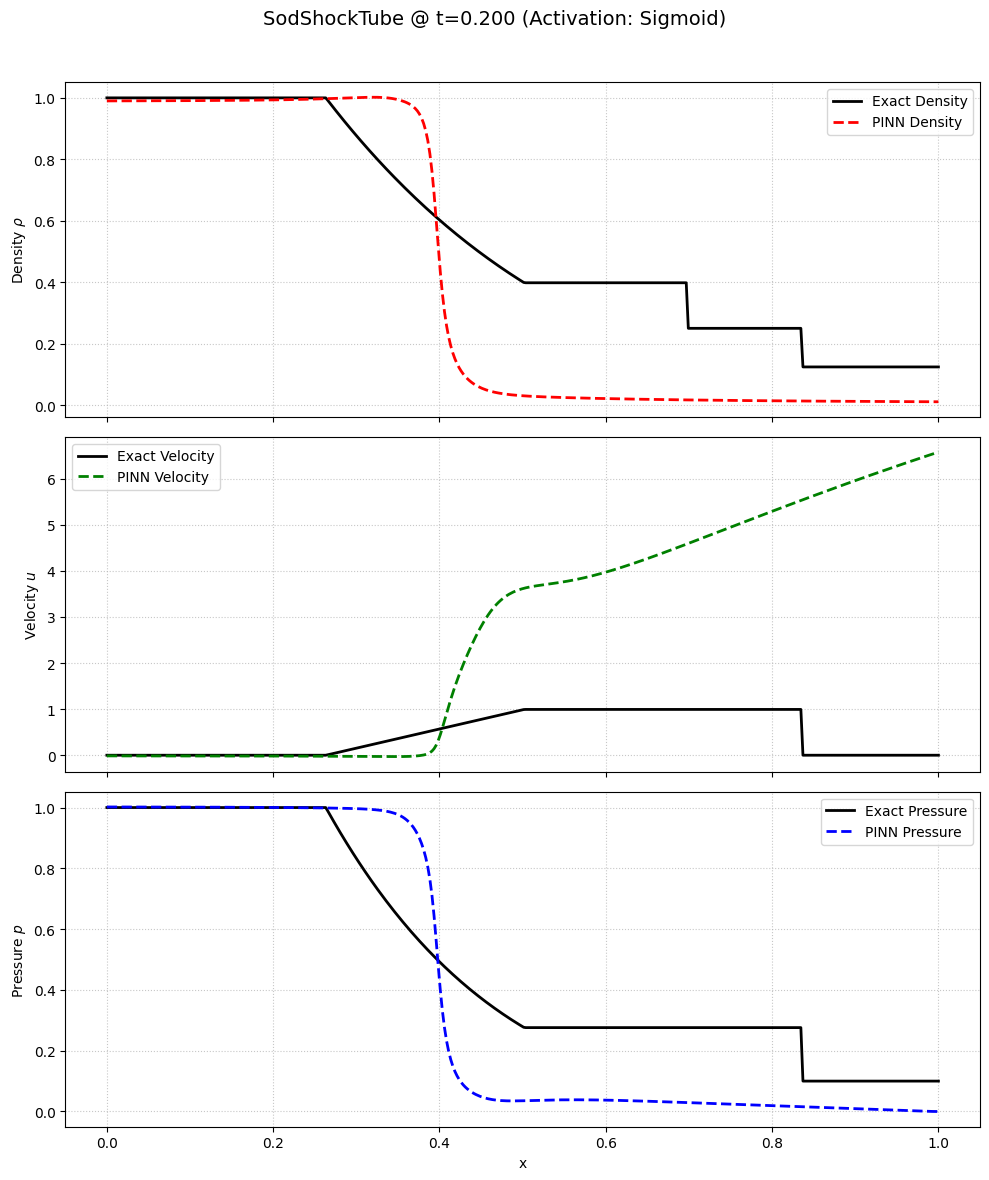

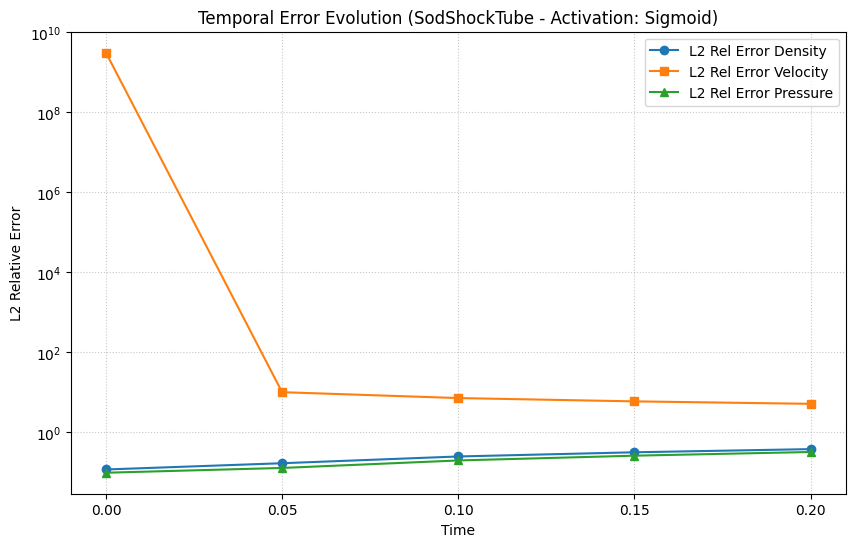



--- Overall Comparison Summary (Errors at t_final) ---
Activation Config                             | Rho L1  | Rho L2  | U L1    | U L2    | P L1    | P L2    | Time (s)
--------------------------------------------------------------------------------------------------------------------
Tanh (Baseline)                               | 4.31e-02 | 4.53e-02 | 3.22e-01 | 4.80e-01 | 4.78e-02 | 5.81e-02 | 547.45
Gaussian (alpha=5 Fixed)                      | 3.25e-02 | 3.71e-02 | 1.50e-01 | 2.23e-01 | 2.26e-02 | 3.29e-02 | 776.07
Gaussian (alpha Learn, init=5)                | 2.88e-02 | 3.83e-02 | 1.86e-01 | 2.95e-01 | 3.17e-02 | 5.18e-02 | 842.42
MexicanHat (s=1 Fixed)                        | 3.15e-02 | 3.89e-02 | 1.83e-01 | 3.14e-01 | 3.49e-02 | 5.38e-02 | 1273.88
MexicanHat (s Learn, init=1)                  | 4.11e-02 | 5.53e-02 | 2.15e-01 | 2.70e-01 | 3.55e-02 | 5.16e-02 | 1414.71
MexHat (s Learn, init=1, L8_U192)             | 3.05e-02 | 4.13e-02 | 1.57e-01 | 2.76e-01 | 2.91e-02 |

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import brentq # For the Riemann solver root finding

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GAMMA = 1.4  # Ratio of specific heats
print(f"Using device: {DEVICE}")

# --- 1. Euler Equations & Riemann Problem Utilities ---
def primitive_to_conserved(rho, u, p):
    rho = torch.as_tensor(rho, dtype=torch.float32, device=DEVICE)
    u = torch.as_tensor(u, dtype=torch.float32, device=DEVICE)
    p = torch.as_tensor(p, dtype=torch.float32, device=DEVICE)
    E_internal = p / ((GAMMA - 1.0) * rho.clamp(min=1e-9))
    E_total = rho * (E_internal + 0.5 * u**2)
    return torch.stack([rho, rho * u, E_total], dim=-1)

def conserved_to_primitive(Q_conserved):
    rho = Q_conserved[..., 0:1].clamp(min=1e-9)
    rhou = Q_conserved[..., 1:2]
    E_total_conserved = Q_conserved[..., 2:3]
    u = rhou / rho 
    pressure_val = (E_total_conserved - 0.5 * rhou**2 / rho) * (GAMMA - 1.0)
    p = pressure_val.clamp(min=1e-9)
    return rho, u, p

def euler_fluxes_conserved(Q_conserved):
    rho, u, p = conserved_to_primitive(Q_conserved)
    F_component_0 = Q_conserved[..., 1:2]
    F_component_1 = Q_conserved[..., 1:2] * u + p
    F_component_2 = (Q_conserved[..., 2:3] + p) * u
    return torch.cat([F_component_0, F_component_1, F_component_2], dim=-1)

# --- Initial Conditions (Sod Shock Tube) ---
DIAPHRAGM_LOCATION = 0.5
def get_sod_initial_conditions(x_coords): 
    rho_ic = torch.where(x_coords < DIAPHRAGM_LOCATION, torch.tensor(1.0), torch.tensor(0.125)).to(DEVICE)
    p_ic = torch.where(x_coords < DIAPHRAGM_LOCATION, torch.tensor(1.0), torch.tensor(0.1)).to(DEVICE)
    u_ic = torch.zeros_like(x_coords).to(DEVICE)
    return primitive_to_conserved(rho_ic, u_ic, p_ic)

# --- Exact Riemann Solver for Sod Problem (Ground Truth) ---
def exact_sod_solver(x_np, t_val):
    rho_L, u_L, p_L = 1.0, 0.0, 1.0
    rho_R, u_R, p_R = 0.125, 0.0, 0.1
    
    if abs(t_val) < 1e-9: 
        rho = np.where(x_np < DIAPHRAGM_LOCATION, rho_L, rho_R)
        u = np.where(x_np < DIAPHRAGM_LOCATION, u_L, u_R)
        p = np.where(x_np < DIAPHRAGM_LOCATION, p_L, p_R)
        return rho, u, p

    a_L = np.sqrt(GAMMA * p_L / rho_L)
    a_R = np.sqrt(GAMMA * p_R / rho_R)

    def F_k(P_star_func, P_k_func, RHO_k_func, A_k_func):
        if P_star_func > P_k_func:
            den_shock = RHO_k_func * ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star_func + (GAMMA - 1.0) / (2.0 * GAMMA) * P_k_func )
            return (P_star_func - P_k_func) / np.sqrt(max(1e-12, den_shock))
        else:
            pressure_ratio_clipped = max(1e-12, P_star_func / P_k_func)
            return (2.0 * A_k_func / (GAMMA - 1.0)) * ( pressure_ratio_clipped**((GAMMA - 1.0) / (2.0 * GAMMA)) - 1.0 )

    def pressure_function_for_root(P_star_guess_func):
        return F_k(P_star_guess_func, p_L, rho_L, a_L) + F_k(P_star_guess_func, p_R, rho_R, a_R) - (u_L - u_R)

    p_min_search = 1e-7 
    p_max_search = max(p_L, p_R) * 50.0 
    P_star = 0.30313 
    try:
        P_star = brentq(pressure_function_for_root, p_min_search, p_max_search, xtol=1e-12, rtol=1e-12)
    except (ValueError, RuntimeError) as e:
        print(f"Warning: Root finding for P_star failed or did not converge. Error: {e}. Using approximate P_star={P_star} for Sod.")

    U_star = 0.5 * (u_L + u_R) + 0.5 * (F_k(P_star, p_R, rho_R, a_R) - F_k(P_star, p_L, rho_L, a_L))

    if P_star > p_L:
        rho_star_L = rho_L * ( (P_star / p_L + (GAMMA - 1.0) / (GAMMA + 1.0)) / \
                               ( max(1e-12, (GAMMA - 1.0) / (GAMMA + 1.0) * P_star / p_L + 1.0)) )
    else:
        rho_star_L = rho_L * max(1e-12, P_star / p_L)**(1.0 / GAMMA)

    if P_star > p_R:
        rho_star_R = rho_R * ( (P_star / p_R + (GAMMA - 1.0) / (GAMMA + 1.0)) / \
                               ( max(1e-12, (GAMMA - 1.0) / (GAMMA + 1.0) * P_star / p_R + 1.0)) )
    else:
        rho_star_R = rho_R * max(1e-12, P_star / p_R)**(1.0 / GAMMA)
    
    rho_star_L = max(1e-9, rho_star_L) 
    rho_star_R = max(1e-9, rho_star_R) 

    S_contact = U_star 
    
    if P_star > p_L: 
        S_L = u_L - a_L * np.sqrt( max(1e-12, ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star / p_L + (GAMMA - 1.0) / (2.0 * GAMMA) ) ))
    else: 
        a_star_L = np.sqrt(GAMMA * P_star / rho_star_L) 
        S_HL = u_L - a_L 
        S_TL = U_star - a_star_L 

    if P_star > p_R: 
        S_R = u_R + a_R * np.sqrt( max(1e-12, ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star / p_R + (GAMMA - 1.0) / (2.0 * GAMMA) ) ))
    else: 
        a_star_R = np.sqrt(GAMMA * P_star / rho_star_R) 
        S_HR = u_R + a_R 
        S_TR = U_star + a_star_R 
        
    rho_sol = np.zeros_like(x_np)
    u_sol = np.zeros_like(x_np)
    p_sol = np.zeros_like(x_np)

    for i, x_pos in enumerate(x_np):
        s_lambda = (x_pos - DIAPHRAGM_LOCATION) / t_val 
        
        if s_lambda <= S_contact: 
            if P_star > p_L: # Left Shock
                if s_lambda < S_L: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_L, u_L, p_L
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_L, U_star, P_star
            else: # Left Rarefaction
                if s_lambda < S_HL: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_L, u_L, p_L
                elif s_lambda <= S_TL: 
                    u_sol[i] = (2.0 / (GAMMA + 1.0)) * (a_L + (GAMMA - 1.0) / 2.0 * u_L + s_lambda)
                    common_term_L = (2.0 / (GAMMA + 1.0)) + ( (GAMMA - 1.0) / ((GAMMA + 1.0) * a_L) ) * (u_L - s_lambda)
                    rho_sol[i] = rho_L * max(1e-12, common_term_L)**(2.0 / (GAMMA - 1.0))
                    p_sol[i] = p_L * max(1e-12, rho_sol[i] / max(1e-12, rho_L))**GAMMA
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_L, U_star, P_star
        else: 
            if P_star > p_R: # Right Shock
                if s_lambda < S_R: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_R, U_star, P_star
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_R, u_R, p_R
            else: # Right Rarefaction
                if s_lambda <= S_TR: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_R, U_star, P_star
                elif s_lambda < S_HR: 
                    u_sol[i] = (2.0 / (GAMMA + 1.0)) * (-a_R + (GAMMA - 1.0) / 2.0 * u_R + s_lambda)
                    common_term_R = (2.0 / (GAMMA + 1.0)) - ( (GAMMA - 1.0) / ((GAMMA + 1.0) * a_R) ) * (u_R - s_lambda)
                    rho_sol[i] = rho_R * max(1e-12, common_term_R)**(2.0 / (GAMMA - 1.0))
                    p_sol[i] = p_R * max(1e-12, rho_sol[i] / max(1e-12, rho_R))**GAMMA
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_R, u_R, p_R
    return rho_sol, u_sol, p_sol


# --- Wavelet-Inspired Activation Functions (with learnable parameter option) ---
class GaussianActivation(nn.Module):
    def __init__(self, initial_alpha=1.0, learnable=False): 
        super().__init__()
        if learnable:
            self.alpha = nn.Parameter(torch.tensor(float(initial_alpha)))
        else:
            self.alpha_val = initial_alpha 
            self.alpha = None 
    def forward(self, x):
        current_alpha = self.alpha if self.alpha is not None else self.alpha_val
        return torch.exp(-current_alpha * x**2)

class MexicanHatActivation(nn.Module):
    def __init__(self, initial_sigma=1.0, learnable=False): 
        super().__init__()
        if learnable:
            self.sigma = nn.Parameter(torch.tensor(float(initial_sigma)))
        else:
            self.sigma_val = initial_sigma
            self.sigma = None
    def forward(self, x):
        current_sigma = self.sigma if self.sigma is not None else self.sigma_val
        effective_sigma = current_sigma.clamp(min=1e-6) if isinstance(current_sigma, torch.Tensor) else max(1e-6, current_sigma)
        x_scaled = x / effective_sigma
        return (1 - x_scaled**2) * torch.exp(-x_scaled**2 / 2.0)

class MorletActivation(nn.Module):
    def __init__(self, initial_sigma=1.0, initial_omega0=5.0, learnable=False): 
        super().__init__()
        if learnable:
            self.sigma = nn.Parameter(torch.tensor(float(initial_sigma)))
            self.omega0 = nn.Parameter(torch.tensor(float(initial_omega0)))
        else:
            self.sigma_val = initial_sigma
            self.omega0_val = initial_omega0
            self.sigma = None 
            self.omega0 = None 
            
    def forward(self, x):
        current_sigma = self.sigma if self.sigma is not None else self.sigma_val
        current_omega0 = self.omega0 if self.omega0 is not None else self.omega0_val
        
        effective_sigma = current_sigma.clamp(min=1e-6) if isinstance(current_sigma, torch.Tensor) else max(1e-6, current_sigma)
        scaled_x_env = x / effective_sigma
        envelope = torch.exp(-0.5 * scaled_x_env**2)
        carrier = torch.cos(current_omega0 * x) 
        return envelope * carrier

# --- PINN Model (Accepts custom activation) ---
class CustomActivationPINN(nn.Module):
    def __init__(self, num_input_features=2, num_output_features=3, num_layers=5, hidden_units=64, activation_module=None):
        super(CustomActivationPINN, self).__init__()
        self.activation = activation_module if activation_module is not None else nn.Tanh()

        layers = []
        layers.append(nn.Linear(num_input_features, hidden_units))
        layers.append(self.activation)
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_units, hidden_units), self.activation])
        layers.append(nn.Linear(hidden_units, num_output_features))
        self.network = nn.Sequential(*layers)

    def forward(self, x_t_coords):
        return self.network(x_t_coords)

# --- Loss Functions ---
def pde_residual_loss_euler(model, x_colloc, t_colloc):
    x_colloc.requires_grad_(True)
    t_colloc.requires_grad_(True)
    xt_coords = torch.stack([x_colloc, t_colloc], dim=-1)
    Q_pred = model(xt_coords)

    dQ_dt_components = []
    for i in range(Q_pred.shape[1]):
        grad_q_i_dt = torch.autograd.grad(Q_pred[:, i].sum(), t_colloc, create_graph=True)[0]
        dQ_dt_components.append(grad_q_i_dt.unsqueeze(-1))
    dQ_dt = torch.cat(dQ_dt_components, dim=-1)

    F_pred = euler_fluxes_conserved(Q_pred)
    dF_dx_components = []
    for i in range(F_pred.shape[1]):
        grad_f_i_dx = torch.autograd.grad(F_pred[:, i].sum(), x_colloc, create_graph=True)[0]
        dF_dx_components.append(grad_f_i_dx.unsqueeze(-1))
    dF_dx = torch.cat(dF_dx_components, dim=-1)

    residuals = dQ_dt + dF_dx
    return torch.mean(residuals**2)

def initial_condition_loss_euler(model, x_ic_coords, ic_func):
    t_ic_coords = torch.zeros_like(x_ic_coords)
    Q_ic_true = ic_func(x_ic_coords)
    xt_coords_ic = torch.stack([x_ic_coords, t_ic_coords], dim=-1)
    Q_ic_pred = model(xt_coords_ic)
    return torch.mean((Q_ic_pred - Q_ic_true)**2)

# --- Training Loop (with stability enhancements) ---
def train_pinn(
    pinn_model, ic_func_train,
    epochs=10000, learning_rate=1e-3,
    x_domain_train=(-1.0, 1.0), t_max_train=0.2,
    num_colloc_train=2048, num_ic_train=512,
    pde_loss_weight_train=1.0, ic_loss_weight_train=10.0,
    print_every=1000,
    gradient_clip_value=None 
):
    optimizer = torch.optim.Adam(pinn_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(1, epochs // 4), gamma=0.85) 

    for epoch in range(epochs):
        pinn_model.train()
        optimizer.zero_grad()

        x_colloc = torch.rand(num_colloc_train, device=DEVICE) * (x_domain_train[1] - x_domain_train[0]) + x_domain_train[0]
        t_colloc = torch.rand(num_colloc_train, device=DEVICE) * t_max_train
        x_ic = torch.linspace(x_domain_train[0], x_domain_train[1], num_ic_train, device=DEVICE)

        loss_pde = pde_residual_loss_euler(pinn_model, x_colloc, t_colloc)
        loss_ic = initial_condition_loss_euler(pinn_model, x_ic, ic_func_train)
        total_loss = pde_loss_weight_train * loss_pde + ic_loss_weight_train * loss_ic
        
        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"Epoch {epoch}: Encountered NaN/Inf loss. Stopping training for this configuration.")
            return pinn_model 

        total_loss.backward()

        if gradient_clip_value is not None:
            torch.nn.utils.clip_grad_value_(pinn_model.parameters(), gradient_clip_value)

        optimizer.step()
        scheduler.step()

        if epoch % print_every == 0 or epoch == epochs - 1:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch}/{epochs} -> Loss: {total_loss.item():.4e} (PDE: {loss_pde.item():.4e}, IC: {loss_ic.item():.4e}), LR: {current_lr:.2e}")
            
            if epoch > 0 and epoch % (print_every * 5) == 0 : 
                pinn_model.eval()
                with torch.no_grad():
                    x_debug_sample = torch.linspace(x_domain_train[0], x_domain_train[1], 100, device=DEVICE)
                    t_debug_sample = torch.full_like(x_debug_sample, t_max_train / 2.0) 
                    xt_debug = torch.stack([x_debug_sample, t_debug_sample], dim=-1)
                    Q_debug = pinn_model(xt_debug)
                    rho_debug, u_debug, p_debug = conserved_to_primitive(Q_debug)
                    print(f"    Debug Preds (min/max @ t={t_max_train/2:.2f}): rho({rho_debug.min().item():.2e}/{rho_debug.max().item():.2e}), "
                          f"u({u_debug.min().item():.2e}/{u_debug.max().item():.2e}), "
                          f"p({p_debug.min().item():.2e}/{p_debug.max().item():.2e})")
                pinn_model.train()
    return pinn_model

# --- Evaluation and Plotting ---
def calculate_relative_errors(y_pred, y_true):
    epsilon = 1e-9
    l1_rel_error = torch.mean(torch.abs(y_pred - y_true)) / (torch.mean(torch.abs(y_true)).clamp(min=epsilon))
    l2_rel_error = torch.sqrt(torch.mean((y_pred - y_true)**2)) / (torch.sqrt(torch.mean(y_true**2)).clamp(min=epsilon))
    return l1_rel_error.item(), l2_rel_error.item()

def evaluate_and_plot_pinn(
    pinn_model_eval, problem_name_eval, activation_name,
    x_domain_eval, t_final_eval,
    ground_truth_provider_eval,
    time_points_for_temporal_evolution=None
):
    print(f"\n--- Evaluating: {problem_name_eval} (Activation: {activation_name}) ---")
    pinn_model_eval.eval()
    results_at_t_final = {}

    if time_points_for_temporal_evolution is None:
        time_points_for_temporal_evolution = [t_final_eval]
    if abs(t_final_eval) > 1e-7 and t_final_eval not in time_points_for_temporal_evolution :
        time_points_for_temporal_evolution.append(t_final_eval)
    time_points_for_temporal_evolution = sorted(list(set(time_points_for_temporal_evolution)))
    if not time_points_for_temporal_evolution and abs(t_final_eval) < 1e-7 : 
        time_points_for_temporal_evolution = [0.0]

    temporal_errors_data = {'t': [], 'rho_l2_rel': [], 'u_l2_rel': [], 'p_l2_rel': []}

    for t_eval in time_points_for_temporal_evolution:
        x_test_np = np.linspace(x_domain_eval[0], x_domain_eval[1], 400)
        x_test_torch = torch.tensor(x_test_np, dtype=torch.float32, device=DEVICE).unsqueeze(1)
        t_test_torch = torch.full_like(x_test_torch, t_eval)
        xt_coords_for_eval = torch.cat([x_test_torch, t_test_torch], dim=-1).squeeze(1)

        with torch.no_grad():
            Q_pred_conserved = pinn_model_eval(xt_coords_for_eval)
            rho_pred, u_pred, p_pred = conserved_to_primitive(Q_pred_conserved)

        rho_pred_torch = rho_pred.squeeze()
        u_pred_torch = u_pred.squeeze()
        p_pred_torch = p_pred.squeeze()

        rho_true_np, u_true_np, p_true_np = ground_truth_provider_eval(x_test_np, t_eval)
        rho_true_torch = torch.tensor(rho_true_np, dtype=torch.float32, device=DEVICE)
        u_true_torch = torch.tensor(u_true_np, dtype=torch.float32, device=DEVICE)
        p_true_torch = torch.tensor(p_true_np, dtype=torch.float32, device=DEVICE)

        l1_rho, l2_rho = calculate_relative_errors(rho_pred_torch, rho_true_torch)
        l1_u, l2_u = calculate_relative_errors(u_pred_torch, u_true_torch)
        l1_p, l2_p = calculate_relative_errors(p_pred_torch, p_true_torch)

        temporal_errors_data['t'].append(t_eval)
        temporal_errors_data['rho_l2_rel'].append(l2_rho)
        temporal_errors_data['u_l2_rel'].append(l2_u)
        temporal_errors_data['p_l2_rel'].append(l2_p)

        if abs(t_eval - t_final_eval) < 1e-6:
            print(f"  Results at t={t_eval:.3f}:")
            print(f"    Density  | L1 Rel: {l1_rho:.3e} | L2 Rel: {l2_rho:.3e}")
            print(f"    Velocity | L1 Rel: {l1_u:.3e} | L2 Rel: {l2_u:.3e}")
            print(f"    Pressure | L1 Rel: {l1_p:.3e} | L2 Rel: {l2_p:.3e}")
            results_at_t_final = {
                'rho_L1': l1_rho, 'rho_L2': l2_rho,
                'u_L1': l1_u, 'u_L2': l2_u,
                'p_L1': l1_p, 'p_L2': l2_p,
            }

            fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
            fig.suptitle(f"{problem_name_eval} @ t={t_eval:.3f} (Activation: {activation_name})", fontsize=14)
            plot_data_list = [
                (rho_true_np, rho_pred_torch.cpu().numpy(), 'Density $\\rho$'),
                (u_true_np, u_pred_torch.cpu().numpy(), 'Velocity $u$'),
                (p_true_np, p_pred_torch.cpu().numpy(), 'Pressure $p$')
            ]
            plot_colors = ['r', 'g', 'b']
            for idx, (true_data_plot, pred_data_plot, label_plot) in enumerate(plot_data_list):
                axs[idx].plot(x_test_np, true_data_plot, 'k-', linewidth=2, label=f'Exact {label_plot.split()[0]}')
                axs[idx].plot(x_test_np, pred_data_plot, f'{plot_colors[idx]}--', linewidth=2, label=f'PINN {label_plot.split()[0]}')
                axs[idx].set_ylabel(label_plot)
                axs[idx].legend(loc='best'); axs[idx].grid(True, linestyle=':', alpha=0.7)
            axs[2].set_xlabel('x')
            plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    if len(temporal_errors_data['t']) > 1:
        plt.figure(figsize=(10, 6))
        plt.plot(temporal_errors_data['t'], temporal_errors_data['rho_l2_rel'], 'o-', label='L2 Rel Error Density')
        plt.plot(temporal_errors_data['t'], temporal_errors_data['u_l2_rel'], 's-', label='L2 Rel Error Velocity')
        plt.plot(temporal_errors_data['t'], temporal_errors_data['p_l2_rel'], '^-', label='L2 Rel Error Pressure')
        plt.xlabel('Time')
        plt.ylabel('L2 Relative Error')
        plt.title(f'Temporal Error Evolution ({problem_name_eval} - Activation: {activation_name})')
        plt.legend(); plt.grid(True, linestyle=':', alpha=0.7); plt.yscale('log')
        plt.xticks(time_points_for_temporal_evolution)
        plt.show()
    
    return results_at_t_final


# --- Main Execution ---
if __name__ == "__main__":
    # --- Common Setup ---
    problem_name = "SodShockTube"
    sod_ic_func = get_sod_initial_conditions
    sod_x_domain = (0.0, 1.0) 
    sod_t_final = 0.20       
    sod_gt_provider = exact_sod_solver

    # Base training parameters
    base_epochs = 30000 
    base_lr = 5e-4       
    base_num_layers = 7
    base_hidden_units = 128
    base_ic_weight = 500.0 
    base_pde_weight = 1.0
    base_grad_clip = 1.0

    time_points_for_eval = [0.0, 0.05, 0.1, 0.15, sod_t_final] 

    experiments = []

    # 1. Baseline Tanh
    experiments.append({
        "name": "Tanh (Baseline)", "activation_module": nn.Tanh(),
        "learnable_params": {}, 
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })

    # 2. Gaussian with Fixed and Learnable Alpha
    experiments.append({
        "name": "Gaussian (alpha=5 Fixed)", "activation_module": GaussianActivation(initial_alpha=5.0, learnable=False),
        "learnable_params": {"alpha": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Gaussian (alpha Learn, init=5)", "activation_module": GaussianActivation(initial_alpha=5.0, learnable=True),
        "learnable_params": {"initial_alpha": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })

    # 3. Mexican Hat with Fixed and Learnable Sigma
    experiments.append({
        "name": "MexicanHat (s=1 Fixed)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=False),
        "learnable_params": {"sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    experiments.append({
        "name": "MexicanHat (s Learn, init=1)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=True),
        "learnable_params": {"initial_sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    experiments.append({ 
        "name": "MexHat (s Learn, init=1, L8_U192)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=True),
        "learnable_params": {"initial_sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": 8, "units": 192, 
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    
    # 4. Morlet with Fixed and Learnable Parameters
    experiments.append({
        "name": "Morlet (s0.7,w5 Fixed)", "activation_module": MorletActivation(initial_sigma=0.7, initial_omega0=5.0, learnable=False),
        "learnable_params": {"sigma": 0.7, "omega0": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Morlet (s,w0 Learn, init s0.7,w5)", "activation_module": MorletActivation(initial_sigma=0.7, initial_omega0=5.0, learnable=True),
        "learnable_params": {"initial_sigma": 0.7, "initial_omega0": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })

    # 5. Adding LeakyReLU and Sigmoid
    experiments.append({
        "name": "LeakyReLU (Default)", "activation_module": nn.LeakyReLU(), # Default negative_slope=0.01
        "learnable_params": {},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Sigmoid", "activation_module": nn.Sigmoid(),
        "learnable_params": {},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "pde_w": base_pde_weight, "clip": base_grad_clip
    })


    all_results_summary = {}

    for exp_config in experiments:
        act_name = exp_config["name"]
        act_module = exp_config["activation_module"]
        current_epochs = exp_config["epochs"]
        current_lr = exp_config["lr"]
        current_layers = exp_config["layers"]
        current_units = exp_config["units"]
        current_ic_w = exp_config["ic_w"]
        current_pde_w = exp_config["pde_w"]
        current_clip = exp_config["clip"]
        
        print(f"\n--- Running Experiment for Activation: {act_name} ---")
        print(f"Parameters: Epochs={current_epochs}, LR={current_lr}, IC_Weight={current_ic_w}, GradClip={current_clip}, Layers={current_layers}, Units={current_units}")

        pinn_model = CustomActivationPINN(
            num_layers=current_layers,
            hidden_units=current_units,
            activation_module=act_module
        ).to(DEVICE)

        start_time = time.time()
        trained_pinn = train_pinn(
            pinn_model=pinn_model,
            ic_func_train=sod_ic_func,
            epochs=current_epochs, learning_rate=current_lr,
            x_domain_train=sod_x_domain, t_max_train=sod_t_final,
            pde_loss_weight_train=current_pde_w, ic_loss_weight_train=current_ic_w,
            print_every=max(1, current_epochs // 25),
            gradient_clip_value=current_clip
        )
        training_time = time.time() - start_time
        print(f"Training for {act_name} finished in {training_time:.2f} seconds.")
        
        results_at_t_final = evaluate_and_plot_pinn(
            pinn_model_eval=trained_pinn,
            problem_name_eval=problem_name,
            activation_name=act_name,
            x_domain_eval=sod_x_domain,
            t_final_eval=sod_t_final,
            ground_truth_provider_eval=sod_gt_provider,
            time_points_for_temporal_evolution=time_points_for_eval
        )
        if results_at_t_final:
             results_at_t_final['training_time_s'] = training_time
        all_results_summary[act_name] = results_at_t_final
        
        if isinstance(act_module, GaussianActivation):
            if act_module.alpha is not None and isinstance(act_module.alpha, nn.Parameter):
                print(f"  Final learnable alpha (for {act_name}): {act_module.alpha.item():.4f}")
        elif isinstance(act_module, MexicanHatActivation):
            if act_module.sigma is not None and isinstance(act_module.sigma, nn.Parameter):
                 print(f"  Final learnable sigma (for {act_name}): {act_module.sigma.item():.4f}")
        elif isinstance(act_module, MorletActivation):
            if act_module.sigma is not None and isinstance(act_module.sigma, nn.Parameter):
                 print(f"  Final learnable sigma (for {act_name}): {act_module.sigma.item():.4f}")
            if act_module.omega0 is not None and isinstance(act_module.omega0, nn.Parameter):
                 print(f"  Final learnable omega0 (for {act_name}): {act_module.omega0.item():.4f}")

    # --- Comparison Table ---
    print("\n\n--- Overall Comparison Summary (Errors at t_final) ---")
    header = f"{'Activation Config':<45} | {'Rho L1':<7} | {'Rho L2':<7} | {'U L1':<7} | {'U L2':<7} | {'P L1':<7} | {'P L2':<7} | {'Time (s)':<8}"
    print(header)
    print("-" * len(header))
    for act_name_table, metrics_table in all_results_summary.items():
        if metrics_table and isinstance(metrics_table, dict):
            row = f"{act_name_table:<45} | " \
                  f"{metrics_table.get('rho_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('rho_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('u_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('u_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('p_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('p_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('training_time_s', float('nan')):.2f}"
            print(row)
        else:
            print(f"{act_name_table:<45} | {'No valid results collected or training/evaluation failed':<70}")

    

Using device: cuda

--- Running Experiment for Activation: Tanh (Baseline) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 8.0923e+12 (PDE_M: 1.17e-04, PDE_Mom: 7.30e+12, PDE_E: 7.96e+11, IC: 1.20e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 2.4277e+02 (PDE_M: 1.44e-06, PDE_Mom: 2.15e-07, PDE_E: 8.86e-06, IC: 4.86e-01), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 1.6827e+01 (PDE_M: 8.40e-02, PDE_Mom: 3.08e+00, PDE_E: 3.87e-01, IC: 2.65e-02), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.2521e+02 (PDE_M: 6.69e-02, PDE_Mom: 8.60e-01, PDE_E: 8.61e-01, IC: 4.47e-01), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 1.2806e+01 (PDE_M: 3.67e-01, PDE_Mom: 4.27e+00, PDE_E: 9.86e-01, IC: 1.44e-02), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 1.3447e+01 (PDE_M: 5.50e-01, PDE_Mom: 3.61e+00, PDE_E: 5.92e-01, IC: 1.74e-02), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(6.68e-02/9.75e-01), u(-6.90e-02/1.73e+00), p(7.63e-02/9.89e-

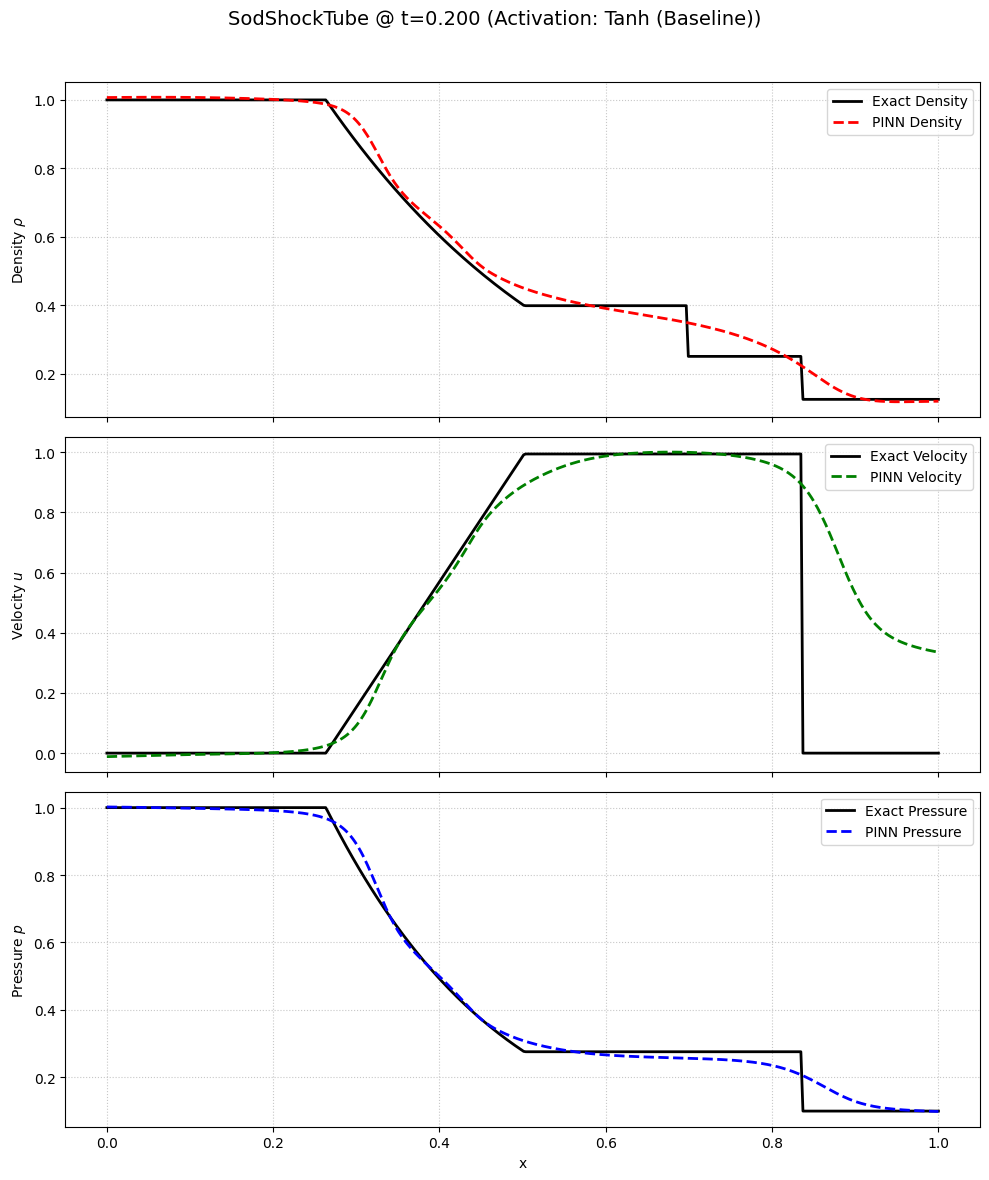

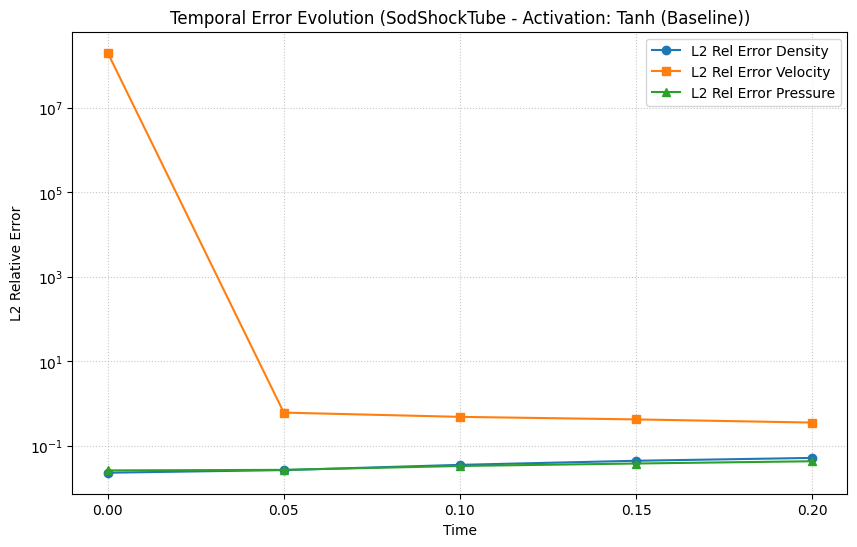


--- Running Experiment for Activation: LeakyReLU (Default) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 5.9941e+02 (PDE_M: 2.71e-07, PDE_Mom: 3.25e-04, PDE_E: 1.14e-04, IC: 1.20e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 1.5917e+01 (PDE_M: 2.26e-02, PDE_Mom: 5.29e+00, PDE_E: 1.78e-01, IC: 2.09e-02), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 1.5136e+01 (PDE_M: 2.78e-02, PDE_Mom: 4.85e+00, PDE_E: 2.09e-01, IC: 2.01e-02), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 8.9529e+00 (PDE_M: 2.21e-01, PDE_Mom: 1.60e+00, PDE_E: 3.28e-01, IC: 1.36e-02), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.6026e+00 (PDE_M: 8.87e-02, PDE_Mom: 1.29e-01, PDE_E: 3.26e-01, IC: 4.12e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 2.3359e+00 (PDE_M: 9.20e-02, PDE_Mom: 1.13e-01, PDE_E: 1.96e-01, IC: 3.87e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.02e-01/1.01e+00), u(-2.48e-04/1.12e+00), p(8.53e-02/1.00e+00)
Epoch 7200/

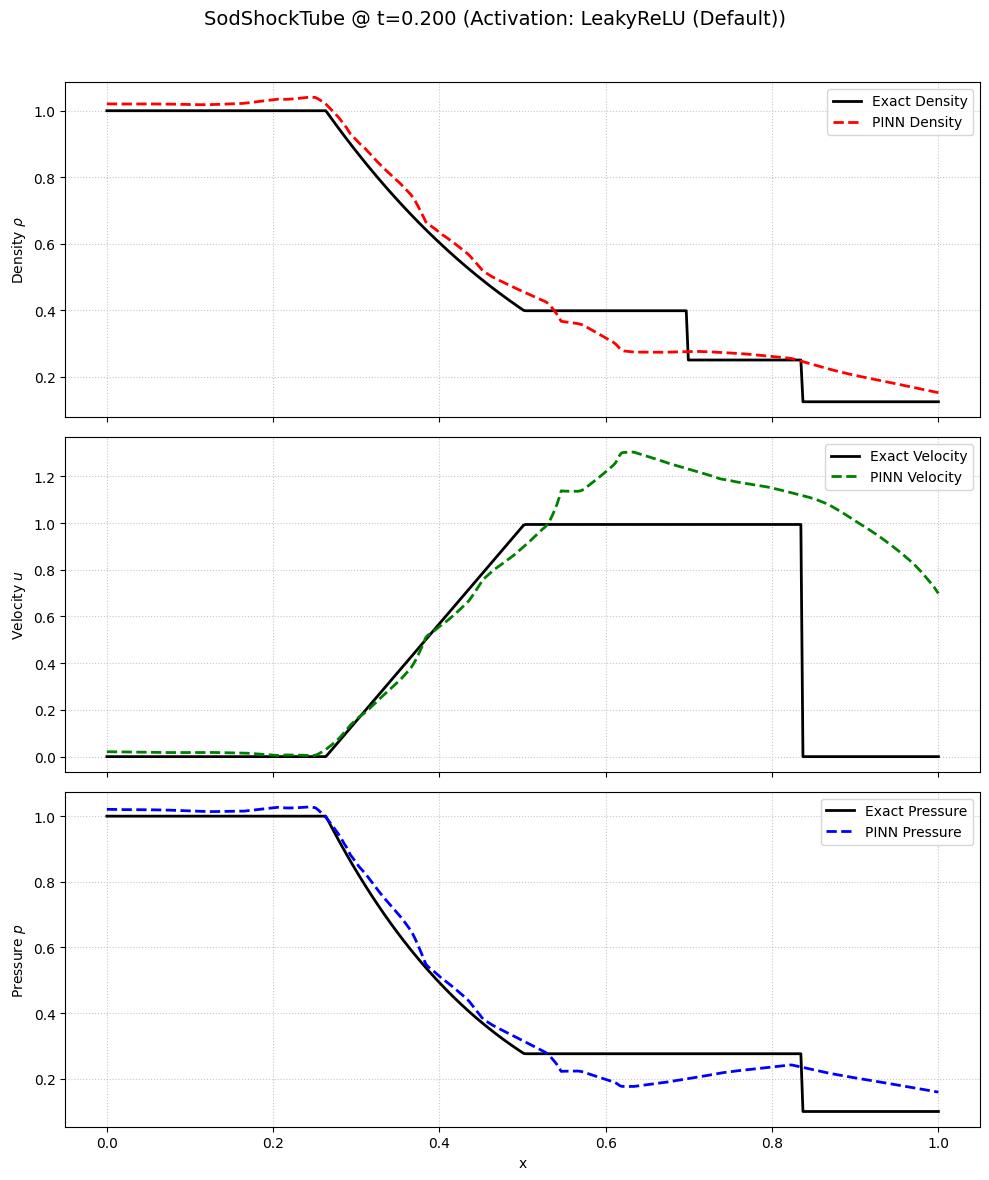

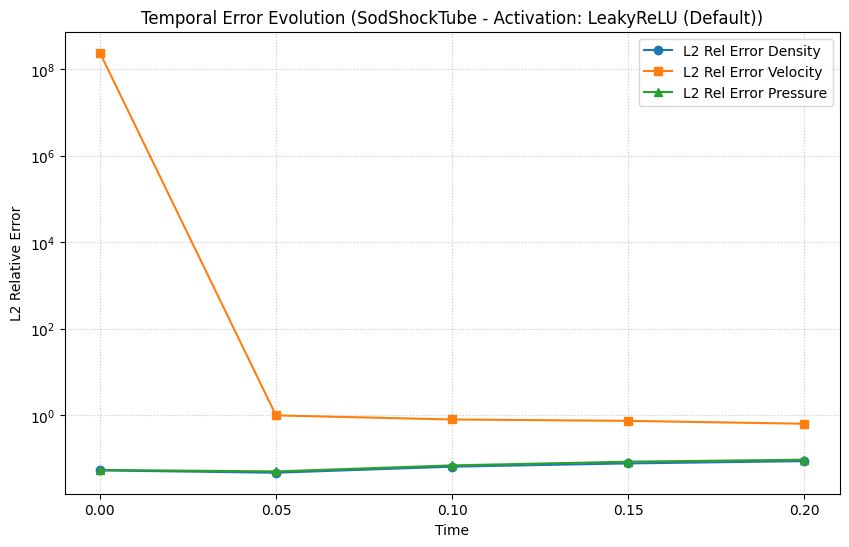


--- Running Experiment for Activation: Sigmoid ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 4.7779e+02 (PDE_M: 8.86e-13, PDE_Mom: 2.15e-13, PDE_E: 2.08e-11, IC: 9.56e-01), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 1.3336e+01 (PDE_M: 3.79e-01, PDE_Mom: 5.13e+00, PDE_E: 1.26e-01, IC: 1.54e-02), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 1.0731e+01 (PDE_M: 1.40e+00, PDE_Mom: 2.58e+00, PDE_E: 1.57e-01, IC: 1.32e-02), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 1.1226e+01 (PDE_M: 1.24e+00, PDE_Mom: 3.28e+00, PDE_E: 3.52e-01, IC: 1.27e-02), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 1.2441e+01 (PDE_M: 9.42e-01, PDE_Mom: 2.83e+00, PDE_E: 2.15e-01, IC: 1.69e-02), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 1.8714e+01 (PDE_M: 2.39e-01, PDE_Mom: 2.97e+00, PDE_E: 1.64e-01, IC: 3.07e-02), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.65e-02/1.03e+00), u(-3.81e+00/8.16e-02), p(1.14e-03/1.01e+00)
Epoch 7200/30000 -> Los

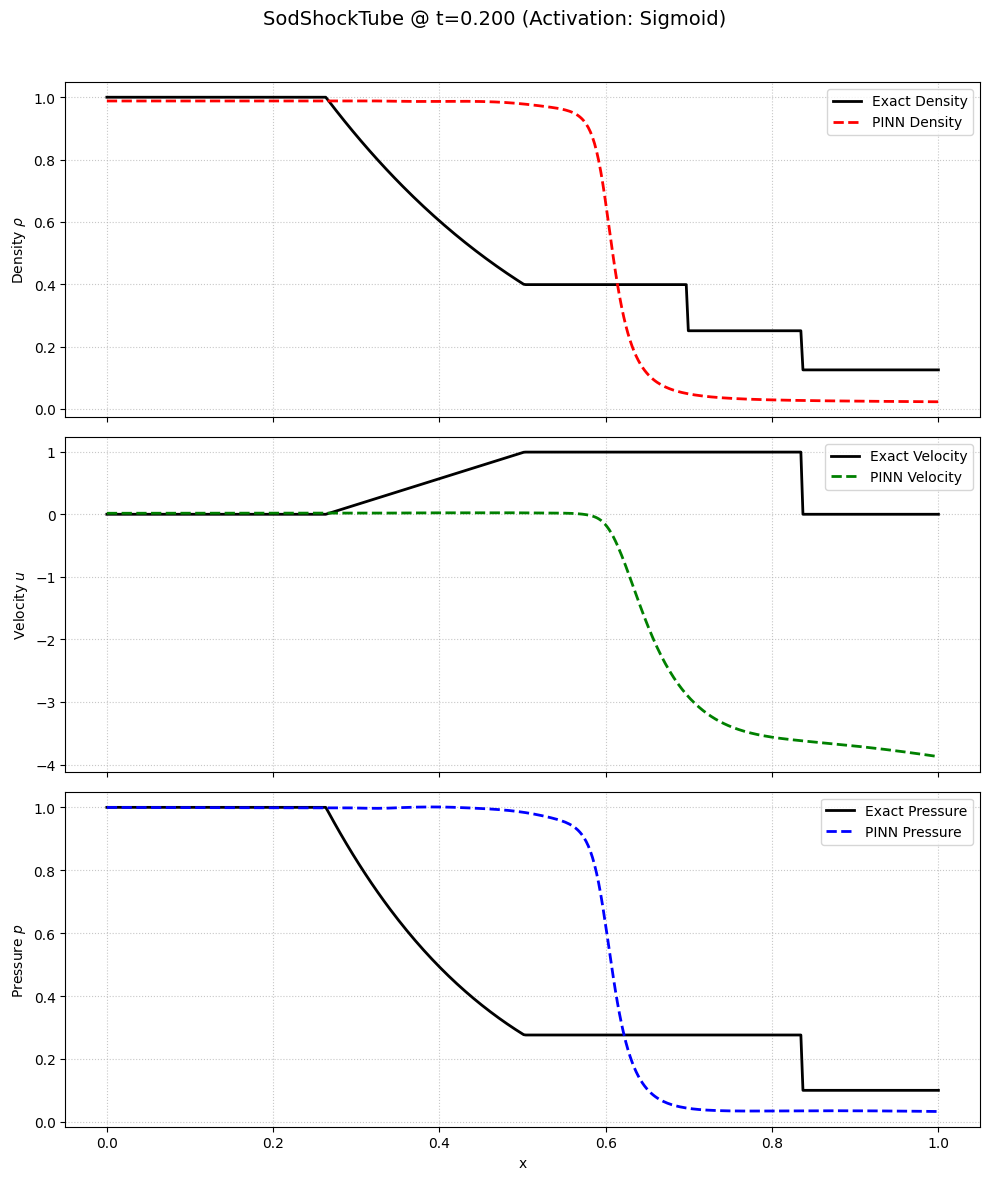

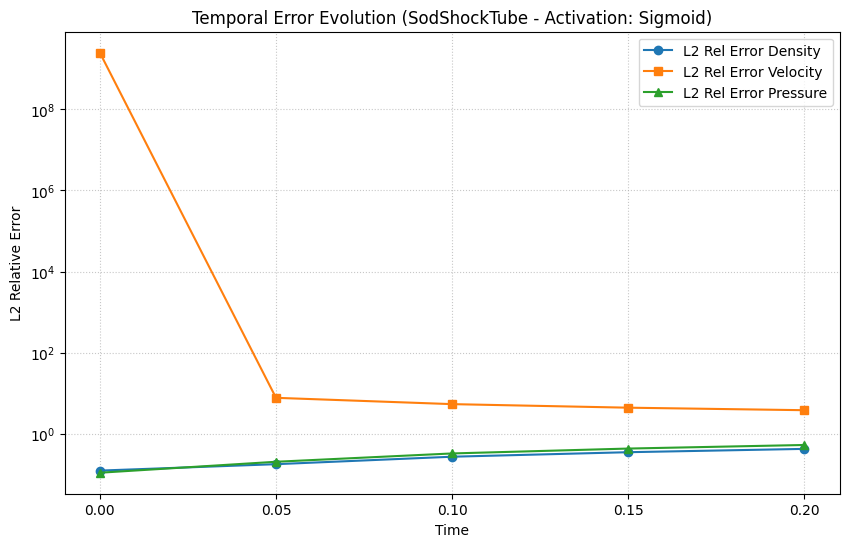


--- Running Experiment for Activation: Gaussian (alpha=5 Fixed) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 6.1738e+02 (PDE_M: 1.82e-02, PDE_Mom: 4.08e-01, PDE_E: 8.17e-03, IC: 1.23e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 4.3124e+00 (PDE_M: 5.91e-02, PDE_Mom: 8.82e-02, PDE_E: 1.29e-01, IC: 8.07e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.4289e+00 (PDE_M: 3.79e-02, PDE_Mom: 5.48e-02, PDE_E: 5.68e-02, IC: 6.56e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.8958e+00 (PDE_M: 4.61e-02, PDE_Mom: 3.66e-02, PDE_E: 5.29e-02, IC: 5.52e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.6139e+00 (PDE_M: 4.69e-02, PDE_Mom: 9.15e-02, PDE_E: 4.58e-02, IC: 4.86e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 3.6287e+00 (PDE_M: 1.40e-01, PDE_Mom: 4.00e-01, PDE_E: 8.64e-01, IC: 4.45e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(8.45e-02/1.01e+00), u(-4.08e-02/9.78e-01), p(9.07e-02/1.01e+00)
Epoch 

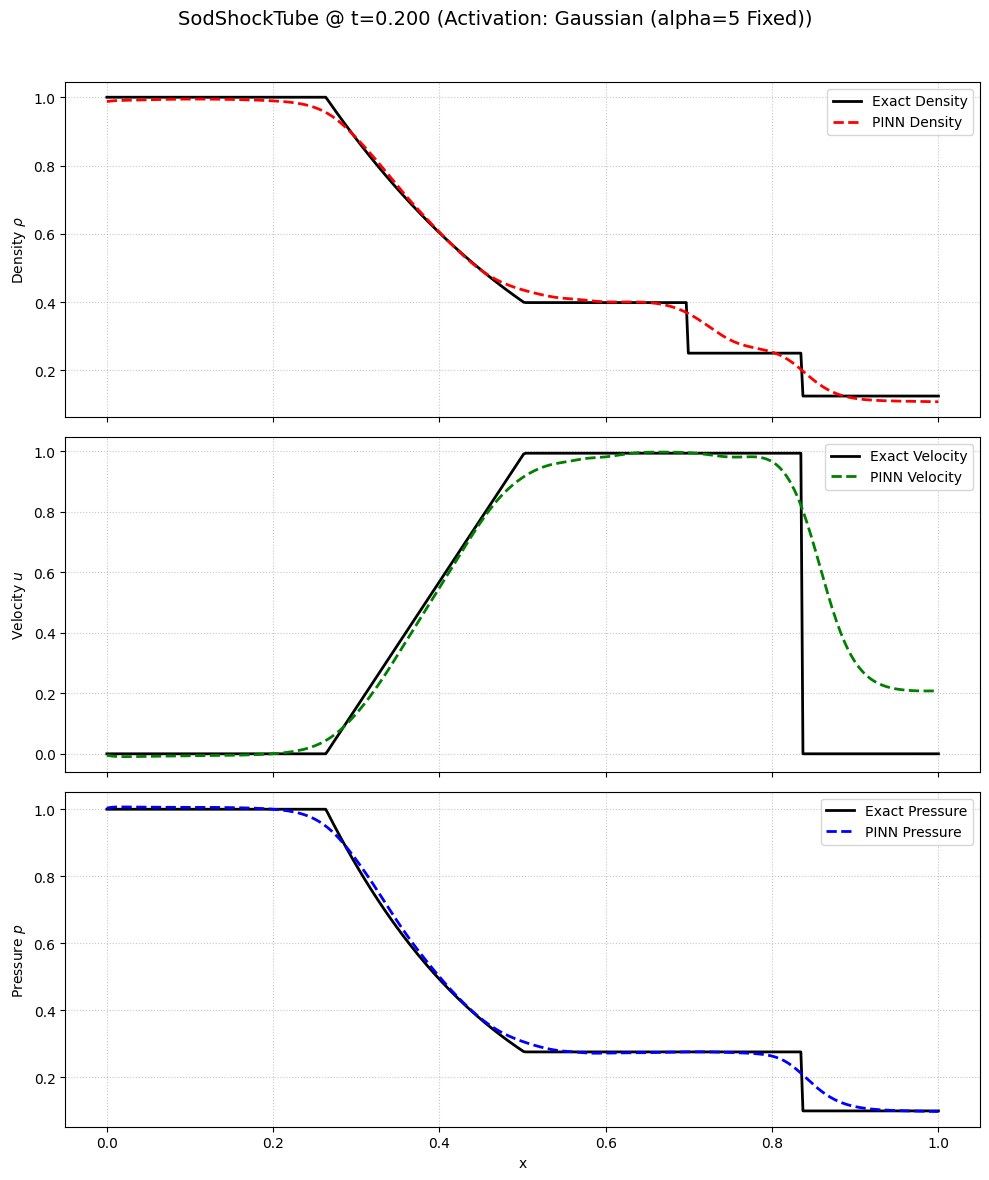

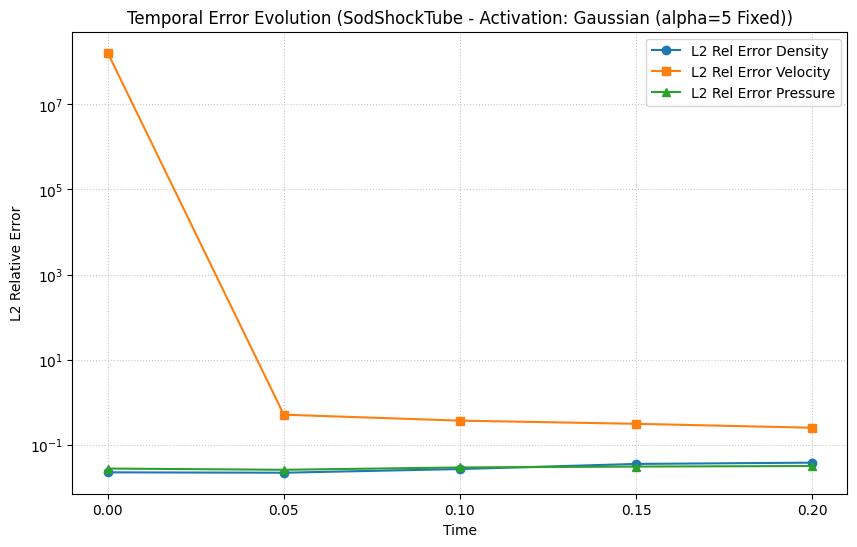


--- Running Experiment for Activation: Gaussian (alpha Learn, init=5) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 1.1257e+03 (PDE_M: 2.18e-03, PDE_Mom: 4.03e+00, PDE_E: 3.90e+00, IC: 2.24e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 3.0836e+00 (PDE_M: 3.63e-02, PDE_Mom: 6.17e-02, PDE_E: 7.92e-02, IC: 5.81e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.1537e+00 (PDE_M: 2.78e-02, PDE_Mom: 5.62e-02, PDE_E: 9.01e-02, IC: 5.96e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 3.1778e+00 (PDE_M: 1.03e-01, PDE_Mom: 8.66e-02, PDE_E: 3.10e-01, IC: 5.36e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.1553e+00 (PDE_M: 2.36e-02, PDE_Mom: 5.87e-02, PDE_E: 5.81e-02, IC: 4.03e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 2.2708e+00 (PDE_M: 9.32e-02, PDE_Mom: 7.24e-02, PDE_E: 1.19e-01, IC: 3.97e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.32e-01/1.01e+00), u(-8.29e-03/1.03e+00), p(1.09e-01/1.02e+00)


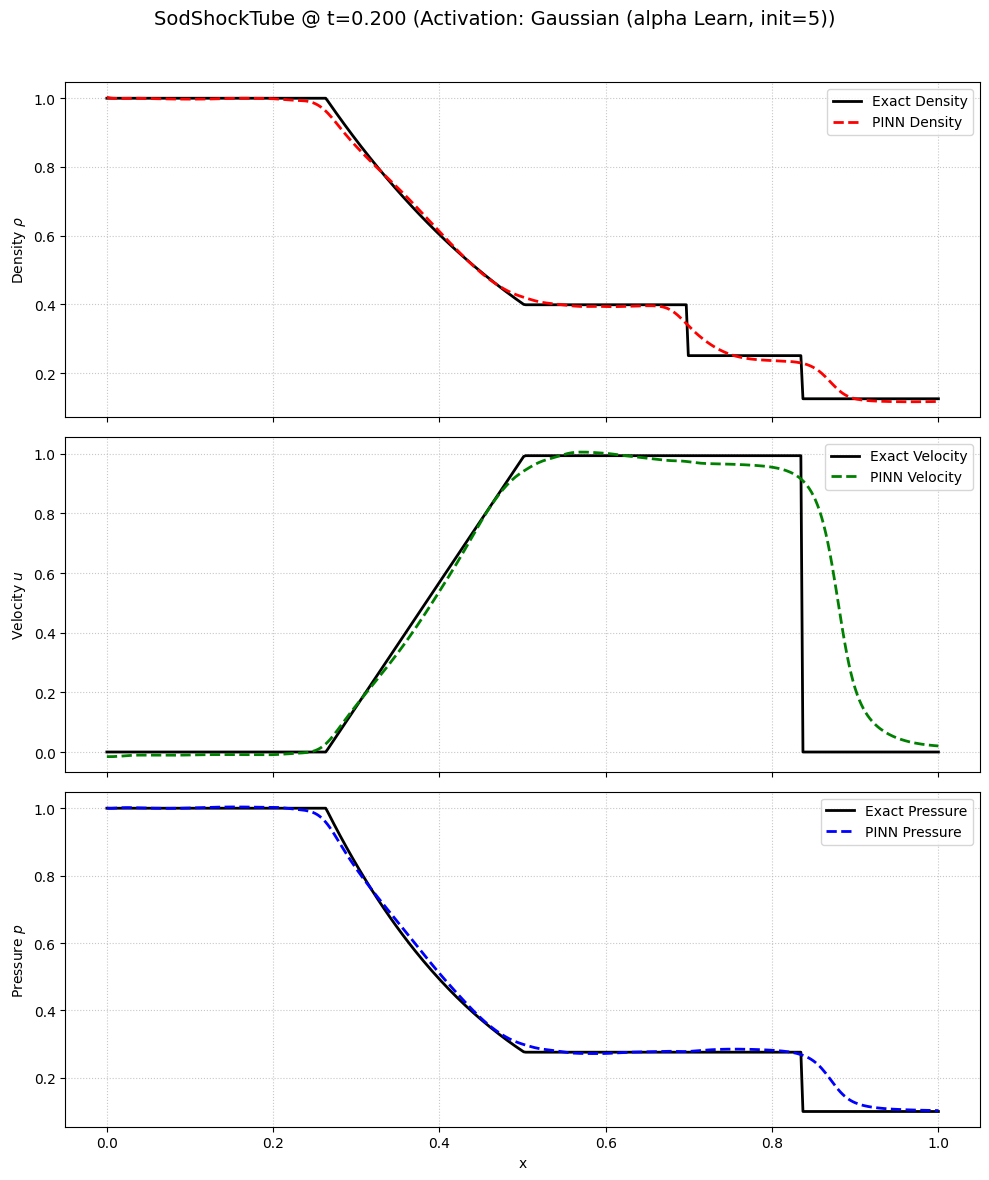

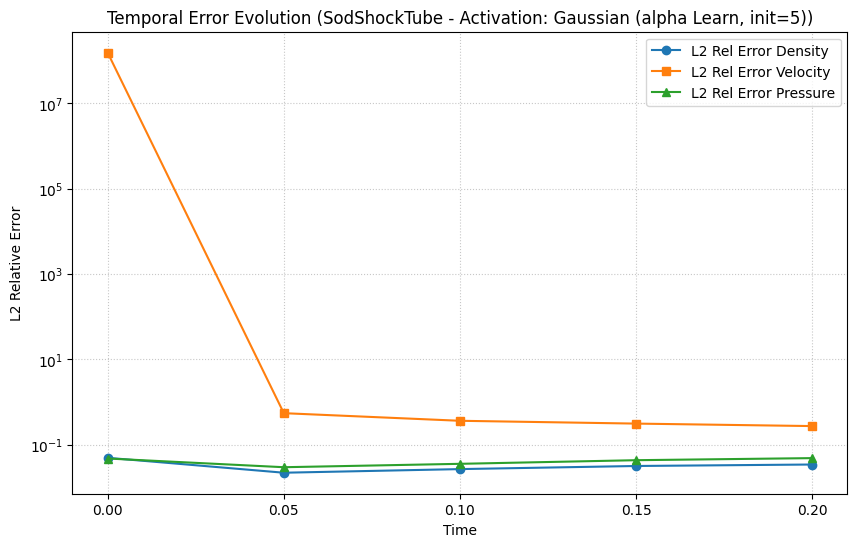

  Final learnable alpha (for Gaussian (alpha Learn, init=5)): 5.8969

--- Running Experiment for Activation: MexicanHat (s=1 Fixed) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 1.5070e+13 (PDE_M: 2.44e-05, PDE_Mom: 8.62e+12, PDE_E: 6.45e+12, IC: 2.51e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 3.9578e+00 (PDE_M: 6.14e-02, PDE_Mom: 1.87e-01, PDE_E: 5.30e-02, IC: 7.31e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.1463e+00 (PDE_M: 5.40e-02, PDE_Mom: 1.16e-01, PDE_E: 2.05e-01, IC: 5.54e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.5011e+00 (PDE_M: 4.81e-02, PDE_Mom: 1.31e-01, PDE_E: 7.65e-02, IC: 4.49e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 3.0250e+00 (PDE_M: 2.90e-02, PDE_Mom: 9.85e-02, PDE_E: 1.41e-01, IC: 5.51e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 1.8998e+00 (PDE_M: 2.99e-02, PDE_Mom: 4.32e-02, PDE_E: 2.92e-02, IC: 3.60e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(9.9

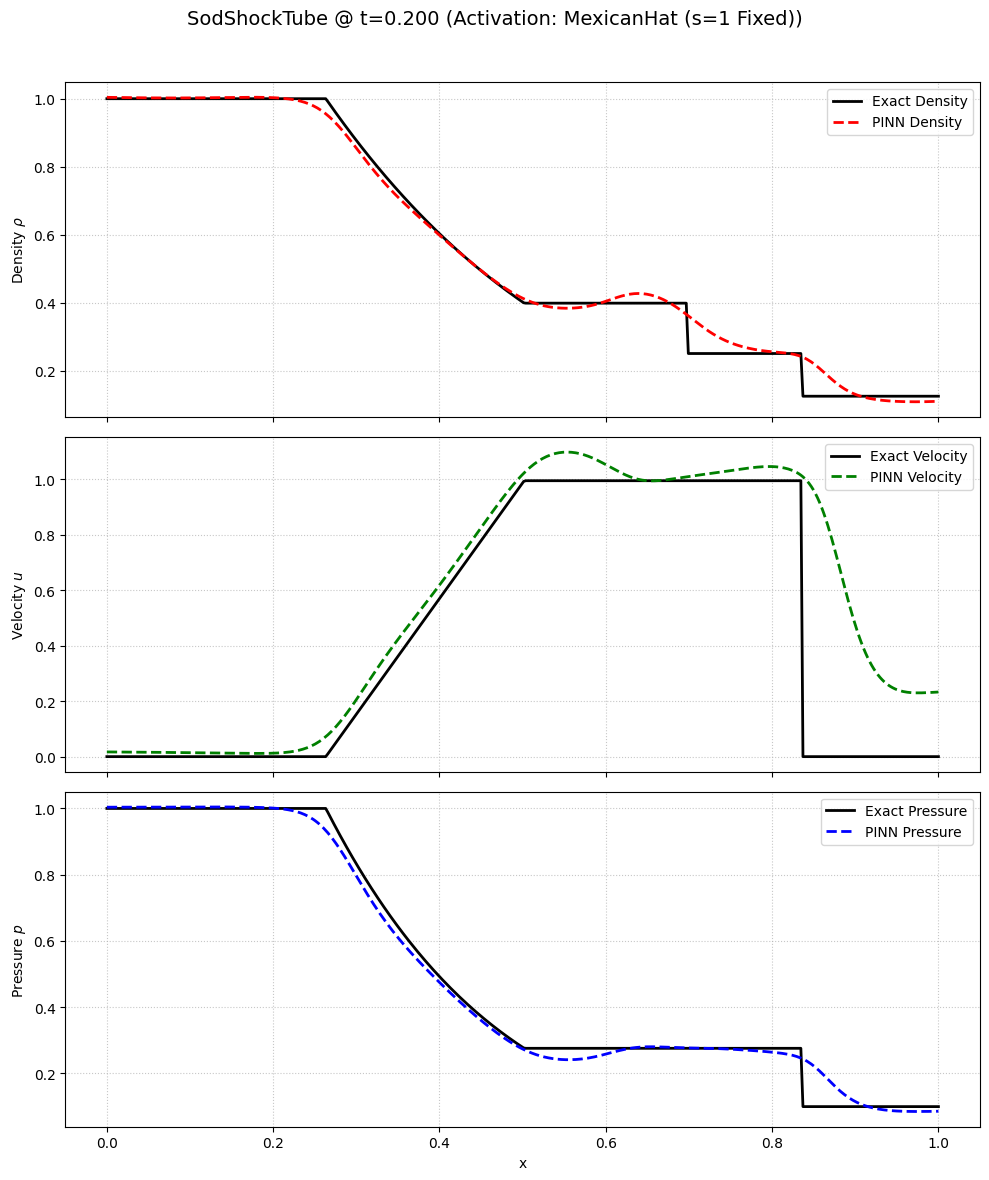

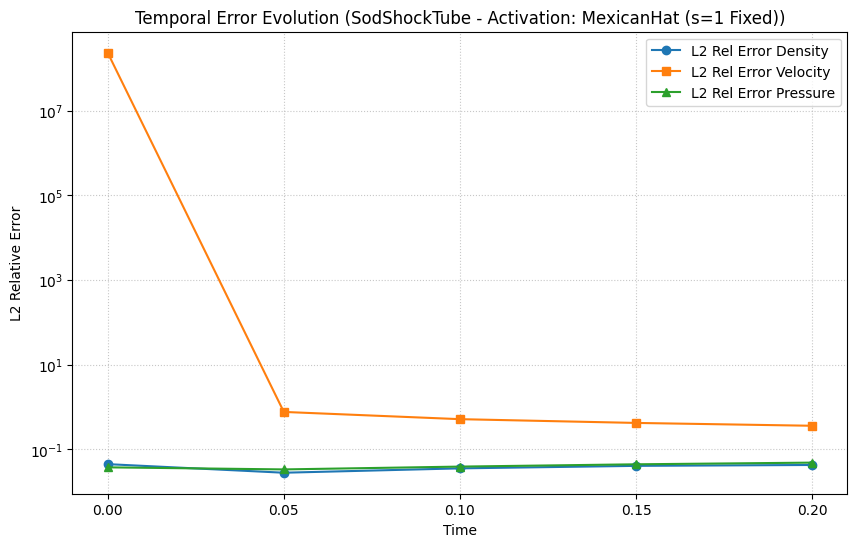


--- Running Experiment for Activation: MexHat (s Learn, init=1, L8_U192) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=8, Units=192
Epoch 0/30000 -> Loss: 4.4678e+02 (PDE_M: 5.02e-06, PDE_Mom: 2.17e-05, PDE_E: 1.16e-05, IC: 8.94e-01), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 4.6395e+00 (PDE_M: 9.16e-02, PDE_Mom: 4.17e-01, PDE_E: 1.20e-01, IC: 8.02e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.4282e+00 (PDE_M: 3.63e-02, PDE_Mom: 1.07e-01, PDE_E: 1.14e-01, IC: 6.34e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 1.5083e+00 (PDE_M: 2.23e-02, PDE_Mom: 2.08e-01, PDE_E: 1.80e-01, IC: 2.20e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 3.4036e+00 (PDE_M: 8.13e-02, PDE_Mom: 8.58e-02, PDE_E: 2.36e-01, IC: 6.00e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 1.1706e+00 (PDE_M: 5.89e-02, PDE_Mom: 2.26e-01, PDE_E: 1.51e-01, IC: 1.47e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.08e-01/1.00e+00), u(-2.36e-02/1.03e+00), p(1.00e-01/1.00e+0

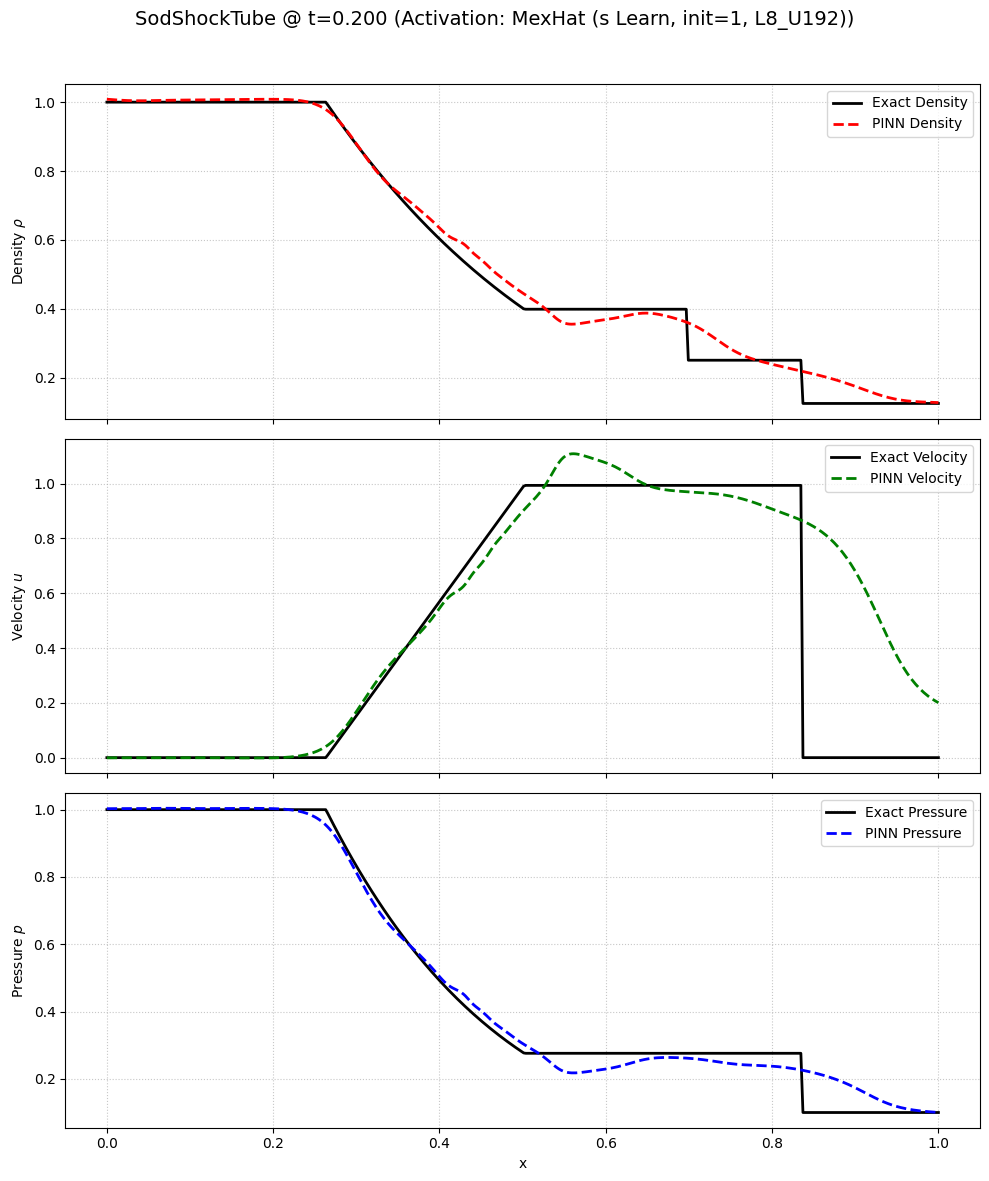

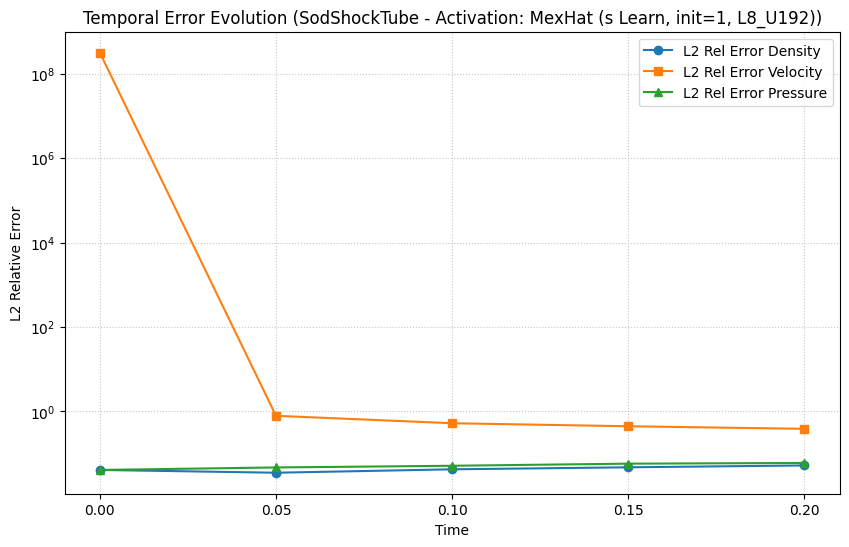

  Final learnable sigma (for MexHat (s Learn, init=1, L8_U192)): 0.8111

--- Running Experiment for Activation: Morlet (s0.7,w5 Fixed) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 3.0303e+20 (PDE_M: 1.34e+03, PDE_Mom: 2.09e+20, PDE_E: 9.42e+19, IC: 1.22e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 6.4232e+00 (PDE_M: 3.40e-01, PDE_Mom: 8.50e-01, PDE_E: 2.04e+00, IC: 6.38e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.9129e+00 (PDE_M: 3.35e-01, PDE_Mom: 3.56e-01, PDE_E: 1.48e+00, IC: 3.48e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.1358e+00 (PDE_M: 2.53e-01, PDE_Mom: 2.28e-01, PDE_E: 5.40e-01, IC: 2.23e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 5.2638e+00 (PDE_M: 2.29e-01, PDE_Mom: 1.33e-01, PDE_E: 4.80e-01, IC: 8.84e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 3.3641e+00 (PDE_M: 9.67e-02, PDE_Mom: 1.65e-01, PDE_E: 4.27e-01, IC: 5.35e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(

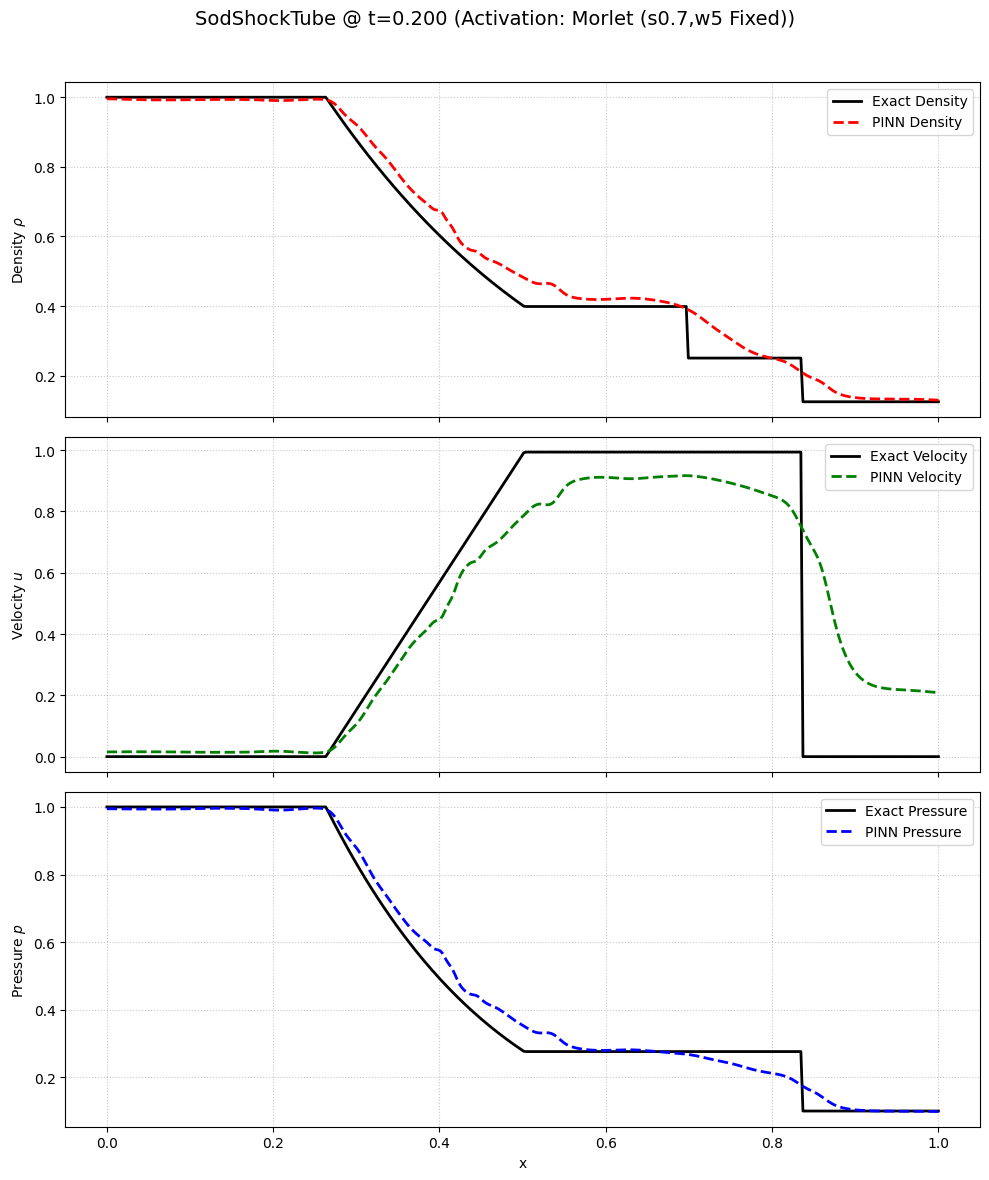

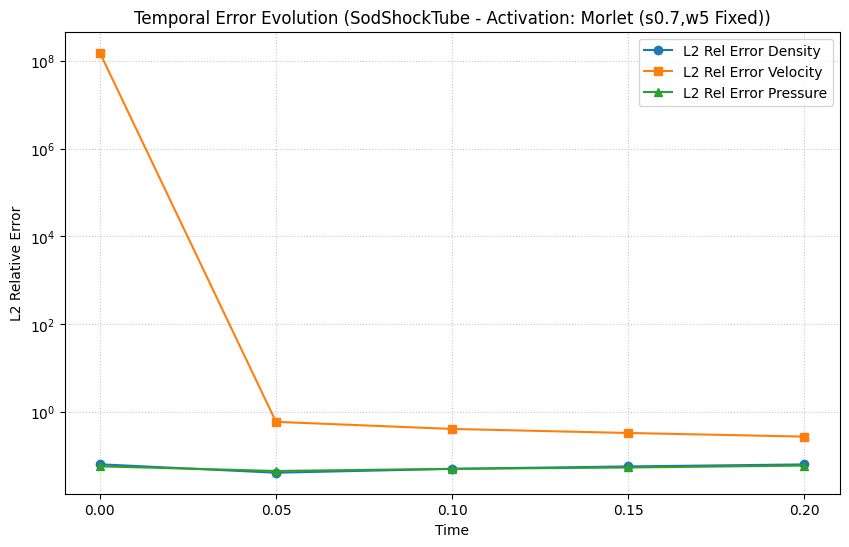


--- Running Experiment for Activation: Morlet (s,w0 Learn, init s0.7,w5) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 1.9622e+20 (PDE_M: 1.14e+03, PDE_Mom: 1.27e+20, PDE_E: 6.89e+19, IC: 1.17e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 6.1547e+00 (PDE_M: 2.56e-01, PDE_Mom: 2.17e+00, PDE_E: 1.68e+00, IC: 4.09e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 2.2871e+00 (PDE_M: 1.62e-01, PDE_Mom: 2.15e-01, PDE_E: 6.17e-01, IC: 2.59e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 6.3870e+00 (PDE_M: 2.99e-01, PDE_Mom: 5.47e-01, PDE_E: 9.79e-01, IC: 9.12e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 1.4056e+00 (PDE_M: 8.18e-02, PDE_Mom: 2.13e-01, PDE_E: 2.57e-01, IC: 1.71e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 5.0681e+00 (PDE_M: 1.90e-01, PDE_Mom: 5.21e-01, PDE_E: 1.82e+00, IC: 5.07e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.27e-01/1.02e+00), u(-1.10e-02/9.19e-01), p(9.93e-02/1.00e+0

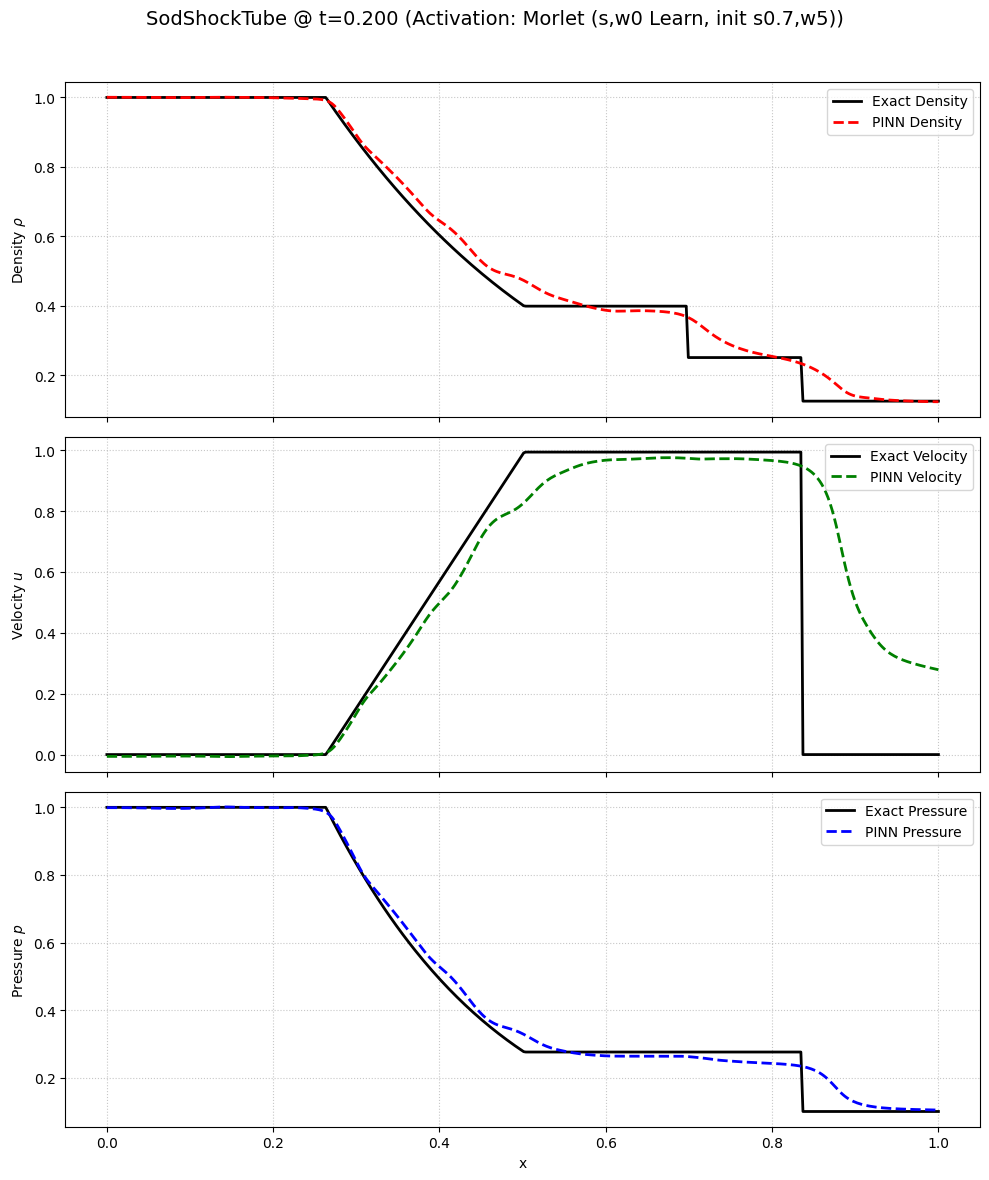

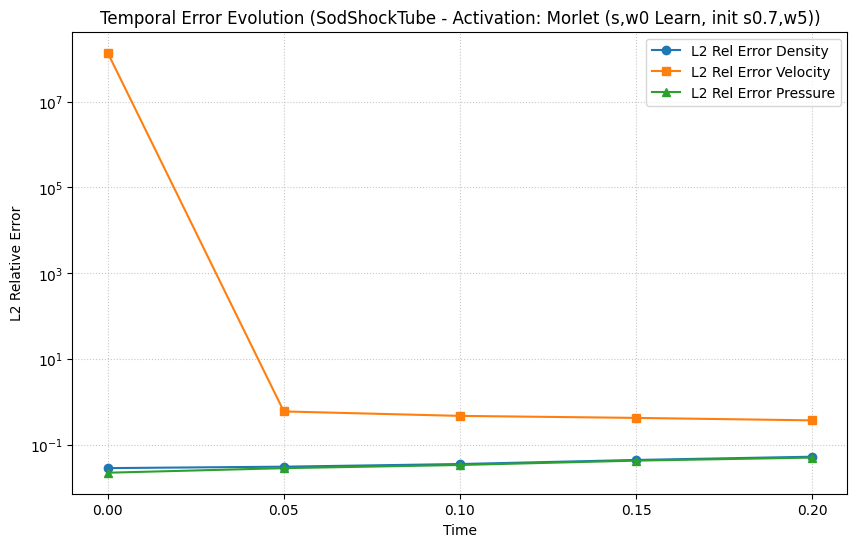

  Final learnable sigma (for Morlet (s,w0 Learn, init s0.7,w5)): 0.2466
  Final learnable omega0 (for Morlet (s,w0 Learn, init s0.7,w5)): 4.2359

--- Running Experiment for Activation: Morlet (s0.7,w5 Fixed, MomW=10) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,10.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 5.6604e+20 (PDE_M: 1.24e+03, PDE_Mom: 5.28e+19, PDE_E: 3.81e+19, IC: 1.21e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 8.0248e+00 (PDE_M: 2.77e-01, PDE_Mom: 3.36e-01, PDE_E: 1.18e+00, IC: 6.40e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 7.2761e+00 (PDE_M: 1.66e-01, PDE_Mom: 3.84e-01, PDE_E: 1.11e+00, IC: 4.32e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 1.4819e+00 (PDE_M: 1.35e-01, PDE_Mom: 3.35e-02, PDE_E: 2.34e-01, IC: 1.55e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 6.9763e+00 (PDE_M: 2.74e-01, PDE_Mom: 8.97e-02, PDE_E: 7.27e-01, IC: 1.02e-02), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 3.1425e+00 (PDE_M: 1.71e-01, PDE_Mom: 8.63e-02, PD

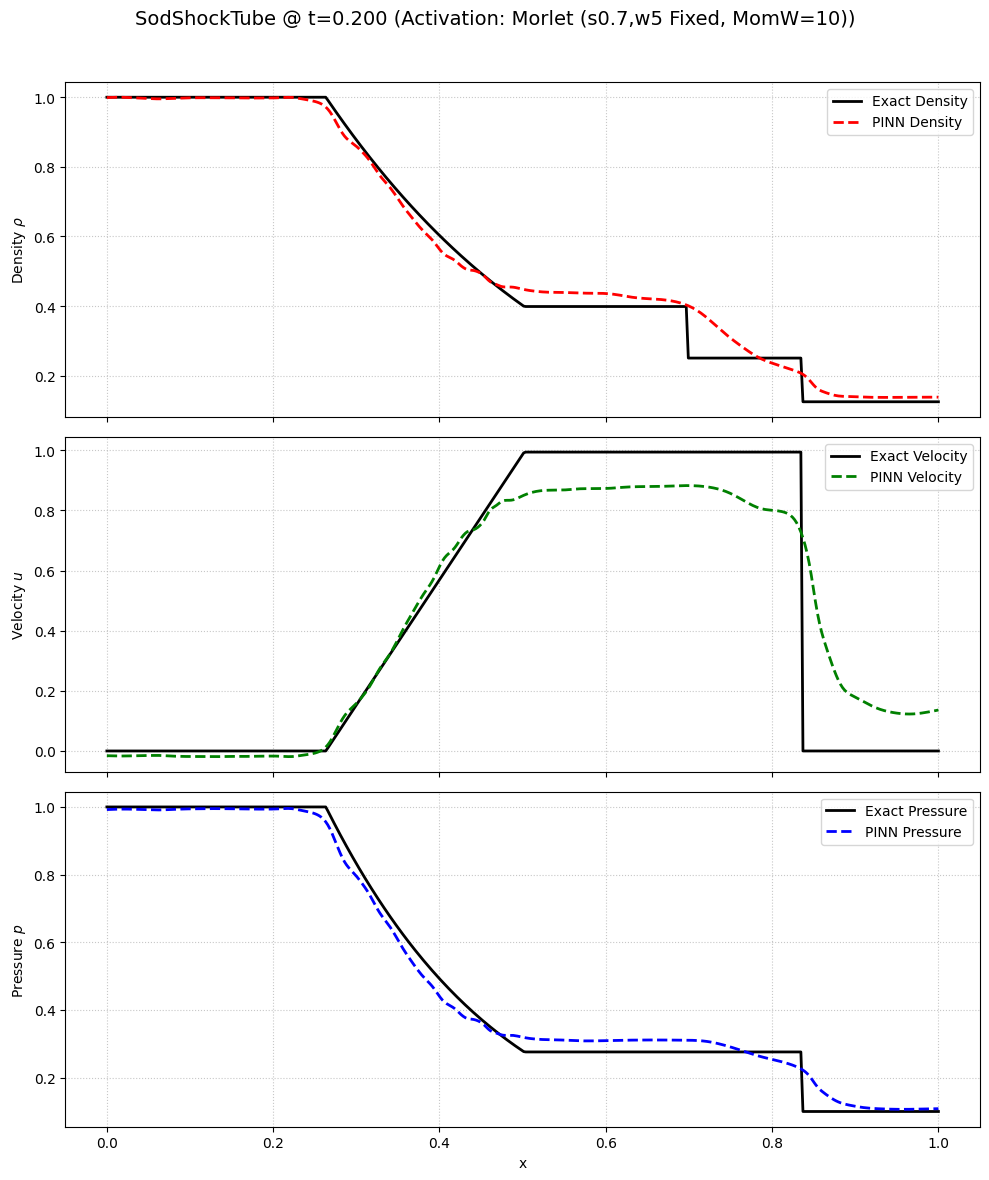

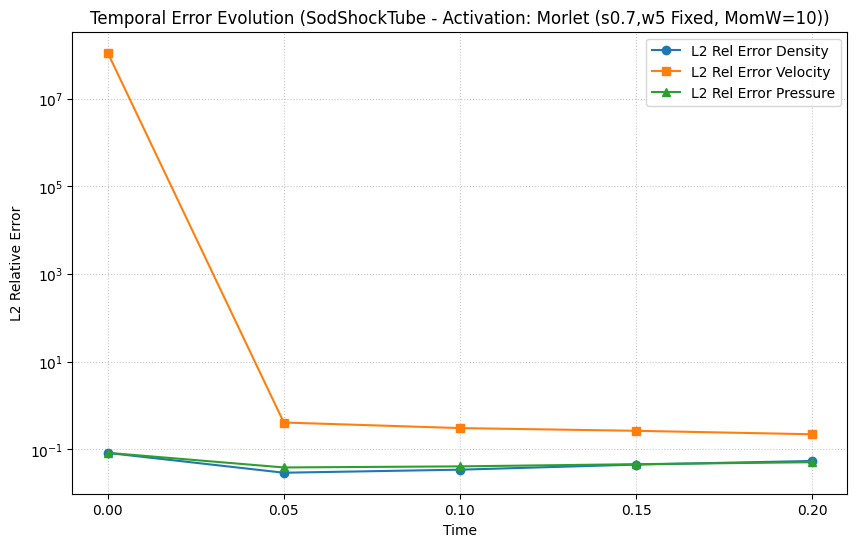


--- Running Experiment for Activation: MexHat (s L, init=1, L8U192, MomW=10) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,10.0,1.0), Clip=1.0, Layers=8, Units=192
Epoch 0/30000 -> Loss: 6.3341e+12 (PDE_M: 3.04e-06, PDE_Mom: 2.66e+11, PDE_E: 3.67e+12, IC: 2.43e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 3.3590e+01 (PDE_M: 4.01e-02, PDE_Mom: 6.17e-01, PDE_E: 6.44e-01, IC: 5.35e-02), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 4.5403e+00 (PDE_M: 1.22e-01, PDE_Mom: 1.04e-01, PDE_E: 1.79e-01, IC: 6.40e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.3508e+00 (PDE_M: 1.03e-01, PDE_Mom: 1.61e-02, PDE_E: 8.45e-02, IC: 4.00e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 4.5735e+00 (PDE_M: 1.68e-01, PDE_Mom: 1.72e-01, PDE_E: 6.13e-01, IC: 4.15e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 2.9348e+00 (PDE_M: 1.11e-01, PDE_Mom: 2.40e-02, PDE_E: 4.08e-01, IC: 4.35e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(9.63e-02/9.88e-01), u(8.74e-03/1.04e+00), p(9.48e-02/9.9

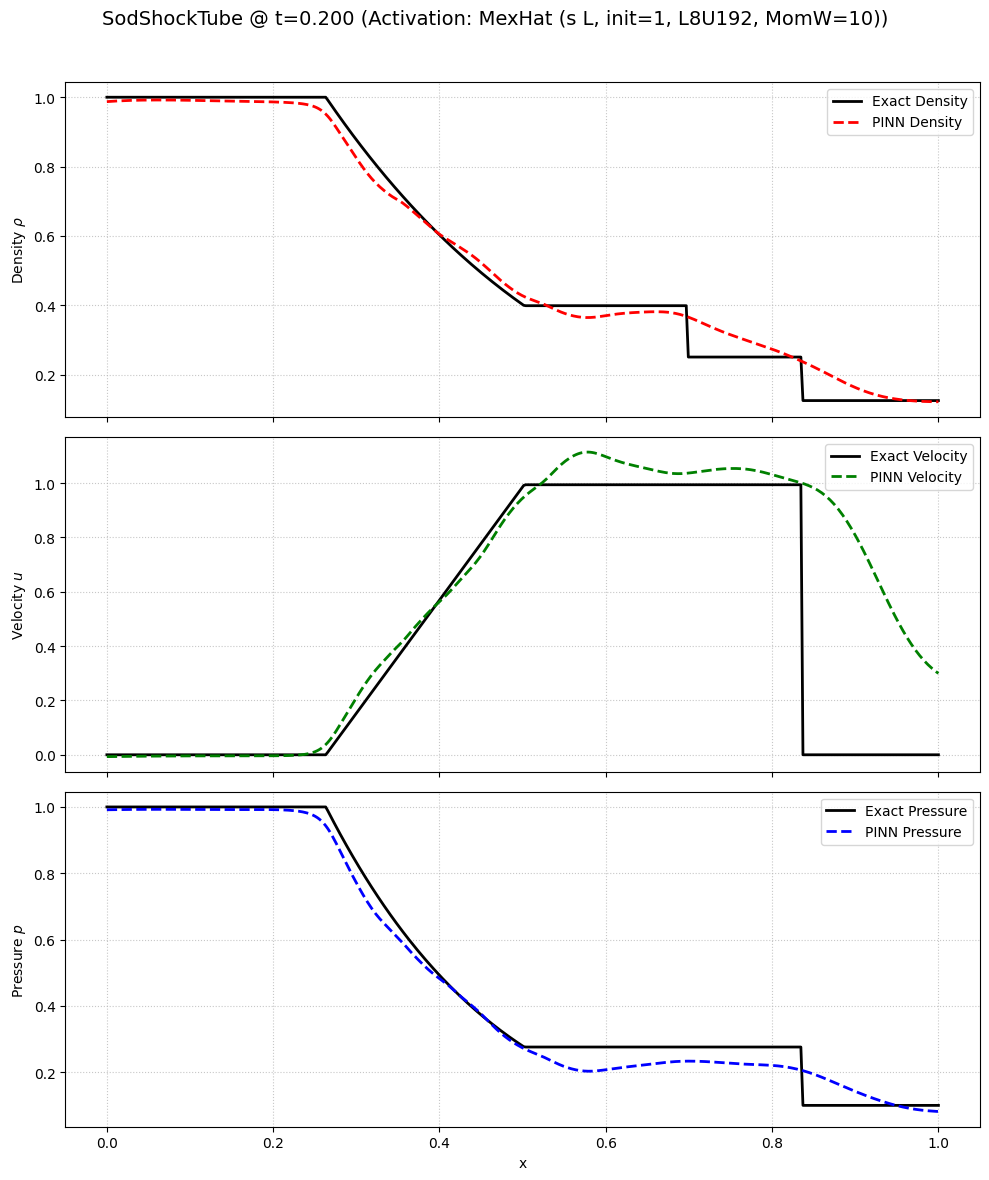

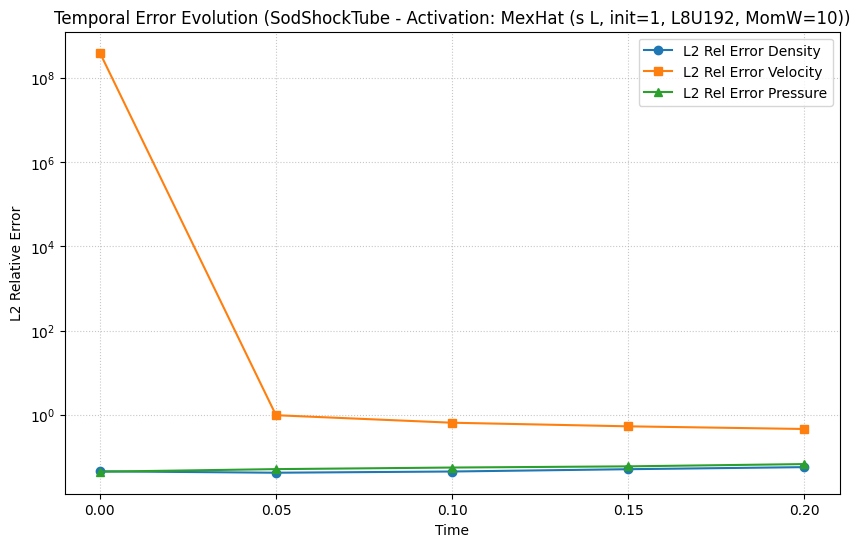

  Final learnable sigma (for MexHat (s L, init=1, L8U192, MomW=10)): 0.7936


--- Overall Comparison Summary (Errors at t_final) ---
Activation Config                                  | Rho L1  | Rho L2  | U L1    | U L2    | P L1    | P L2    | Time (s)
-------------------------------------------------------------------------------------------------------------------------
Tanh (Baseline)                                    | 4.35e-02 | 5.18e-02 | 2.30e-01 | 3.55e-01 | 3.47e-02 | 4.32e-02 | 535.76
LeakyReLU (Default)                                | 8.25e-02 | 8.71e-02 | 5.15e-01 | 6.38e-01 | 9.46e-02 | 9.40e-02 | 507.86
Sigmoid                                            | 3.64e-01 | 4.23e-01 | 3.77e+00 | 3.80e+00 | 4.41e-01 | 5.28e-01 | 544.11
Gaussian (alpha=5 Fixed)                           | 2.83e-02 | 3.81e-02 | 1.62e-01 | 2.52e-01 | 2.21e-02 | 3.17e-02 | 762.03
Gaussian (alpha Learn, init=5)                     | 2.19e-02 | 3.40e-02 | 1.36e-01 | 2.71e-01 | 2.57e-02 | 4.81e-02 | 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import brentq # For the Riemann solver root finding

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GAMMA = 1.4  # Ratio of specific heats
print(f"Using device: {DEVICE}")

# --- 1. Euler Equations & Riemann Problem Utilities ---
def primitive_to_conserved(rho, u, p):
    rho = torch.as_tensor(rho, dtype=torch.float32, device=DEVICE)
    u = torch.as_tensor(u, dtype=torch.float32, device=DEVICE)
    p = torch.as_tensor(p, dtype=torch.float32, device=DEVICE)
    E_internal = p / ((GAMMA - 1.0) * rho.clamp(min=1e-9))
    E_total = rho * (E_internal + 0.5 * u**2)
    return torch.stack([rho, rho * u, E_total], dim=-1)

def conserved_to_primitive(Q_conserved):
    rho = Q_conserved[..., 0:1].clamp(min=1e-9)
    rhou = Q_conserved[..., 1:2]
    E_total_conserved = Q_conserved[..., 2:3]
    u = rhou / rho 
    pressure_val = (E_total_conserved - 0.5 * rhou**2 / rho) * (GAMMA - 1.0)
    p = pressure_val.clamp(min=1e-9)
    return rho, u, p

def euler_fluxes_conserved(Q_conserved):
    rho, u, p = conserved_to_primitive(Q_conserved)
    F_component_0 = Q_conserved[..., 1:2]
    F_component_1 = Q_conserved[..., 1:2] * u + p
    F_component_2 = (Q_conserved[..., 2:3] + p) * u
    return torch.cat([F_component_0, F_component_1, F_component_2], dim=-1)

# --- Initial Conditions (Sod Shock Tube) ---
DIAPHRAGM_LOCATION = 0.5
def get_sod_initial_conditions(x_coords): 
    rho_ic = torch.where(x_coords < DIAPHRAGM_LOCATION, torch.tensor(1.0), torch.tensor(0.125)).to(DEVICE)
    p_ic = torch.where(x_coords < DIAPHRAGM_LOCATION, torch.tensor(1.0), torch.tensor(0.1)).to(DEVICE)
    u_ic = torch.zeros_like(x_coords).to(DEVICE)
    return primitive_to_conserved(rho_ic, u_ic, p_ic)

# --- Exact Riemann Solver for Sod Problem (Ground Truth) ---
def exact_sod_solver(x_np, t_val):
    rho_L, u_L, p_L = 1.0, 0.0, 1.0
    rho_R, u_R, p_R = 0.125, 0.0, 0.1
    
    if abs(t_val) < 1e-9: 
        rho = np.where(x_np < DIAPHRAGM_LOCATION, rho_L, rho_R)
        u = np.where(x_np < DIAPHRAGM_LOCATION, u_L, u_R)
        p = np.where(x_np < DIAPHRAGM_LOCATION, p_L, p_R)
        return rho, u, p

    a_L = np.sqrt(GAMMA * p_L / rho_L)
    a_R = np.sqrt(GAMMA * p_R / rho_R)

    def F_k(P_star_func, P_k_func, RHO_k_func, A_k_func):
        if P_star_func > P_k_func:
            den_shock = RHO_k_func * ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star_func + (GAMMA - 1.0) / (2.0 * GAMMA) * P_k_func )
            return (P_star_func - P_k_func) / np.sqrt(max(1e-12, den_shock))
        else:
            pressure_ratio_clipped = max(1e-12, P_star_func / P_k_func)
            return (2.0 * A_k_func / (GAMMA - 1.0)) * ( pressure_ratio_clipped**((GAMMA - 1.0) / (2.0 * GAMMA)) - 1.0 )

    def pressure_function_for_root(P_star_guess_func):
        return F_k(P_star_guess_func, p_L, rho_L, a_L) + F_k(P_star_guess_func, p_R, rho_R, a_R) - (u_L - u_R)

    p_min_search = 1e-7 
    p_max_search = max(p_L, p_R) * 50.0 
    P_star = 0.30313 
    try:
        P_star = brentq(pressure_function_for_root, p_min_search, p_max_search, xtol=1e-12, rtol=1e-12)
    except (ValueError, RuntimeError) as e:
        print(f"Warning: Root finding for P_star failed or did not converge. Error: {e}. Using approximate P_star={P_star} for Sod.")

    U_star = 0.5 * (u_L + u_R) + 0.5 * (F_k(P_star, p_R, rho_R, a_R) - F_k(P_star, p_L, rho_L, a_L))

    if P_star > p_L:
        rho_star_L = rho_L * ( (P_star / p_L + (GAMMA - 1.0) / (GAMMA + 1.0)) / \
                               ( max(1e-12, (GAMMA - 1.0) / (GAMMA + 1.0) * P_star / p_L + 1.0)) )
    else:
        rho_star_L = rho_L * max(1e-12, P_star / p_L)**(1.0 / GAMMA)

    if P_star > p_R:
        rho_star_R = rho_R * ( (P_star / p_R + (GAMMA - 1.0) / (GAMMA + 1.0)) / \
                               ( max(1e-12, (GAMMA - 1.0) / (GAMMA + 1.0) * P_star / p_R + 1.0)) )
    else:
        rho_star_R = rho_R * max(1e-12, P_star / p_R)**(1.0 / GAMMA)
    
    rho_star_L = max(1e-9, rho_star_L) 
    rho_star_R = max(1e-9, rho_star_R) 

    S_contact = U_star 
    
    if P_star > p_L: 
        S_L = u_L - a_L * np.sqrt( max(1e-12, ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star / p_L + (GAMMA - 1.0) / (2.0 * GAMMA) ) ))
    else: 
        a_star_L = np.sqrt(GAMMA * P_star / rho_star_L) 
        S_HL = u_L - a_L 
        S_TL = U_star - a_star_L 

    if P_star > p_R: 
        S_R = u_R + a_R * np.sqrt( max(1e-12, ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star / p_R + (GAMMA - 1.0) / (2.0 * GAMMA) ) ))
    else: 
        a_star_R = np.sqrt(GAMMA * P_star / rho_star_R) 
        S_HR = u_R + a_R 
        S_TR = U_star + a_star_R 
        
    rho_sol = np.zeros_like(x_np)
    u_sol = np.zeros_like(x_np)
    p_sol = np.zeros_like(x_np)

    for i, x_pos in enumerate(x_np):
        s_lambda = (x_pos - DIAPHRAGM_LOCATION) / t_val 
        
        if s_lambda <= S_contact: 
            if P_star > p_L: # Left Shock
                if s_lambda < S_L: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_L, u_L, p_L
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_L, U_star, P_star
            else: # Left Rarefaction
                if s_lambda < S_HL: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_L, u_L, p_L
                elif s_lambda <= S_TL: 
                    u_sol[i] = (2.0 / (GAMMA + 1.0)) * (a_L + (GAMMA - 1.0) / 2.0 * u_L + s_lambda)
                    common_term_L = (2.0 / (GAMMA + 1.0)) + ( (GAMMA - 1.0) / ((GAMMA + 1.0) * a_L) ) * (u_L - s_lambda)
                    rho_sol[i] = rho_L * max(1e-12, common_term_L)**(2.0 / (GAMMA - 1.0))
                    p_sol[i] = p_L * max(1e-12, rho_sol[i] / max(1e-12, rho_L))**GAMMA
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_L, U_star, P_star
        else: 
            if P_star > p_R: # Right Shock
                if s_lambda < S_R: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_R, U_star, P_star
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_R, u_R, p_R
            else: # Right Rarefaction
                if s_lambda <= S_TR: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_R, U_star, P_star
                elif s_lambda < S_HR: 
                    u_sol[i] = (2.0 / (GAMMA + 1.0)) * (-a_R + (GAMMA - 1.0) / 2.0 * u_R + s_lambda)
                    common_term_R = (2.0 / (GAMMA + 1.0)) - ( (GAMMA - 1.0) / ((GAMMA + 1.0) * a_R) ) * (u_R - s_lambda)
                    rho_sol[i] = rho_R * max(1e-12, common_term_R)**(2.0 / (GAMMA - 1.0))
                    p_sol[i] = p_R * max(1e-12, rho_sol[i] / max(1e-12, rho_R))**GAMMA
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_R, u_R, p_R
    return rho_sol, u_sol, p_sol


# --- Wavelet-Inspired Activation Functions (with learnable parameter option) ---
class GaussianActivation(nn.Module):
    def __init__(self, initial_alpha=1.0, learnable=False): 
        super().__init__()
        if learnable:
            self.alpha = nn.Parameter(torch.tensor(float(initial_alpha)))
        else:
            self.alpha_val = initial_alpha 
            self.alpha = None 
    def forward(self, x):
        current_alpha = self.alpha if self.alpha is not None else self.alpha_val
        return torch.exp(-current_alpha * x**2)

class MexicanHatActivation(nn.Module):
    def __init__(self, initial_sigma=1.0, learnable=False): 
        super().__init__()
        if learnable:
            self.sigma = nn.Parameter(torch.tensor(float(initial_sigma)))
        else:
            self.sigma_val = initial_sigma
            self.sigma = None
    def forward(self, x):
        current_sigma = self.sigma if self.sigma is not None else self.sigma_val
        effective_sigma = current_sigma.clamp(min=1e-6) if isinstance(current_sigma, torch.Tensor) else max(1e-6, current_sigma)
        x_scaled = x / effective_sigma
        return (1 - x_scaled**2) * torch.exp(-x_scaled**2 / 2.0)

class MorletActivation(nn.Module):
    def __init__(self, initial_sigma=1.0, initial_omega0=5.0, learnable=False): 
        super().__init__()
        if learnable:
            self.sigma = nn.Parameter(torch.tensor(float(initial_sigma)))
            self.omega0 = nn.Parameter(torch.tensor(float(initial_omega0)))
        else:
            self.sigma_val = initial_sigma
            self.omega0_val = initial_omega0
            self.sigma = None 
            self.omega0 = None 
            
    def forward(self, x):
        current_sigma = self.sigma if self.sigma is not None else self.sigma_val
        current_omega0 = self.omega0 if self.omega0 is not None else self.omega0_val
        
        effective_sigma = current_sigma.clamp(min=1e-6) if isinstance(current_sigma, torch.Tensor) else max(1e-6, current_sigma)
        scaled_x_env = x / effective_sigma
        envelope = torch.exp(-0.5 * scaled_x_env**2)
        carrier = torch.cos(current_omega0 * x) 
        return envelope * carrier

# --- PINN Model (Accepts custom activation) ---
class CustomActivationPINN(nn.Module):
    def __init__(self, num_input_features=2, num_output_features=3, num_layers=5, hidden_units=64, activation_module=None):
        super(CustomActivationPINN, self).__init__()
        self.activation = activation_module if activation_module is not None else nn.Tanh()

        layers = []
        layers.append(nn.Linear(num_input_features, hidden_units))
        layers.append(self.activation)
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_units, hidden_units), self.activation])
        layers.append(nn.Linear(hidden_units, num_output_features))
        self.network = nn.Sequential(*layers)

    def forward(self, x_t_coords):
        return self.network(x_t_coords)

# --- Loss Functions ---
def pde_residual_loss_euler(model, x_colloc, t_colloc):
    x_colloc.requires_grad_(True)
    t_colloc.requires_grad_(True)
    xt_coords = torch.stack([x_colloc, t_colloc], dim=-1)
    Q_pred = model(xt_coords) # Q_pred = [rho, rhou, E_total]

    # Mass conservation residual (PDE 1)
    rho_pred = Q_pred[:, 0:1]
    rhou_pred = Q_pred[:, 1:2]
    d_rho_dt = torch.autograd.grad(rho_pred.sum(), t_colloc, create_graph=True)[0].unsqueeze(-1)
    d_rhou_dx = torch.autograd.grad(rhou_pred.sum(), x_colloc, create_graph=True)[0].unsqueeze(-1)
    residual_mass = d_rho_dt + d_rhou_dx

    # Momentum conservation residual (PDE 2)
    # rhou_pred is Q_pred[:, 1:2]
    # For rhou^2/rho + p = rhou * u + p
    # We need primitive variables to compute p and u for the flux F[1] = rho*u^2 + p
    _, u_primitive_pred, p_primitive_pred = conserved_to_primitive(Q_pred)
    F1_momentum = rhou_pred * u_primitive_pred + p_primitive_pred # rho*u^2 + p

    d_rhou_dt = torch.autograd.grad(rhou_pred.sum(), t_colloc, create_graph=True)[0].unsqueeze(-1)
    d_F1momentum_dx = torch.autograd.grad(F1_momentum.sum(), x_colloc, create_graph=True)[0].unsqueeze(-1)
    residual_momentum = d_rhou_dt + d_F1momentum_dx
    
    # Energy conservation residual (PDE 3)
    E_total_pred = Q_pred[:, 2:3]
    # F[2] = (E_total + p) * u
    F2_energy = (E_total_pred + p_primitive_pred) * u_primitive_pred

    d_Etotal_dt = torch.autograd.grad(E_total_pred.sum(), t_colloc, create_graph=True)[0].unsqueeze(-1)
    d_F2energy_dx = torch.autograd.grad(F2_energy.sum(), x_colloc, create_graph=True)[0].unsqueeze(-1)
    residual_energy = d_Etotal_dt + d_F2energy_dx

    loss_mass = torch.mean(residual_mass**2)
    loss_momentum = torch.mean(residual_momentum**2)
    loss_energy = torch.mean(residual_energy**2)
    
    return loss_mass, loss_momentum, loss_energy


def initial_condition_loss_euler(model, x_ic_coords, ic_func):
    t_ic_coords = torch.zeros_like(x_ic_coords)
    Q_ic_true = ic_func(x_ic_coords)
    xt_coords_ic = torch.stack([x_ic_coords, t_ic_coords], dim=-1)
    Q_ic_pred = model(xt_coords_ic)
    return torch.mean((Q_ic_pred - Q_ic_true)**2)

# --- Training Loop (with stability enhancements & differential PDE weights) ---
def train_pinn(
    pinn_model, ic_func_train,
    epochs=10000, learning_rate=1e-3,
    x_domain_train=(-1.0, 1.0), t_max_train=0.2,
    num_colloc_train=2048, num_ic_train=512,
    mass_pde_w=1.0, momentum_pde_w=1.0, energy_pde_w=1.0, # New PDE weights
    ic_loss_weight_train=10.0,
    print_every=1000,
    gradient_clip_value=None 
):
    optimizer = torch.optim.Adam(pinn_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(1, epochs // 4), gamma=0.85) 

    for epoch in range(epochs):
        pinn_model.train()
        optimizer.zero_grad()

        x_colloc = torch.rand(num_colloc_train, device=DEVICE) * (x_domain_train[1] - x_domain_train[0]) + x_domain_train[0]
        t_colloc = torch.rand(num_colloc_train, device=DEVICE) * t_max_train
        x_ic = torch.linspace(x_domain_train[0], x_domain_train[1], num_ic_train, device=DEVICE)

        loss_mass_pde, loss_momentum_pde, loss_energy_pde = pde_residual_loss_euler(pinn_model, x_colloc, t_colloc)
        loss_ic = initial_condition_loss_euler(pinn_model, x_ic, ic_func_train)
        
        total_loss = (mass_pde_w * loss_mass_pde + 
                      momentum_pde_w * loss_momentum_pde + 
                      energy_pde_w * loss_energy_pde + 
                      ic_loss_weight_train * loss_ic)
        
        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"Epoch {epoch}: Encountered NaN/Inf loss. Stopping training for this configuration.")
            print(f"    Mass PDE: {loss_mass_pde.item()}, Mom PDE: {loss_momentum_pde.item()}, E PDE: {loss_energy_pde.item()}, IC: {loss_ic.item()}")
            return pinn_model 

        total_loss.backward()

        if gradient_clip_value is not None:
            torch.nn.utils.clip_grad_value_(pinn_model.parameters(), gradient_clip_value)

        optimizer.step()
        scheduler.step()

        if epoch % print_every == 0 or epoch == epochs - 1:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch}/{epochs} -> Loss: {total_loss.item():.4e} "
                  f"(PDE_M: {loss_mass_pde.item():.2e}, PDE_Mom: {loss_momentum_pde.item():.2e}, PDE_E: {loss_energy_pde.item():.2e}, "
                  f"IC: {loss_ic.item():.2e}), LR: {current_lr:.2e}")
            
            if epoch > 0 and epoch % (print_every * 5) == 0 : 
                pinn_model.eval()
                with torch.no_grad():
                    x_debug_sample = torch.linspace(x_domain_train[0], x_domain_train[1], 100, device=DEVICE)
                    t_debug_sample = torch.full_like(x_debug_sample, t_max_train / 2.0) 
                    xt_debug = torch.stack([x_debug_sample, t_debug_sample], dim=-1)
                    Q_debug = pinn_model(xt_debug)
                    rho_debug, u_debug, p_debug = conserved_to_primitive(Q_debug)
                    print(f"    Debug Preds (min/max @ t={t_max_train/2:.2f}): rho({rho_debug.min().item():.2e}/{rho_debug.max().item():.2e}), "
                          f"u({u_debug.min().item():.2e}/{u_debug.max().item():.2e}), "
                          f"p({p_debug.min().item():.2e}/{p_debug.max().item():.2e})")
                pinn_model.train()
    return pinn_model

# --- Evaluation and Plotting ---
def calculate_relative_errors(y_pred, y_true):
    epsilon = 1e-9
    l1_rel_error = torch.mean(torch.abs(y_pred - y_true)) / (torch.mean(torch.abs(y_true)).clamp(min=epsilon))
    l2_rel_error = torch.sqrt(torch.mean((y_pred - y_true)**2)) / (torch.sqrt(torch.mean(y_true**2)).clamp(min=epsilon))
    return l1_rel_error.item(), l2_rel_error.item()

def evaluate_and_plot_pinn(
    pinn_model_eval, problem_name_eval, activation_name,
    x_domain_eval, t_final_eval,
    ground_truth_provider_eval,
    time_points_for_temporal_evolution=None
):
    print(f"\n--- Evaluating: {problem_name_eval} (Activation: {activation_name}) ---")
    pinn_model_eval.eval()
    results_at_t_final = {}

    if time_points_for_temporal_evolution is None:
        time_points_for_temporal_evolution = [t_final_eval]
    if abs(t_final_eval) > 1e-7 and t_final_eval not in time_points_for_temporal_evolution :
        time_points_for_temporal_evolution.append(t_final_eval)
    time_points_for_temporal_evolution = sorted(list(set(time_points_for_temporal_evolution)))
    if not time_points_for_temporal_evolution and abs(t_final_eval) < 1e-7 : 
        time_points_for_temporal_evolution = [0.0]

    temporal_errors_data = {'t': [], 'rho_l2_rel': [], 'u_l2_rel': [], 'p_l2_rel': []}

    for t_eval in time_points_for_temporal_evolution:
        x_test_np = np.linspace(x_domain_eval[0], x_domain_eval[1], 400)
        x_test_torch = torch.tensor(x_test_np, dtype=torch.float32, device=DEVICE).unsqueeze(1)
        t_test_torch = torch.full_like(x_test_torch, t_eval)
        xt_coords_for_eval = torch.cat([x_test_torch, t_test_torch], dim=-1).squeeze(1)

        with torch.no_grad():
            Q_pred_conserved = pinn_model_eval(xt_coords_for_eval)
            rho_pred, u_pred, p_pred = conserved_to_primitive(Q_pred_conserved)

        rho_pred_torch = rho_pred.squeeze()
        u_pred_torch = u_pred.squeeze()
        p_pred_torch = p_pred.squeeze()

        rho_true_np, u_true_np, p_true_np = ground_truth_provider_eval(x_test_np, t_eval)
        rho_true_torch = torch.tensor(rho_true_np, dtype=torch.float32, device=DEVICE)
        u_true_torch = torch.tensor(u_true_np, dtype=torch.float32, device=DEVICE)
        p_true_torch = torch.tensor(p_true_np, dtype=torch.float32, device=DEVICE)

        l1_rho, l2_rho = calculate_relative_errors(rho_pred_torch, rho_true_torch)
        l1_u, l2_u = calculate_relative_errors(u_pred_torch, u_true_torch)
        l1_p, l2_p = calculate_relative_errors(p_pred_torch, p_true_torch)

        temporal_errors_data['t'].append(t_eval)
        temporal_errors_data['rho_l2_rel'].append(l2_rho)
        temporal_errors_data['u_l2_rel'].append(l2_u)
        temporal_errors_data['p_l2_rel'].append(l2_p)

        if abs(t_eval - t_final_eval) < 1e-6:
            print(f"  Results at t={t_eval:.3f}:")
            print(f"    Density  | L1 Rel: {l1_rho:.3e} | L2 Rel: {l2_rho:.3e}")
            print(f"    Velocity | L1 Rel: {l1_u:.3e} | L2 Rel: {l2_u:.3e}")
            print(f"    Pressure | L1 Rel: {l1_p:.3e} | L2 Rel: {l2_p:.3e}")
            results_at_t_final = {
                'rho_L1': l1_rho, 'rho_L2': l2_rho,
                'u_L1': l1_u, 'u_L2': l2_u,
                'p_L1': l1_p, 'p_L2': l2_p,
            }

            fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
            fig.suptitle(f"{problem_name_eval} @ t={t_eval:.3f} (Activation: {activation_name})", fontsize=14)
            plot_data_list = [
                (rho_true_np, rho_pred_torch.cpu().numpy(), 'Density $\\rho$'),
                (u_true_np, u_pred_torch.cpu().numpy(), 'Velocity $u$'),
                (p_true_np, p_pred_torch.cpu().numpy(), 'Pressure $p$')
            ]
            plot_colors = ['r', 'g', 'b']
            for idx, (true_data_plot, pred_data_plot, label_plot) in enumerate(plot_data_list):
                axs[idx].plot(x_test_np, true_data_plot, 'k-', linewidth=2, label=f'Exact {label_plot.split()[0]}')
                axs[idx].plot(x_test_np, pred_data_plot, f'{plot_colors[idx]}--', linewidth=2, label=f'PINN {label_plot.split()[0]}')
                axs[idx].set_ylabel(label_plot)
                axs[idx].legend(loc='best'); axs[idx].grid(True, linestyle=':', alpha=0.7)
            axs[2].set_xlabel('x')
            plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    if len(temporal_errors_data['t']) > 1:
        plt.figure(figsize=(10, 6))
        plt.plot(temporal_errors_data['t'], temporal_errors_data['rho_l2_rel'], 'o-', label='L2 Rel Error Density')
        plt.plot(temporal_errors_data['t'], temporal_errors_data['u_l2_rel'], 's-', label='L2 Rel Error Velocity')
        plt.plot(temporal_errors_data['t'], temporal_errors_data['p_l2_rel'], '^-', label='L2 Rel Error Pressure')
        plt.xlabel('Time')
        plt.ylabel('L2 Relative Error')
        plt.title(f'Temporal Error Evolution ({problem_name_eval} - Activation: {activation_name})')
        plt.legend(); plt.grid(True, linestyle=':', alpha=0.7); plt.yscale('log')
        plt.xticks(time_points_for_temporal_evolution)
        plt.show()
    
    return results_at_t_final


# --- Main Execution ---
if __name__ == "__main__":
    # --- Common Setup ---
    problem_name = "SodShockTube"
    sod_ic_func = get_sod_initial_conditions
    sod_x_domain = (0.0, 1.0) 
    sod_t_final = 0.20       
    sod_gt_provider = exact_sod_solver

    # Base training parameters
    base_epochs = 30000 
    base_lr = 5e-4       
    base_num_layers = 7
    base_hidden_units = 128
    base_ic_weight = 500.0 
    # Default PDE weights (will be overridden if specified in experiment)
    base_mass_pde_w = 1.0
    base_momentum_pde_w = 1.0 
    base_energy_pde_w = 1.0
    base_grad_clip = 1.0

    time_points_for_eval = [0.0, 0.05, 0.1, 0.15, sod_t_final] 

    experiments = []

    # Standard Activations
    experiments.append({
        "name": "Tanh (Baseline)", "activation_module": nn.Tanh(),
        "learnable_params": {}, 
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    experiments.append({
        "name": "LeakyReLU (Default)", "activation_module": nn.LeakyReLU(),
        "learnable_params": {},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Sigmoid", "activation_module": nn.Sigmoid(),
        "learnable_params": {},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })

    # Gaussian
    experiments.append({
        "name": "Gaussian (alpha=5 Fixed)", "activation_module": GaussianActivation(initial_alpha=5.0, learnable=False),
        "learnable_params": {"alpha": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Gaussian (alpha Learn, init=5)", "activation_module": GaussianActivation(initial_alpha=5.0, learnable=True),
        "learnable_params": {"initial_alpha": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })

    # Mexican Hat
    experiments.append({
        "name": "MexicanHat (s=1 Fixed)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=False),
        "learnable_params": {"sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    experiments.append({ 
        "name": "MexHat (s Learn, init=1, L8_U192)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=True),
        "learnable_params": {"initial_sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": 8, "units": 192, 
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    
    # Morlet
    experiments.append({
        "name": "Morlet (s0.7,w5 Fixed)", "activation_module": MorletActivation(initial_sigma=0.7, initial_omega0=5.0, learnable=False),
        "learnable_params": {"sigma": 0.7, "omega0": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Morlet (s,w0 Learn, init s0.7,w5)", "activation_module": MorletActivation(initial_sigma=0.7, initial_omega0=5.0, learnable=True),
        "learnable_params": {"initial_sigma": 0.7, "initial_omega0": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })

    # Experiment with increased momentum weight
    experiments.append({
        "name": "Morlet (s0.7,w5 Fixed, MomW=10)", "activation_module": MorletActivation(initial_sigma=0.7, initial_omega0=5.0, learnable=False),
        "learnable_params": {"sigma": 0.7, "omega0": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, 
        "mass_w": 1.0, "mom_w": 10.0, "energy_w": 1.0, # Increased momentum weight
        "clip": base_grad_clip
    })
    experiments.append({
        "name": "MexHat (s L, init=1, L8U192, MomW=10)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=True),
        "learnable_params": {"initial_sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": 8, "units": 192, 
        "ic_w": base_ic_weight, 
        "mass_w": 1.0, "mom_w": 10.0, "energy_w": 1.0, # Increased momentum weight
        "clip": base_grad_clip
    })


    all_results_summary = {}

    for exp_config in experiments:
        act_name = exp_config["name"]
        act_module = exp_config["activation_module"]
        current_epochs = exp_config["epochs"]
        current_lr = exp_config["lr"]
        current_layers = exp_config["layers"]
        current_units = exp_config["units"]
        current_ic_w = exp_config["ic_w"]
        current_mass_w = exp_config["mass_w"]
        current_mom_w = exp_config["mom_w"]
        current_energy_w = exp_config["energy_w"]
        current_clip = exp_config["clip"]
        
        print(f"\n--- Running Experiment for Activation: {act_name} ---")
        print(f"Parameters: Epochs={current_epochs}, LR={current_lr}, IC_W={current_ic_w}, "
              f"PDE_Ws(M,Mom,E)=({current_mass_w},{current_mom_w},{current_energy_w}), "
              f"Clip={current_clip}, Layers={current_layers}, Units={current_units}")

        pinn_model = CustomActivationPINN(
            num_layers=current_layers,
            hidden_units=current_units,
            activation_module=act_module
        ).to(DEVICE)

        start_time = time.time()
        trained_pinn = train_pinn(
            pinn_model=pinn_model,
            ic_func_train=sod_ic_func,
            epochs=current_epochs, learning_rate=current_lr,
            x_domain_train=sod_x_domain, t_max_train=sod_t_final,
            mass_pde_w=current_mass_w, momentum_pde_w=current_mom_w, energy_pde_w=current_energy_w,
            ic_loss_weight_train=current_ic_w,
            print_every=max(1, current_epochs // 25),
            gradient_clip_value=current_clip
        )
        training_time = time.time() - start_time
        print(f"Training for {act_name} finished in {training_time:.2f} seconds.")
        
        results_at_t_final = evaluate_and_plot_pinn(
            pinn_model_eval=trained_pinn,
            problem_name_eval=problem_name,
            activation_name=act_name,
            x_domain_eval=sod_x_domain,
            t_final_eval=sod_t_final,
            ground_truth_provider_eval=sod_gt_provider,
            time_points_for_temporal_evolution=time_points_for_eval
        )
        if results_at_t_final:
             results_at_t_final['training_time_s'] = training_time
        all_results_summary[act_name] = results_at_t_final
        
        if isinstance(act_module, GaussianActivation):
            if hasattr(act_module, 'alpha') and act_module.alpha is not None and isinstance(act_module.alpha, nn.Parameter):
                print(f"  Final learnable alpha (for {act_name}): {act_module.alpha.item():.4f}")
        elif isinstance(act_module, MexicanHatActivation):
            if hasattr(act_module, 'sigma') and act_module.sigma is not None and isinstance(act_module.sigma, nn.Parameter):
                 print(f"  Final learnable sigma (for {act_name}): {act_module.sigma.item():.4f}")
        elif isinstance(act_module, MorletActivation):
            if hasattr(act_module, 'sigma') and act_module.sigma is not None and isinstance(act_module.sigma, nn.Parameter):
                 print(f"  Final learnable sigma (for {act_name}): {act_module.sigma.item():.4f}")
            if hasattr(act_module, 'omega0') and act_module.omega0 is not None and isinstance(act_module.omega0, nn.Parameter):
                 print(f"  Final learnable omega0 (for {act_name}): {act_module.omega0.item():.4f}")

    # --- Comparison Table ---
    print("\n\n--- Overall Comparison Summary (Errors at t_final) ---")
    header = f"{'Activation Config':<50} | {'Rho L1':<7} | {'Rho L2':<7} | {'U L1':<7} | {'U L2':<7} | {'P L1':<7} | {'P L2':<7} | {'Time (s)':<8}"
    print(header)
    print("-" * len(header))
    for act_name_table, metrics_table in all_results_summary.items():
        if metrics_table and isinstance(metrics_table, dict):
            row = f"{act_name_table:<50} | " \
                  f"{metrics_table.get('rho_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('rho_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('u_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('u_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('p_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('p_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('training_time_s', float('nan')):.2f}"
            print(row)
        else:
            print(f"{act_name_table:<50} | {'No valid results collected or training/evaluation failed':<70}")

    print("\n--- End of All Phases ---")

Using device: cuda

--- Running Experiment for Activation: Tanh (Baseline) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 5.7166e+02 (PDE_M: 2.44e-05, PDE_Mom: 6.30e-05, PDE_E: 1.44e-04, IC: 1.14e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 4.2537e+00 (PDE_M: 1.29e-01, PDE_Mom: 1.24e+00, PDE_E: 2.11e-01, IC: 5.34e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.5246e+00 (PDE_M: 9.20e-02, PDE_Mom: 2.12e+00, PDE_E: 1.56e-01, IC: 2.31e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 1.4229e+00 (PDE_M: 2.64e-02, PDE_Mom: 2.75e-01, PDE_E: 1.64e-01, IC: 1.91e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 8.6853e-01 (PDE_M: 5.07e-02, PDE_Mom: 1.38e-01, PDE_E: 5.32e-02, IC: 1.25e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 7.5894e-01 (PDE_M: 5.77e-02, PDE_Mom: 6.03e-02, PDE_E: 4.02e-02, IC: 1.20e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.09e-01/1.00e+00), u(-6.70e-04/1.08e+00), p(9.73e-02/1.00e+

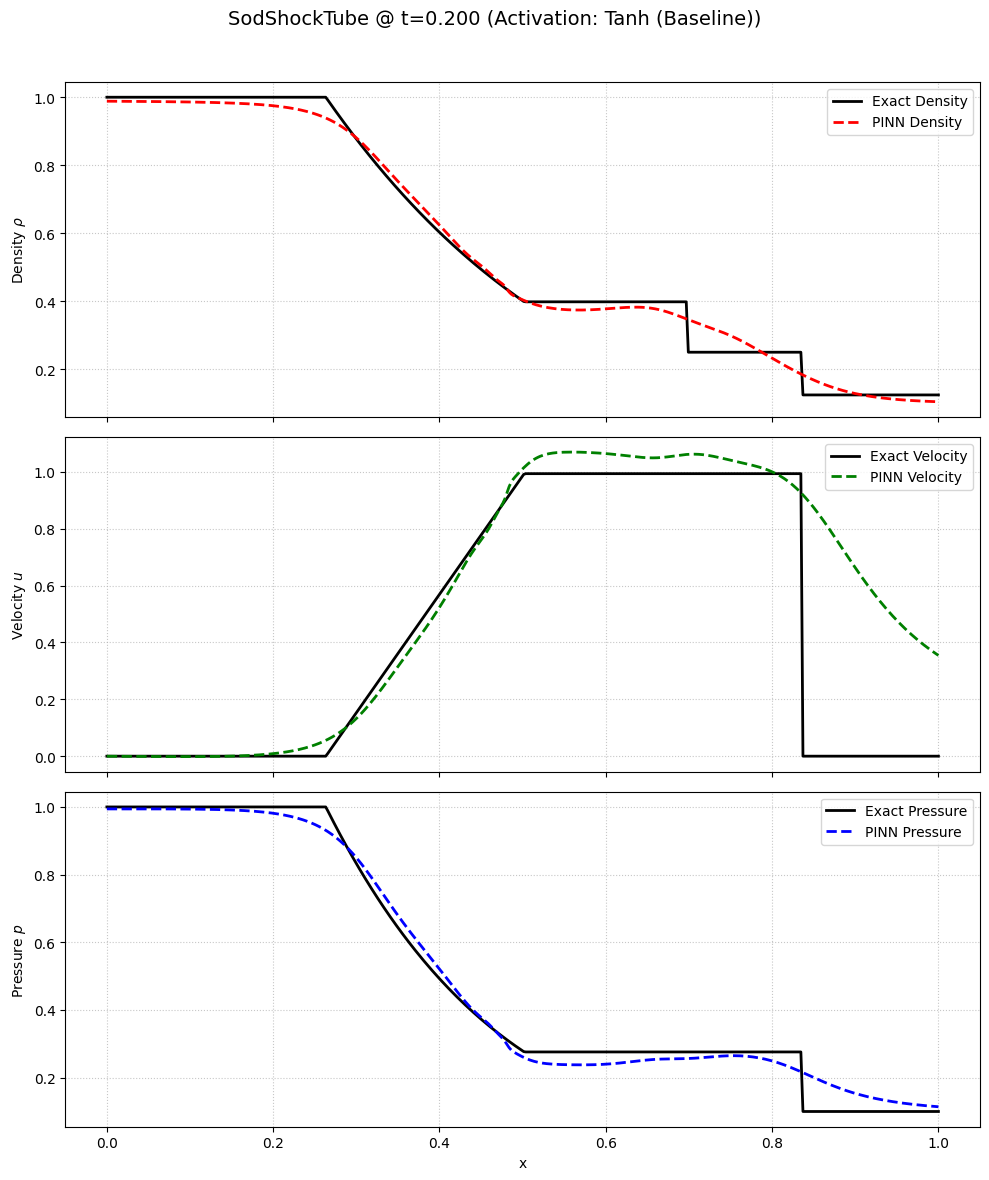

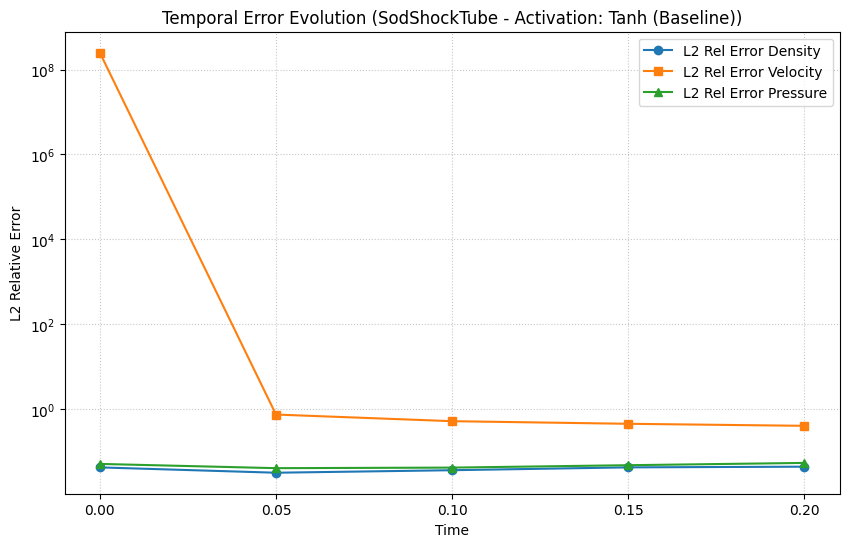


--- Running Experiment for Activation: LeakyReLU (Default) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 8.5286e+08 (PDE_M: 4.24e-07, PDE_Mom: 3.68e+06, PDE_E: 8.49e+08, IC: 1.28e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 6.6717e+00 (PDE_M: 2.39e-01, PDE_Mom: 6.19e-01, PDE_E: 4.18e-01, IC: 1.08e-02), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.3509e+00 (PDE_M: 1.22e-01, PDE_Mom: 4.47e-01, PDE_E: 2.11e-01, IC: 5.14e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 1.9182e+00 (PDE_M: 6.87e-02, PDE_Mom: 2.89e-01, PDE_E: 1.37e-01, IC: 2.85e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 1.9753e+00 (PDE_M: 7.43e-02, PDE_Mom: 1.13e-01, PDE_E: 1.60e-01, IC: 3.25e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 1.4506e+00 (PDE_M: 6.40e-02, PDE_Mom: 1.57e-01, PDE_E: 1.42e-01, IC: 2.18e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.05e-01/1.03e+00), u(-4.33e-02/1.15e+00), p(9.30e-02/1.05e+00)
Epoch 7200/

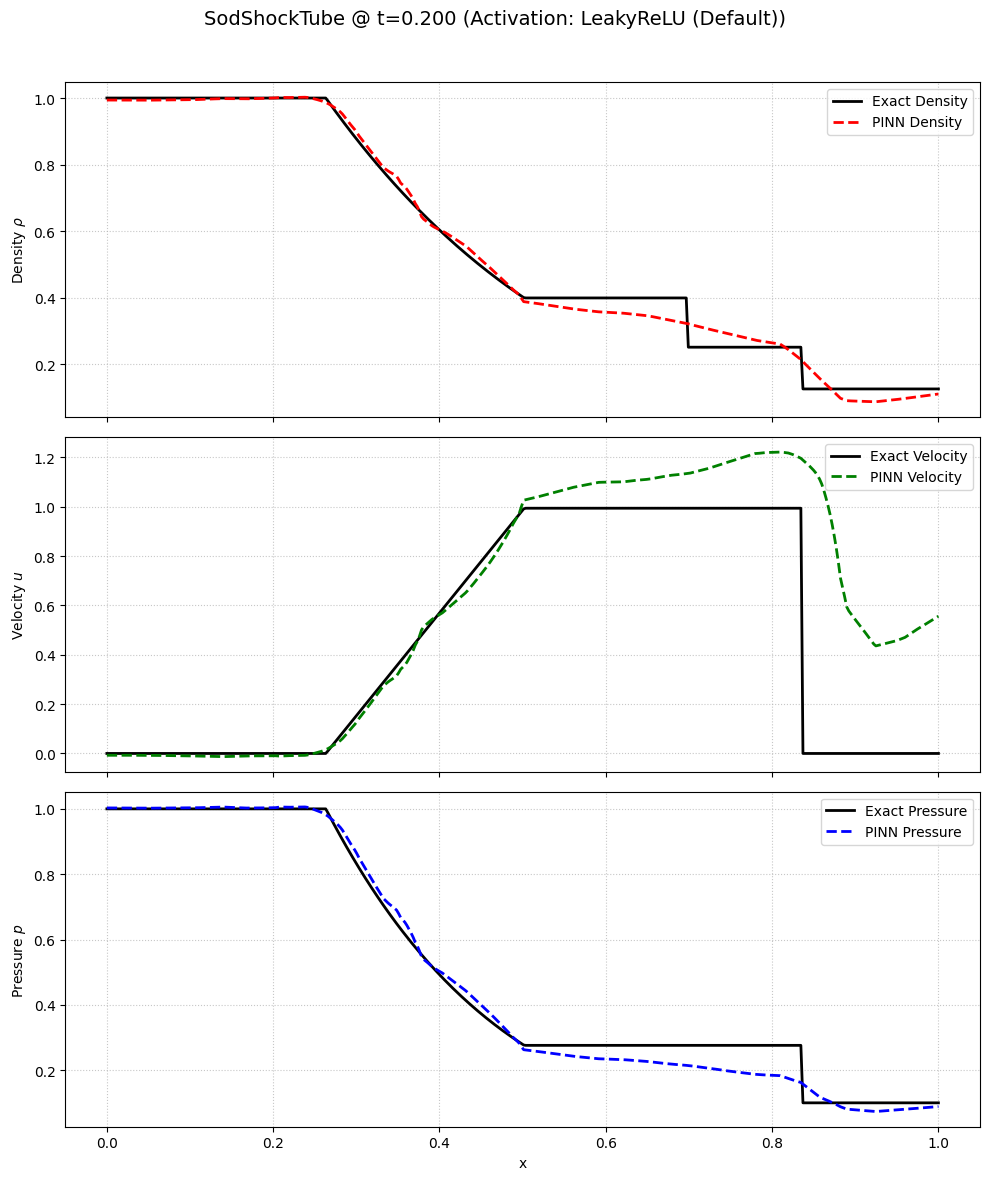

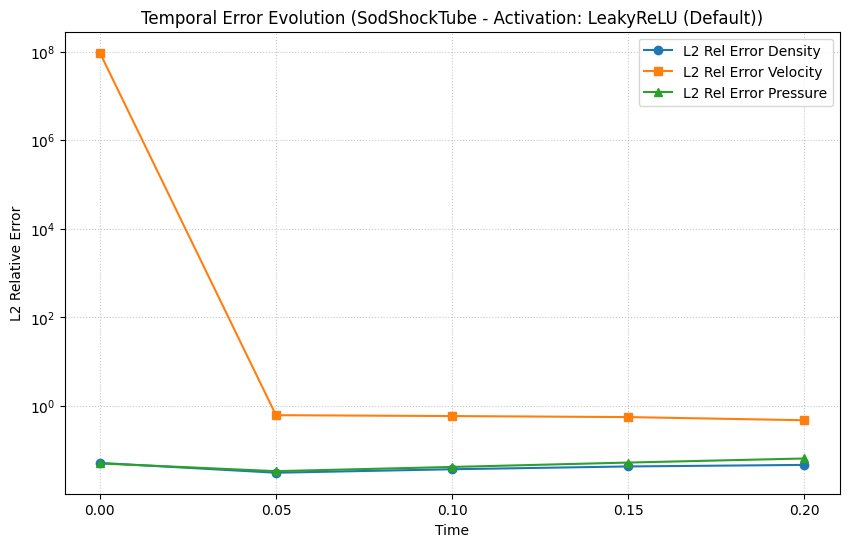


--- Running Experiment for Activation: Sigmoid ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 2.4543e+04 (PDE_M: 1.99e-14, PDE_Mom: 1.33e+03, PDE_E: 2.21e+04, IC: 2.24e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 2.4284e+02 (PDE_M: 4.62e-12, PDE_Mom: 3.79e-12, PDE_E: 5.18e-11, IC: 4.86e-01), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 2.4284e+02 (PDE_M: 7.05e-12, PDE_Mom: 4.35e-11, PDE_E: 8.47e-11, IC: 4.86e-01), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.4283e+02 (PDE_M: 7.35e-11, PDE_Mom: 2.03e-09, PDE_E: 9.47e-10, IC: 4.86e-01), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.4284e+02 (PDE_M: 5.93e-15, PDE_Mom: 5.39e-13, PDE_E: 3.71e-14, IC: 4.86e-01), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 2.4284e+02 (PDE_M: 9.74e-14, PDE_Mom: 1.08e-11, PDE_E: 5.84e-13, IC: 4.86e-01), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(5.63e-01/5.63e-01), u(2.46e-03/2.46e-03), p(5.50e-01/5.50e-01)
Epoch 7200/30000 -> Loss

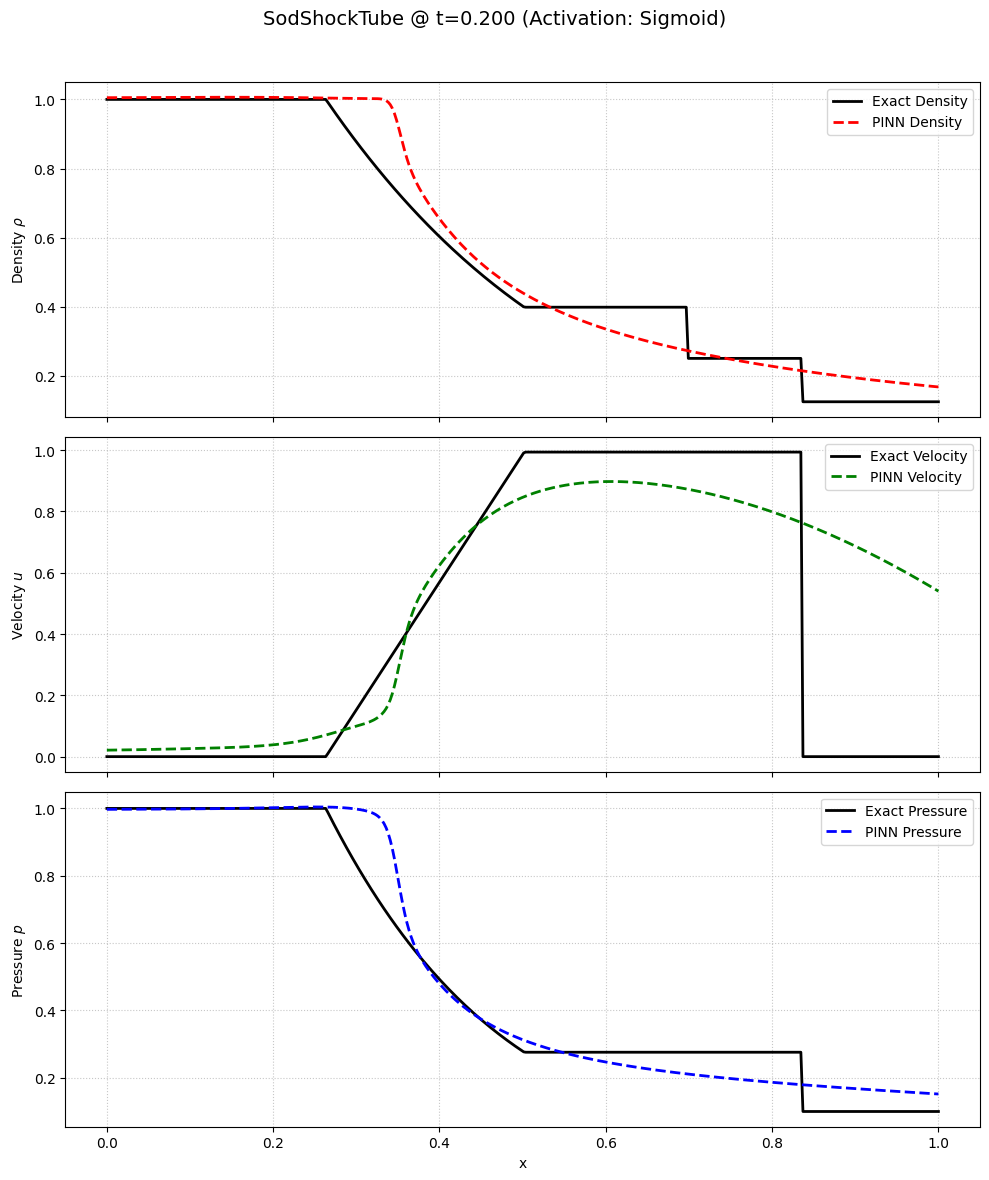

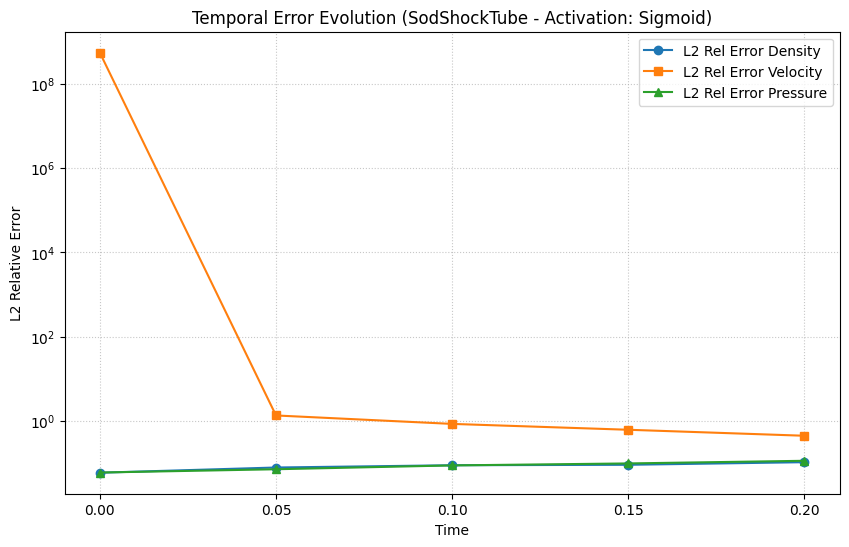


--- Running Experiment for Activation: Gaussian (alpha=5 Fixed) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 7.1971e+14 (PDE_M: 7.12e-03, PDE_Mom: 3.53e+14, PDE_E: 3.67e+14, IC: 1.97e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 4.9001e+00 (PDE_M: 3.98e-02, PDE_Mom: 1.03e-01, PDE_E: 9.86e-02, IC: 9.32e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 4.1214e+00 (PDE_M: 4.17e-02, PDE_Mom: 4.98e-02, PDE_E: 3.84e-02, IC: 7.98e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 3.3870e+00 (PDE_M: 4.09e-02, PDE_Mom: 4.55e-02, PDE_E: 3.75e-02, IC: 6.53e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.9767e+00 (PDE_M: 5.46e-02, PDE_Mom: 2.13e-01, PDE_E: 4.98e-02, IC: 5.32e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 2.7796e+00 (PDE_M: 4.58e-02, PDE_Mom: 4.95e-02, PDE_E: 4.42e-02, IC: 5.28e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.16e-01/9.98e-01), u(4.34e-04/1.04e+00), p(9.78e-02/1.01e+00)
Epoch 7

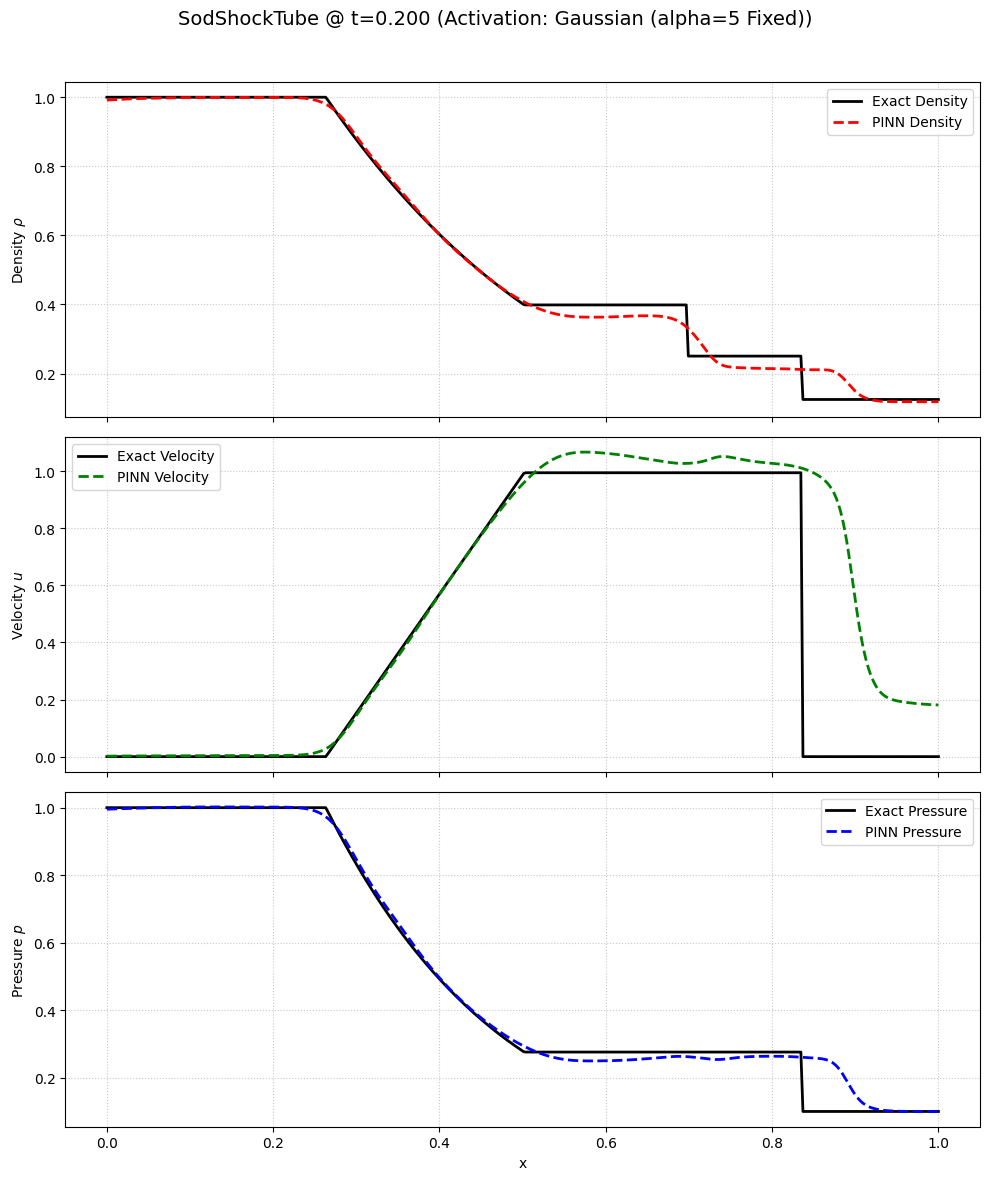

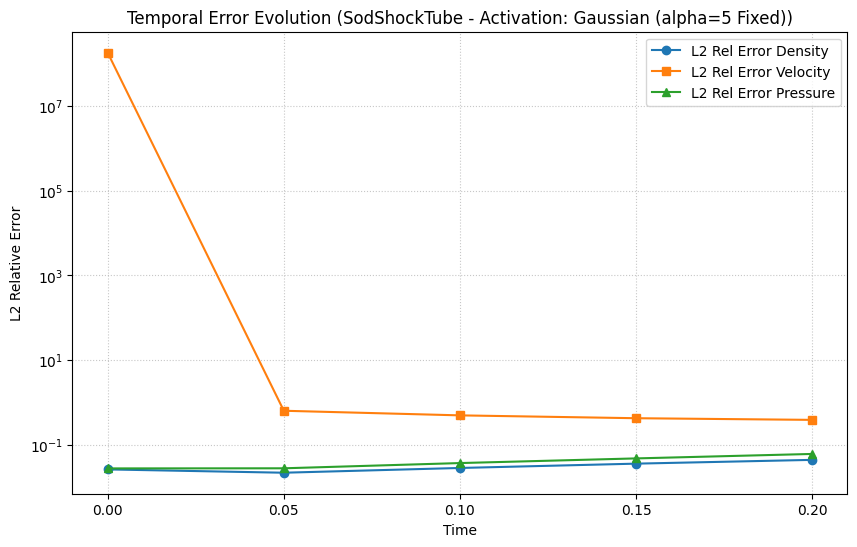


--- Running Experiment for Activation: Gaussian (alpha Learn, init=5) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 4.6250e+02 (PDE_M: 5.85e-03, PDE_Mom: 3.22e-02, PDE_E: 1.43e-01, IC: 9.25e-01), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 4.6096e+00 (PDE_M: 6.37e-02, PDE_Mom: 5.31e-02, PDE_E: 4.85e-02, IC: 8.89e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.8183e+00 (PDE_M: 4.99e-02, PDE_Mom: 8.63e-02, PDE_E: 3.26e-02, IC: 7.30e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 3.2304e+00 (PDE_M: 4.87e-02, PDE_Mom: 6.36e-02, PDE_E: 5.21e-02, IC: 6.13e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.7528e+00 (PDE_M: 3.79e-02, PDE_Mom: 4.06e-02, PDE_E: 7.48e-02, IC: 5.20e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 2.7607e+00 (PDE_M: 4.75e-02, PDE_Mom: 5.62e-02, PDE_E: 2.64e-02, IC: 5.26e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.11e-01/1.01e+00), u(-1.22e-02/1.03e+00), p(1.02e-01/1.01e+00)


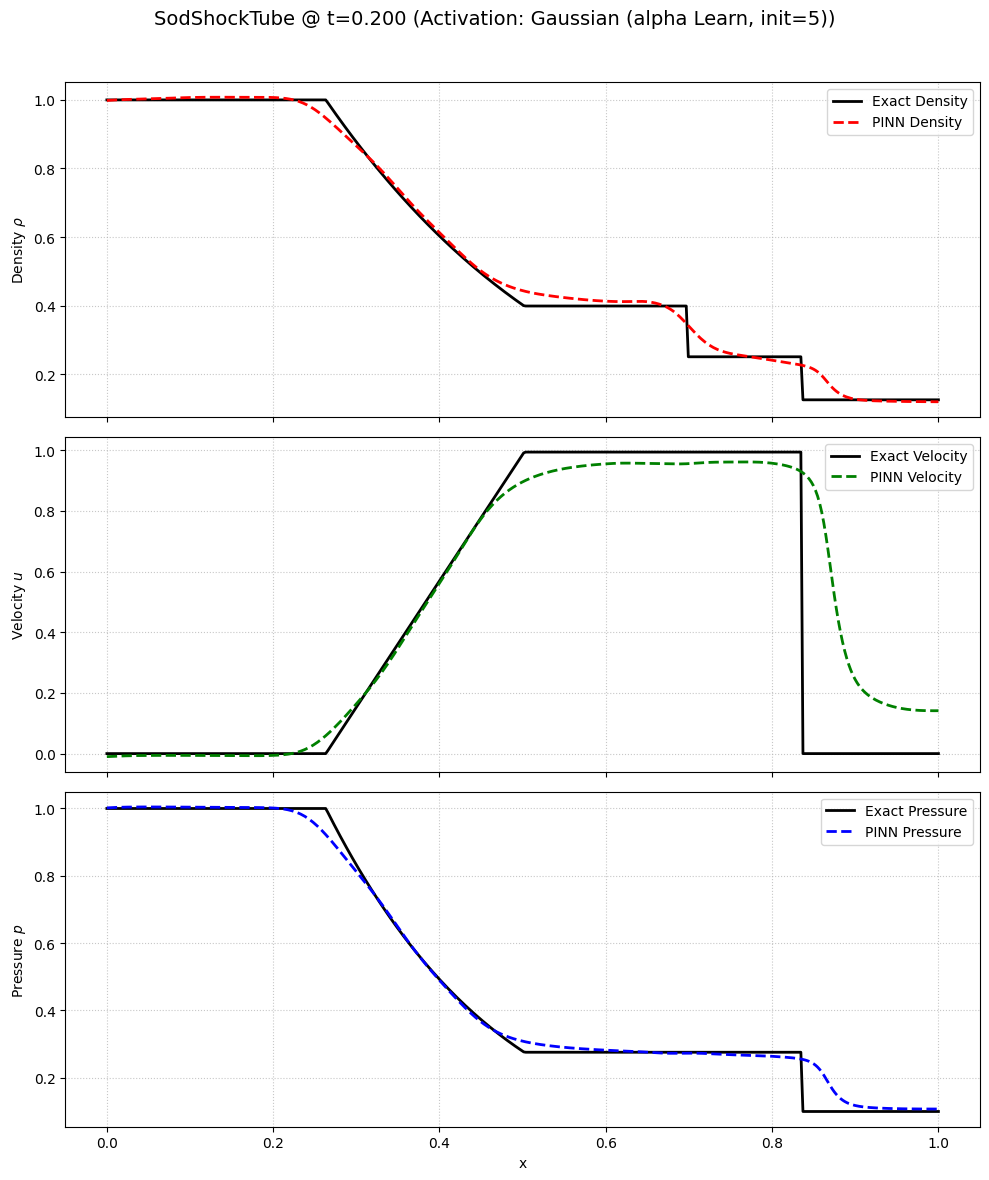

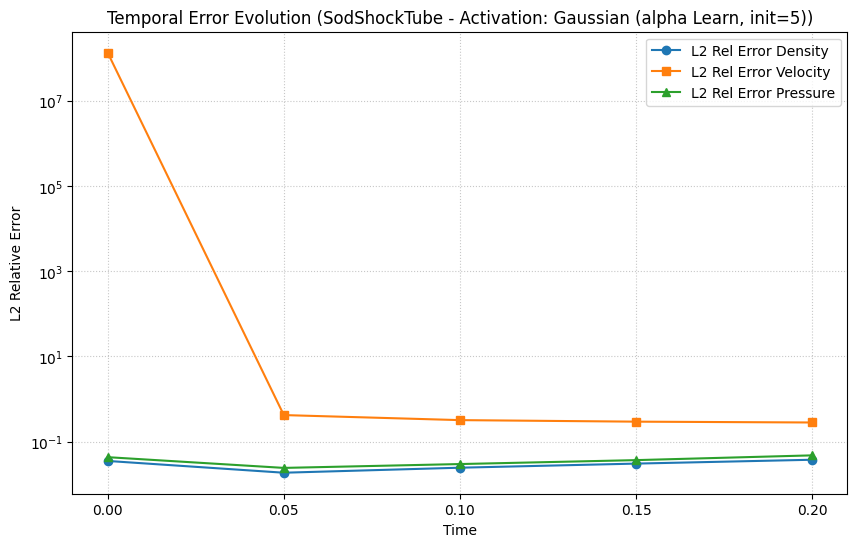

  Final learnable alpha (for Gaussian (alpha Learn, init=5)): 5.1555

--- Running Experiment for Activation: MexicanHat (s=1 Fixed) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 1.8933e+14 (PDE_M: 1.68e-04, PDE_Mom: 1.12e+14, PDE_E: 7.71e+13, IC: 2.90e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 3.4688e+00 (PDE_M: 5.65e-02, PDE_Mom: 1.69e-01, PDE_E: 1.04e-01, IC: 6.28e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 2.8680e+00 (PDE_M: 4.42e-02, PDE_Mom: 1.36e-01, PDE_E: 5.14e-02, IC: 5.27e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 3.4027e+00 (PDE_M: 4.88e-02, PDE_Mom: 1.24e-01, PDE_E: 1.18e-01, IC: 6.22e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.4113e+00 (PDE_M: 4.40e-02, PDE_Mom: 5.18e-02, PDE_E: 3.22e-02, IC: 4.57e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 1.4427e+00 (PDE_M: 6.86e-02, PDE_Mom: 2.48e-01, PDE_E: 6.60e-02, IC: 2.12e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.1

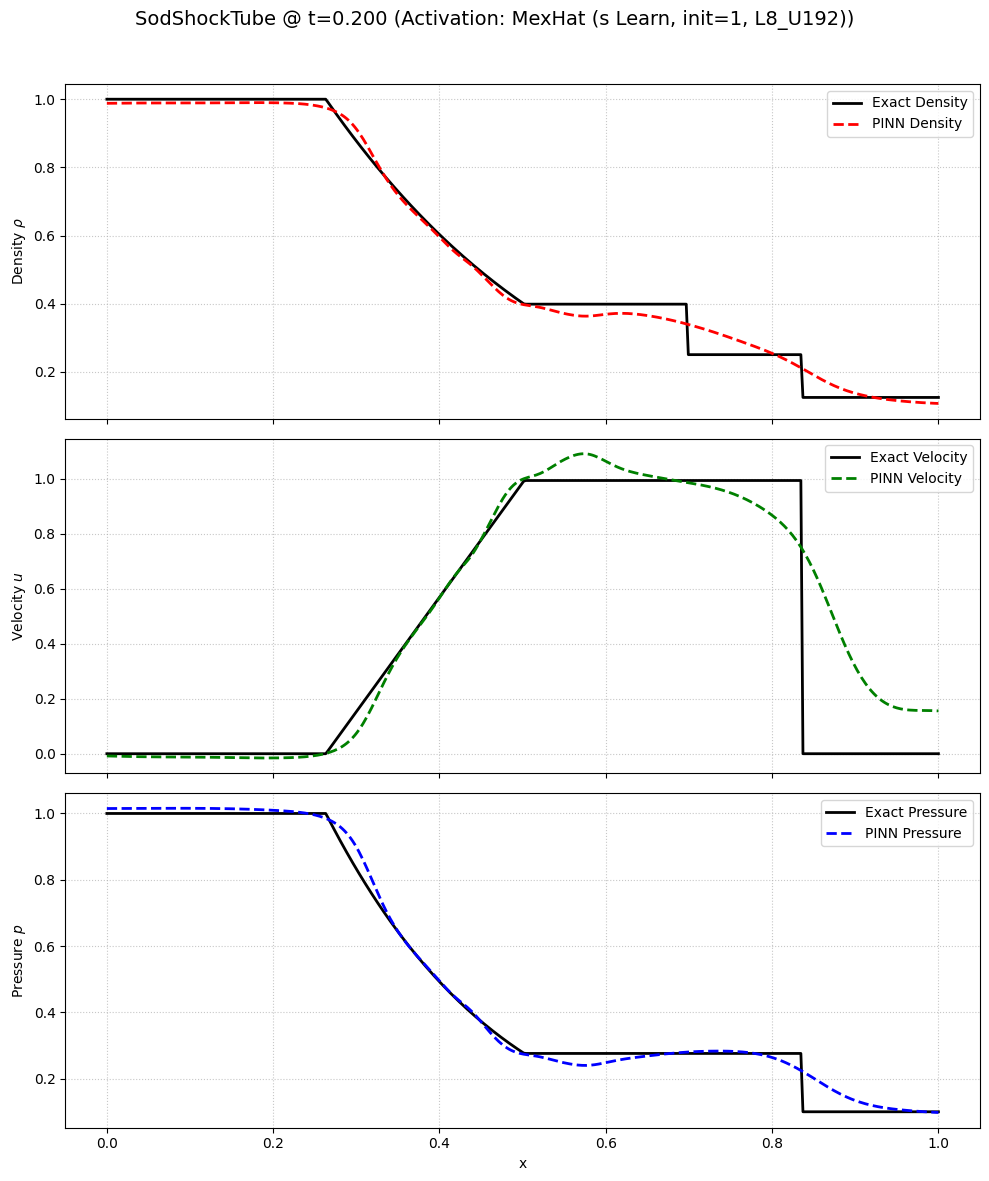

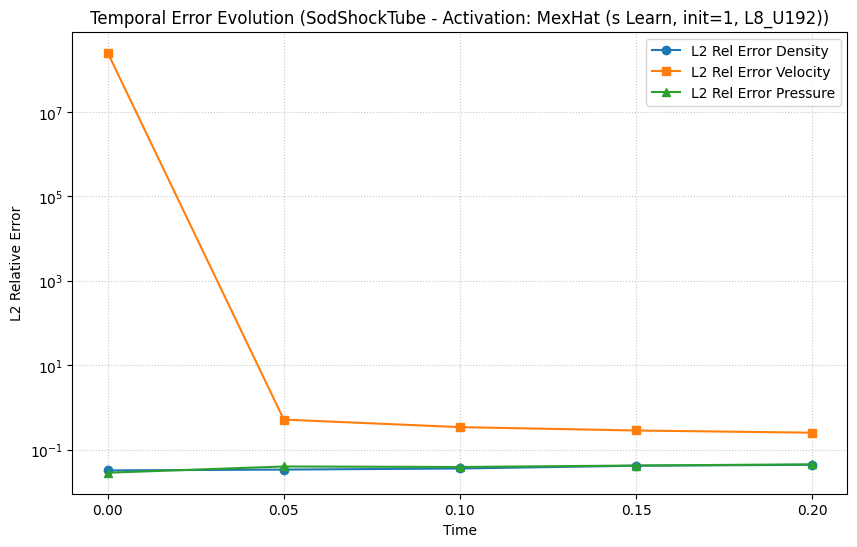

  Final learnable sigma (for MexHat (s Learn, init=1, L8_U192)): 0.8217

--- Running Experiment for Activation: Morlet (s0.7,w5 Fixed) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 3.2508e+20 (PDE_M: 1.59e+03, PDE_Mom: 2.18e+20, PDE_E: 1.07e+20, IC: 1.46e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 6.5866e+00 (PDE_M: 3.55e-01, PDE_Mom: 1.83e+00, PDE_E: 1.93e+00, IC: 4.94e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 2.8959e+00 (PDE_M: 2.20e-01, PDE_Mom: 3.28e-01, PDE_E: 1.26e+00, IC: 2.17e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 3.5302e+00 (PDE_M: 1.44e-01, PDE_Mom: 3.23e-01, PDE_E: 8.20e-01, IC: 4.49e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 3.2897e+00 (PDE_M: 1.73e-01, PDE_Mom: 2.17e-01, PDE_E: 7.39e-01, IC: 4.32e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 1.2416e+01 (PDE_M: 3.78e-01, PDE_Mom: 4.83e-01, PDE_E: 4.11e+00, IC: 1.49e-02), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(

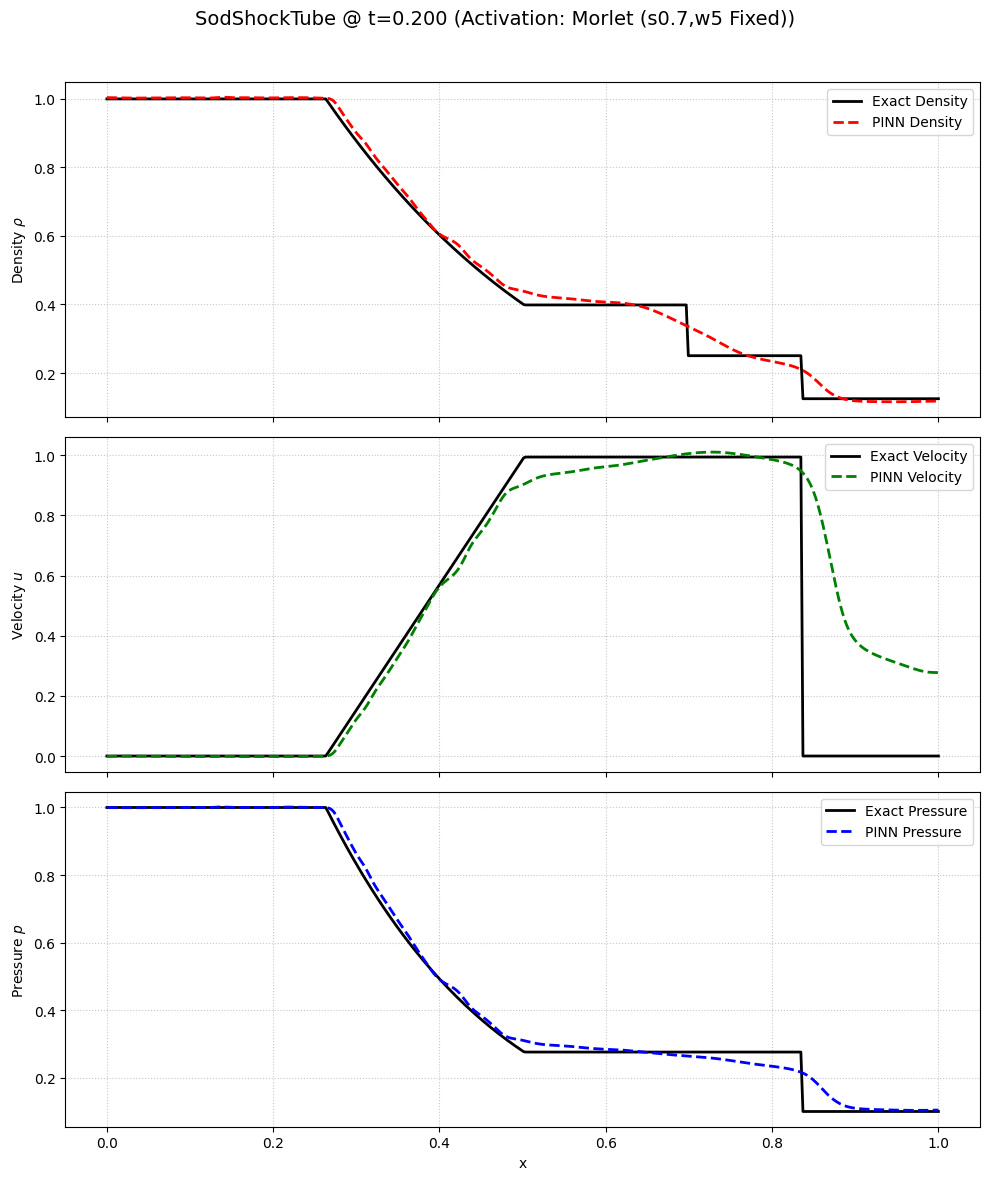

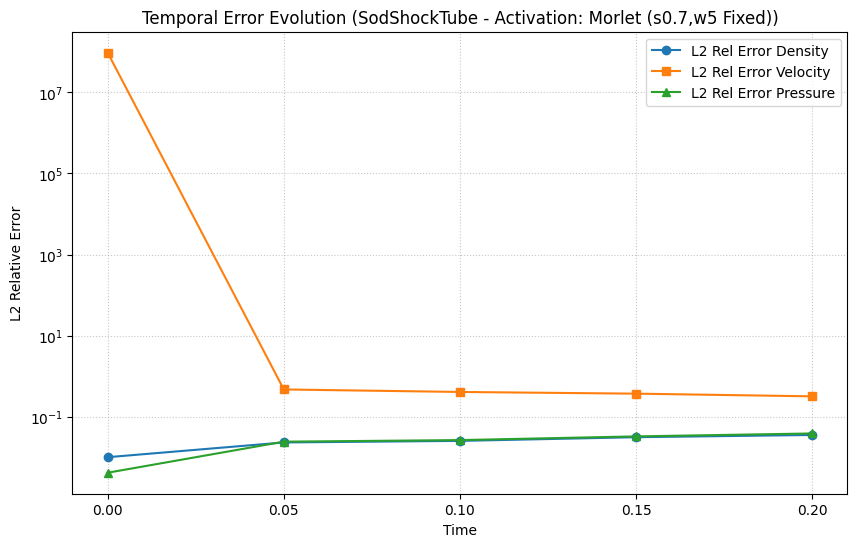


--- Running Experiment for Activation: Morlet (s,w0 Learn, init s0.7,w5) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,1.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 3.6383e+20 (PDE_M: 1.39e+03, PDE_Mom: 2.22e+20, PDE_E: 1.41e+20, IC: 1.16e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 8.7180e+00 (PDE_M: 2.08e-01, PDE_Mom: 1.76e+00, PDE_E: 9.03e-01, IC: 1.17e-02), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 3.3808e+00 (PDE_M: 1.37e-01, PDE_Mom: 1.25e-01, PDE_E: 6.15e-01, IC: 5.01e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 2.8430e+00 (PDE_M: 1.06e-01, PDE_Mom: 1.26e+00, PDE_E: 3.24e-01, IC: 2.32e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.8692e+00 (PDE_M: 1.22e-01, PDE_Mom: 7.97e-02, PDE_E: 2.86e-01, IC: 4.76e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 2.9772e+00 (PDE_M: 2.11e-01, PDE_Mom: 2.35e-01, PDE_E: 1.06e+00, IC: 2.93e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.02e-01/9.90e-01), u(-2.78e-02/1.00e+00), p(9.22e-02/1.01e+0

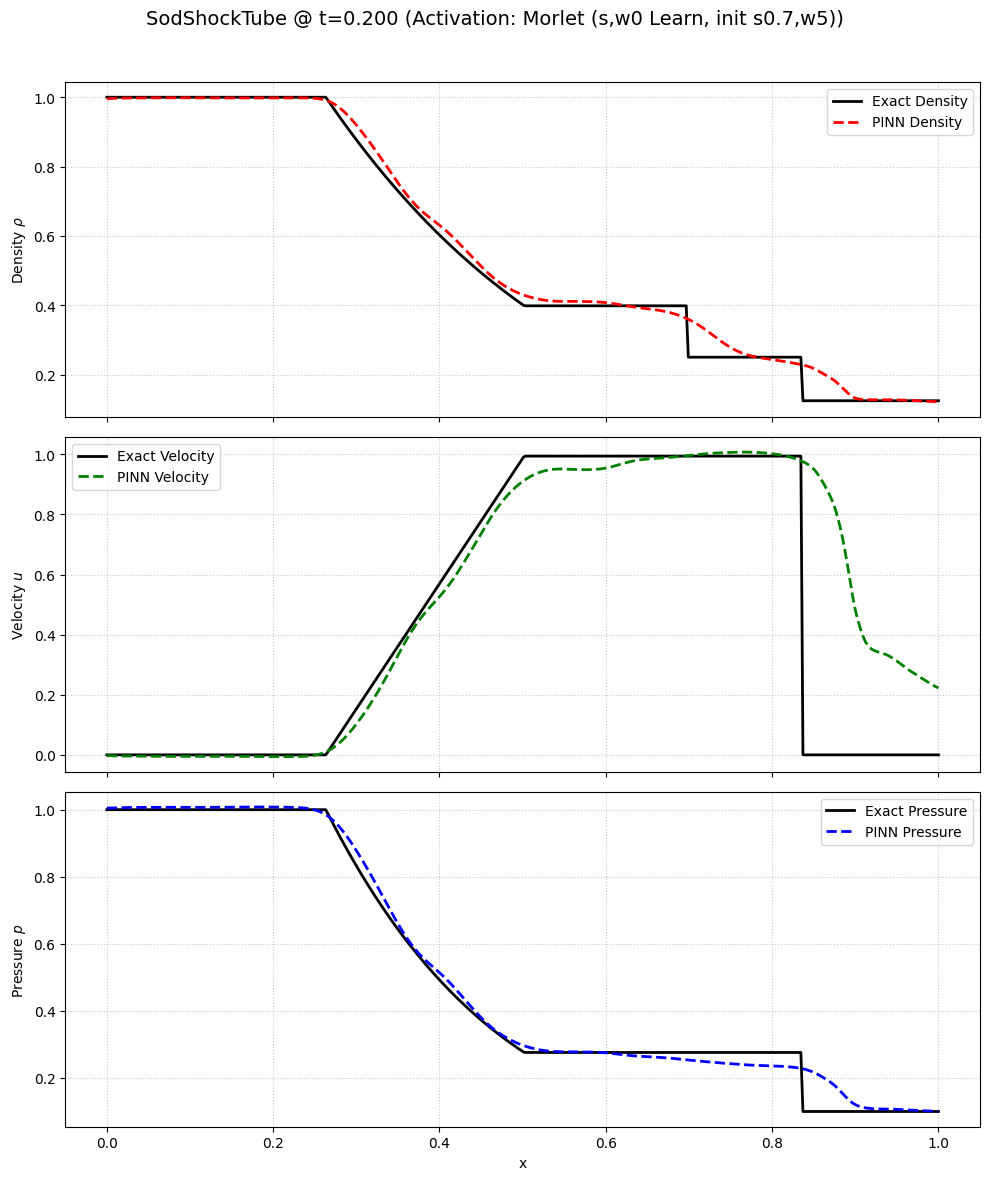

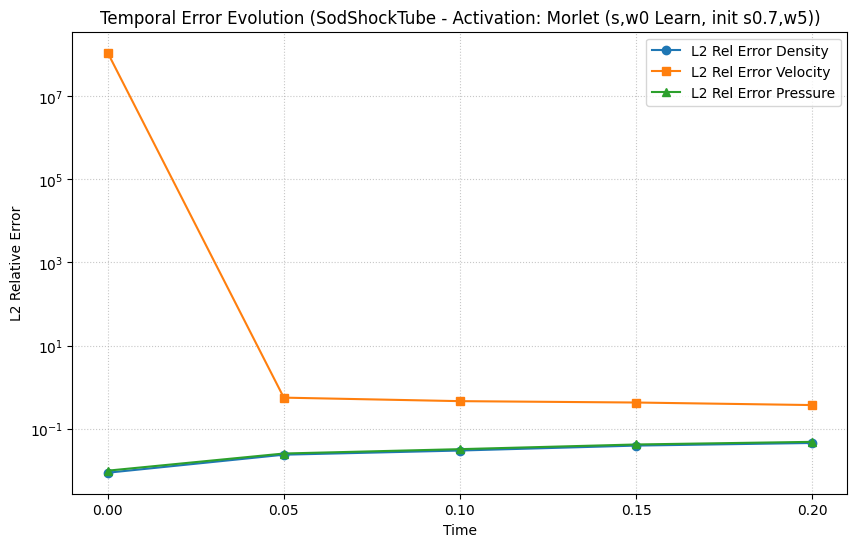

  Final learnable sigma (for Morlet (s,w0 Learn, init s0.7,w5)): 0.2324
  Final learnable omega0 (for Morlet (s,w0 Learn, init s0.7,w5)): 3.8436

--- Running Experiment for Activation: Morlet (s0.7,w5 Fixed, MomW=5) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,10.0,1.0), Clip=1.0, Layers=7, Units=128
Epoch 0/30000 -> Loss: 2.7528e+21 (PDE_M: 1.20e+03, PDE_Mom: 2.60e+20, PDE_E: 1.51e+20, IC: 1.75e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 5.5450e+00 (PDE_M: 2.17e-01, PDE_Mom: 1.32e-01, PDE_E: 1.01e+00, IC: 5.98e-03), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 5.8425e+00 (PDE_M: 1.84e-01, PDE_Mom: 7.53e-02, PDE_E: 7.22e-01, IC: 8.37e-03), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 6.6671e+00 (PDE_M: 2.07e-01, PDE_Mom: 3.36e-01, PDE_E: 1.50e+00, IC: 3.21e-03), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 4.0594e+00 (PDE_M: 1.46e-01, PDE_Mom: 5.25e-02, PDE_E: 4.28e-01, IC: 5.92e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 6.6206e+00 (PDE_M: 1.43e-01, PDE_Mom: 2.84e-01, PDE

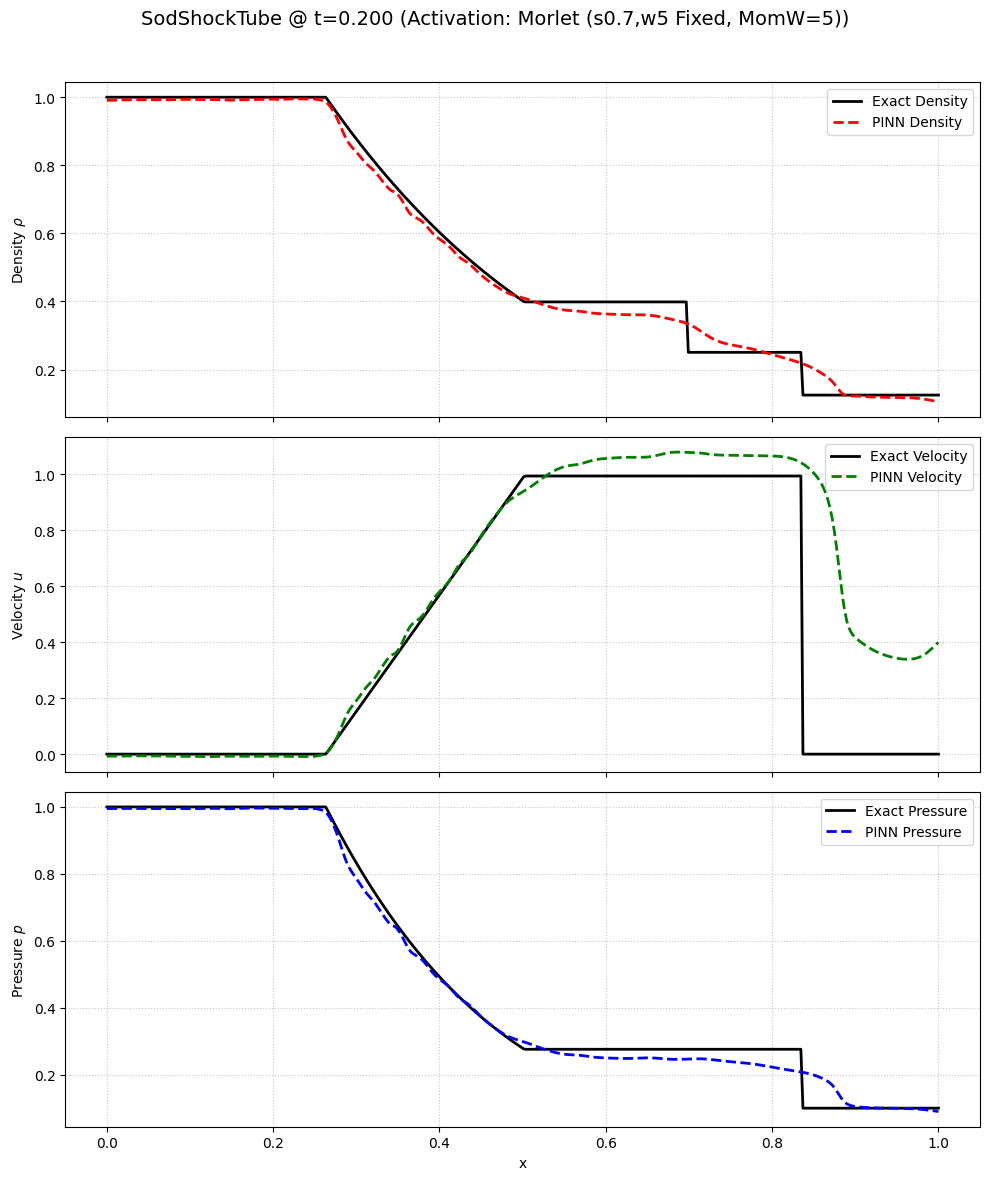

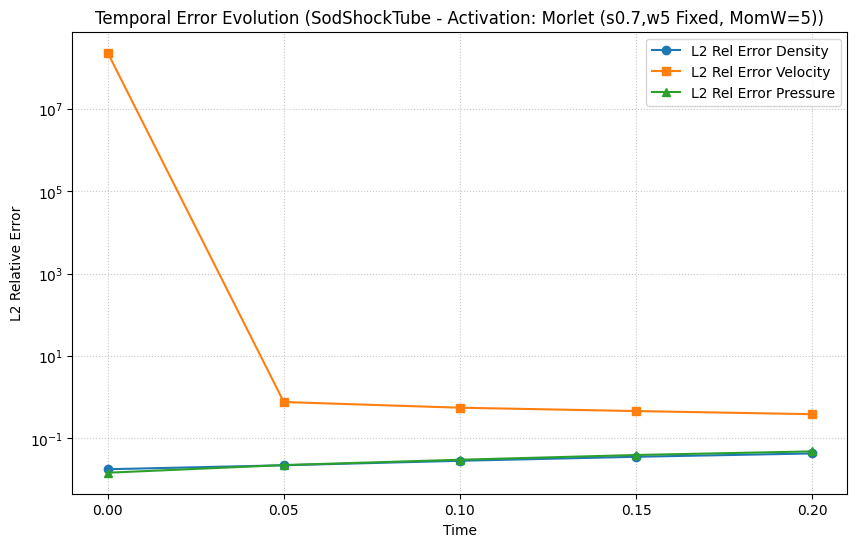


--- Running Experiment for Activation: MexHat (s L, init=1, L8U192, MomW=5) ---
Parameters: Epochs=30000, LR=0.0005, IC_W=500.0, PDE_Ws(M,Mom,E)=(1.0,10.0,1.0), Clip=1.0, Layers=8, Units=192
Epoch 0/30000 -> Loss: 4.1768e+14 (PDE_M: 3.67e-05, PDE_Mom: 3.84e+13, PDE_E: 3.39e+13, IC: 1.05e+00), LR: 5.00e-04
Epoch 1200/30000 -> Loss: 3.7558e+17 (PDE_M: 7.65e-01, PDE_Mom: 3.19e+16, PDE_E: 5.68e+16, IC: 1.92e-01), LR: 5.00e-04
Epoch 2400/30000 -> Loss: 1.0530e+02 (PDE_M: 1.15e+00, PDE_Mom: 1.51e+00, PDE_E: 6.40e+00, IC: 1.65e-01), LR: 5.00e-04
Epoch 3600/30000 -> Loss: 3.6442e+01 (PDE_M: 2.42e-01, PDE_Mom: 5.34e-01, PDE_E: 5.23e-01, IC: 6.07e-02), LR: 5.00e-04
Epoch 4800/30000 -> Loss: 2.9252e+00 (PDE_M: 1.74e-01, PDE_Mom: 4.90e-02, PDE_E: 2.44e-01, IC: 4.03e-03), LR: 5.00e-04
Epoch 6000/30000 -> Loss: 3.3411e+00 (PDE_M: 2.29e-01, PDE_Mom: 2.76e-02, PDE_E: 1.39e-01, IC: 5.39e-03), LR: 5.00e-04
    Debug Preds (min/max @ t=0.10): rho(1.07e-01/1.01e+00), u(-9.10e-03/9.69e-01), p(1.03e-01/1.0

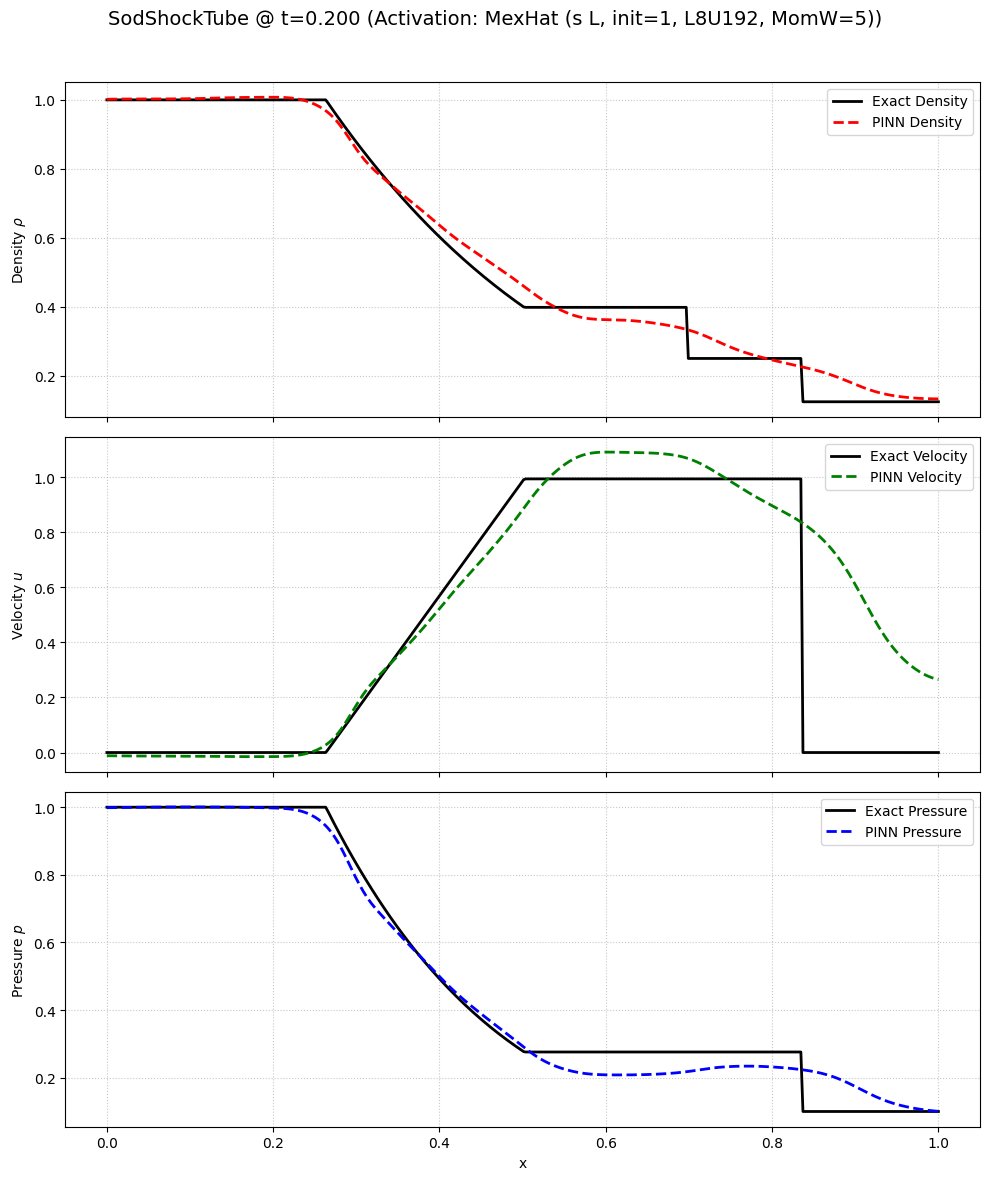

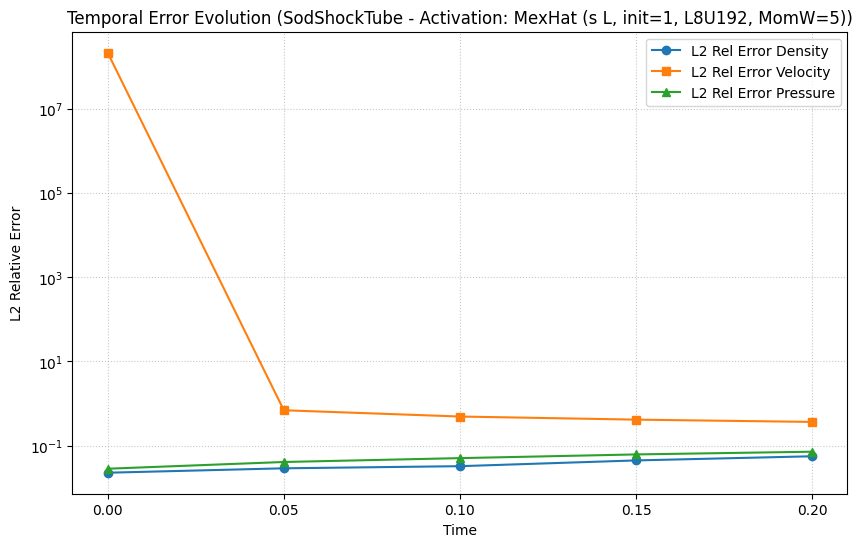

  Final learnable sigma (for MexHat (s L, init=1, L8U192, MomW=5)): 0.8358


--- Overall Comparison Summary (Errors at t_final) ---
Activation Config                                  | Rho L1  | Rho L2  | U L1    | U L2    | P L1    | P L2    | Time (s)
-------------------------------------------------------------------------------------------------------------------------
Tanh (Baseline)                                    | 4.14e-02 | 4.44e-02 | 2.85e-01 | 4.07e-01 | 5.25e-02 | 5.45e-02 | 544.66
LeakyReLU (Default)                                | 4.08e-02 | 4.59e-02 | 3.62e-01 | 4.69e-01 | 5.64e-02 | 6.42e-02 | 519.28
Sigmoid                                            | 8.48e-02 | 1.05e-01 | 3.92e-01 | 4.44e-01 | 9.01e-02 | 1.13e-01 | 549.86
Gaussian (alpha=5 Fixed)                           | 3.25e-02 | 4.35e-02 | 2.22e-01 | 3.83e-01 | 3.52e-02 | 6.00e-02 | 776.49
Gaussian (alpha Learn, init=5)                     | 2.88e-02 | 3.76e-02 | 1.73e-01 | 2.82e-01 | 2.88e-02 | 4.76e-02 | 8

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import brentq # For the Riemann solver root finding

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GAMMA = 1.4  # Ratio of specific heats
print(f"Using device: {DEVICE}")

# --- 1. Euler Equations & Riemann Problem Utilities ---
def primitive_to_conserved(rho, u, p):
    rho = torch.as_tensor(rho, dtype=torch.float32, device=DEVICE)
    u = torch.as_tensor(u, dtype=torch.float32, device=DEVICE)
    p = torch.as_tensor(p, dtype=torch.float32, device=DEVICE)
    E_internal = p / ((GAMMA - 1.0) * rho.clamp(min=1e-9))
    E_total = rho * (E_internal + 0.5 * u**2)
    return torch.stack([rho, rho * u, E_total], dim=-1)

def conserved_to_primitive(Q_conserved):
    rho = Q_conserved[..., 0:1].clamp(min=1e-9)
    rhou = Q_conserved[..., 1:2]
    E_total_conserved = Q_conserved[..., 2:3]
    u = rhou / rho 
    pressure_val = (E_total_conserved - 0.5 * rhou**2 / rho) * (GAMMA - 1.0)
    p = pressure_val.clamp(min=1e-9)
    return rho, u, p

def euler_fluxes_conserved(Q_conserved):
    rho, u, p = conserved_to_primitive(Q_conserved)
    F_component_0 = Q_conserved[..., 1:2]
    F_component_1 = Q_conserved[..., 1:2] * u + p
    F_component_2 = (Q_conserved[..., 2:3] + p) * u
    return torch.cat([F_component_0, F_component_1, F_component_2], dim=-1)

# --- Initial Conditions (Sod Shock Tube) ---
DIAPHRAGM_LOCATION = 0.5
def get_sod_initial_conditions(x_coords): 
    rho_ic = torch.where(x_coords < DIAPHRAGM_LOCATION, torch.tensor(1.0), torch.tensor(0.125)).to(DEVICE)
    p_ic = torch.where(x_coords < DIAPHRAGM_LOCATION, torch.tensor(1.0), torch.tensor(0.1)).to(DEVICE)
    u_ic = torch.zeros_like(x_coords).to(DEVICE)
    return primitive_to_conserved(rho_ic, u_ic, p_ic)

# --- Exact Riemann Solver for Sod Problem (Ground Truth) ---
def exact_sod_solver(x_np, t_val):
    rho_L, u_L, p_L = 1.0, 0.0, 1.0
    rho_R, u_R, p_R = 0.125, 0.0, 0.1
    
    if abs(t_val) < 1e-9: 
        rho = np.where(x_np < DIAPHRAGM_LOCATION, rho_L, rho_R)
        u = np.where(x_np < DIAPHRAGM_LOCATION, u_L, u_R)
        p = np.where(x_np < DIAPHRAGM_LOCATION, p_L, p_R)
        return rho, u, p

    a_L = np.sqrt(GAMMA * p_L / rho_L)
    a_R = np.sqrt(GAMMA * p_R / rho_R)

    def F_k(P_star_func, P_k_func, RHO_k_func, A_k_func):
        if P_star_func > P_k_func:
            den_shock = RHO_k_func * ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star_func + (GAMMA - 1.0) / (2.0 * GAMMA) * P_k_func )
            return (P_star_func - P_k_func) / np.sqrt(max(1e-12, den_shock))
        else:
            pressure_ratio_clipped = max(1e-12, P_star_func / P_k_func)
            return (2.0 * A_k_func / (GAMMA - 1.0)) * ( pressure_ratio_clipped**((GAMMA - 1.0) / (2.0 * GAMMA)) - 1.0 )

    def pressure_function_for_root(P_star_guess_func):
        return F_k(P_star_guess_func, p_L, rho_L, a_L) + F_k(P_star_guess_func, p_R, rho_R, a_R) - (u_L - u_R)

    p_min_search = 1e-7 
    p_max_search = max(p_L, p_R) * 50.0 
    P_star = 0.30313 
    try:
        P_star = brentq(pressure_function_for_root, p_min_search, p_max_search, xtol=1e-12, rtol=1e-12)
    except (ValueError, RuntimeError) as e:
        print(f"Warning: Root finding for P_star failed or did not converge. Error: {e}. Using approximate P_star={P_star} for Sod.")

    U_star = 0.5 * (u_L + u_R) + 0.5 * (F_k(P_star, p_R, rho_R, a_R) - F_k(P_star, p_L, rho_L, a_L))

    if P_star > p_L:
        rho_star_L = rho_L * ( (P_star / p_L + (GAMMA - 1.0) / (GAMMA + 1.0)) / \
                               ( max(1e-12, (GAMMA - 1.0) / (GAMMA + 1.0) * P_star / p_L + 1.0)) )
    else:
        rho_star_L = rho_L * max(1e-12, P_star / p_L)**(1.0 / GAMMA)

    if P_star > p_R:
        rho_star_R = rho_R * ( (P_star / p_R + (GAMMA - 1.0) / (GAMMA + 1.0)) / \
                               ( max(1e-12, (GAMMA - 1.0) / (GAMMA + 1.0) * P_star / p_R + 1.0)) )
    else:
        rho_star_R = rho_R * max(1e-12, P_star / p_R)**(1.0 / GAMMA)
    
    rho_star_L = max(1e-9, rho_star_L) 
    rho_star_R = max(1e-9, rho_star_R) 

    S_contact = U_star 
    
    if P_star > p_L: 
        S_L = u_L - a_L * np.sqrt( max(1e-12, ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star / p_L + (GAMMA - 1.0) / (2.0 * GAMMA) ) ))
    else: 
        a_star_L = np.sqrt(GAMMA * P_star / rho_star_L) 
        S_HL = u_L - a_L 
        S_TL = U_star - a_star_L 

    if P_star > p_R: 
        S_R = u_R + a_R * np.sqrt( max(1e-12, ( (GAMMA + 1.0) / (2.0 * GAMMA) * P_star / p_R + (GAMMA - 1.0) / (2.0 * GAMMA) ) ))
    else: 
        a_star_R = np.sqrt(GAMMA * P_star / rho_star_R) 
        S_HR = u_R + a_R 
        S_TR = U_star + a_star_R 
        
    rho_sol = np.zeros_like(x_np)
    u_sol = np.zeros_like(x_np)
    p_sol = np.zeros_like(x_np)

    for i, x_pos in enumerate(x_np):
        s_lambda = (x_pos - DIAPHRAGM_LOCATION) / t_val 
        
        if s_lambda <= S_contact: 
            if P_star > p_L: # Left Shock
                if s_lambda < S_L: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_L, u_L, p_L
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_L, U_star, P_star
            else: # Left Rarefaction
                if s_lambda < S_HL: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_L, u_L, p_L
                elif s_lambda <= S_TL: 
                    u_sol[i] = (2.0 / (GAMMA + 1.0)) * (a_L + (GAMMA - 1.0) / 2.0 * u_L + s_lambda)
                    common_term_L = (2.0 / (GAMMA + 1.0)) + ( (GAMMA - 1.0) / ((GAMMA + 1.0) * a_L) ) * (u_L - s_lambda)
                    rho_sol[i] = rho_L * max(1e-12, common_term_L)**(2.0 / (GAMMA - 1.0))
                    p_sol[i] = p_L * max(1e-12, rho_sol[i] / max(1e-12, rho_L))**GAMMA
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_L, U_star, P_star
        else: 
            if P_star > p_R: # Right Shock
                if s_lambda < S_R: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_R, U_star, P_star
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_R, u_R, p_R
            else: # Right Rarefaction
                if s_lambda <= S_TR: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_star_R, U_star, P_star
                elif s_lambda < S_HR: 
                    u_sol[i] = (2.0 / (GAMMA + 1.0)) * (-a_R + (GAMMA - 1.0) / 2.0 * u_R + s_lambda)
                    common_term_R = (2.0 / (GAMMA + 1.0)) - ( (GAMMA - 1.0) / ((GAMMA + 1.0) * a_R) ) * (u_R - s_lambda)
                    rho_sol[i] = rho_R * max(1e-12, common_term_R)**(2.0 / (GAMMA - 1.0))
                    p_sol[i] = p_R * max(1e-12, rho_sol[i] / max(1e-12, rho_R))**GAMMA
                else: 
                    rho_sol[i], u_sol[i], p_sol[i] = rho_R, u_R, p_R
    return rho_sol, u_sol, p_sol


# --- Wavelet-Inspired Activation Functions (with learnable parameter option) ---
class GaussianActivation(nn.Module):
    def __init__(self, initial_alpha=1.0, learnable=False): 
        super().__init__()
        if learnable:
            self.alpha = nn.Parameter(torch.tensor(float(initial_alpha)))
        else:
            self.alpha_val = initial_alpha 
            self.alpha = None 
    def forward(self, x):
        current_alpha = self.alpha if self.alpha is not None else self.alpha_val
        return torch.exp(-current_alpha * x**2)

class MexicanHatActivation(nn.Module):
    def __init__(self, initial_sigma=1.0, learnable=False): 
        super().__init__()
        if learnable:
            self.sigma = nn.Parameter(torch.tensor(float(initial_sigma)))
        else:
            self.sigma_val = initial_sigma
            self.sigma = None
    def forward(self, x):
        current_sigma = self.sigma if self.sigma is not None else self.sigma_val
        effective_sigma = current_sigma.clamp(min=1e-6) if isinstance(current_sigma, torch.Tensor) else max(1e-6, current_sigma)
        x_scaled = x / effective_sigma
        return (1 - x_scaled**2) * torch.exp(-x_scaled**2 / 2.0)

class MorletActivation(nn.Module):
    def __init__(self, initial_sigma=1.0, initial_omega0=5.0, learnable=False): 
        super().__init__()
        if learnable:
            self.sigma = nn.Parameter(torch.tensor(float(initial_sigma)))
            self.omega0 = nn.Parameter(torch.tensor(float(initial_omega0)))
        else:
            self.sigma_val = initial_sigma
            self.omega0_val = initial_omega0
            self.sigma = None 
            self.omega0 = None 
            
    def forward(self, x):
        current_sigma = self.sigma if self.sigma is not None else self.sigma_val
        current_omega0 = self.omega0 if self.omega0 is not None else self.omega0_val
        
        effective_sigma = current_sigma.clamp(min=1e-6) if isinstance(current_sigma, torch.Tensor) else max(1e-6, current_sigma)
        scaled_x_env = x / effective_sigma
        envelope = torch.exp(-0.5 * scaled_x_env**2)
        carrier = torch.cos(current_omega0 * x) 
        return envelope * carrier

# --- PINN Model (Accepts custom activation) ---
class CustomActivationPINN(nn.Module):
    def __init__(self, num_input_features=2, num_output_features=3, num_layers=5, hidden_units=64, activation_module=None):
        super(CustomActivationPINN, self).__init__()
        self.activation = activation_module if activation_module is not None else nn.Tanh()

        layers = []
        layers.append(nn.Linear(num_input_features, hidden_units))
        layers.append(self.activation)
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_units, hidden_units), self.activation])
        layers.append(nn.Linear(hidden_units, num_output_features))
        self.network = nn.Sequential(*layers)

    def forward(self, x_t_coords):
        return self.network(x_t_coords)

# --- Loss Functions ---
def pde_residual_loss_euler(model, x_colloc, t_colloc):
    x_colloc.requires_grad_(True)
    t_colloc.requires_grad_(True)
    xt_coords = torch.stack([x_colloc, t_colloc], dim=-1)
    Q_pred = model(xt_coords) # Q_pred = [rho, rhou, E_total]

    # Mass conservation residual (PDE 1)
    rho_pred = Q_pred[:, 0:1]
    rhou_pred = Q_pred[:, 1:2]
    d_rho_dt = torch.autograd.grad(rho_pred.sum(), t_colloc, create_graph=True)[0].unsqueeze(-1)
    d_rhou_dx = torch.autograd.grad(rhou_pred.sum(), x_colloc, create_graph=True)[0].unsqueeze(-1)
    residual_mass = d_rho_dt + d_rhou_dx

    # Momentum conservation residual (PDE 2)
    # rhou_pred is Q_pred[:, 1:2]
    # For rhou^2/rho + p = rhou * u + p
    # We need primitive variables to compute p and u for the flux F[1] = rho*u^2 + p
    _, u_primitive_pred, p_primitive_pred = conserved_to_primitive(Q_pred)
    F1_momentum = rhou_pred * u_primitive_pred + p_primitive_pred # rho*u^2 + p

    d_rhou_dt = torch.autograd.grad(rhou_pred.sum(), t_colloc, create_graph=True)[0].unsqueeze(-1)
    d_F1momentum_dx = torch.autograd.grad(F1_momentum.sum(), x_colloc, create_graph=True)[0].unsqueeze(-1)
    residual_momentum = d_rhou_dt + d_F1momentum_dx
    
    # Energy conservation residual (PDE 3)
    E_total_pred = Q_pred[:, 2:3]
    # F[2] = (E_total + p) * u
    F2_energy = (E_total_pred + p_primitive_pred) * u_primitive_pred

    d_Etotal_dt = torch.autograd.grad(E_total_pred.sum(), t_colloc, create_graph=True)[0].unsqueeze(-1)
    d_F2energy_dx = torch.autograd.grad(F2_energy.sum(), x_colloc, create_graph=True)[0].unsqueeze(-1)
    residual_energy = d_Etotal_dt + d_F2energy_dx

    loss_mass = torch.mean(residual_mass**2)
    loss_momentum = torch.mean(residual_momentum**2)
    loss_energy = torch.mean(residual_energy**2)
    
    return loss_mass, loss_momentum, loss_energy


def initial_condition_loss_euler(model, x_ic_coords, ic_func):
    t_ic_coords = torch.zeros_like(x_ic_coords)
    Q_ic_true = ic_func(x_ic_coords)
    xt_coords_ic = torch.stack([x_ic_coords, t_ic_coords], dim=-1)
    Q_ic_pred = model(xt_coords_ic)
    return torch.mean((Q_ic_pred - Q_ic_true)**2)

# --- Training Loop (with stability enhancements & differential PDE weights) ---
def train_pinn(
    pinn_model, ic_func_train,
    epochs=10000, learning_rate=1e-3,
    x_domain_train=(-1.0, 1.0), t_max_train=0.2,
    num_colloc_train=2048, num_ic_train=512,
    mass_pde_w=1.0, momentum_pde_w=1.0, energy_pde_w=1.0, # New PDE weights
    ic_loss_weight_train=10.0,
    print_every=1000,
    gradient_clip_value=None 
):
    optimizer = torch.optim.Adam(pinn_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(1, epochs // 4), gamma=0.85) 

    for epoch in range(epochs):
        pinn_model.train()
        optimizer.zero_grad()

        x_colloc = torch.rand(num_colloc_train, device=DEVICE) * (x_domain_train[1] - x_domain_train[0]) + x_domain_train[0]
        t_colloc = torch.rand(num_colloc_train, device=DEVICE) * t_max_train
        x_ic = torch.linspace(x_domain_train[0], x_domain_train[1], num_ic_train, device=DEVICE)

        loss_mass_pde, loss_momentum_pde, loss_energy_pde = pde_residual_loss_euler(pinn_model, x_colloc, t_colloc)
        loss_ic = initial_condition_loss_euler(pinn_model, x_ic, ic_func_train)
        
        total_loss = (mass_pde_w * loss_mass_pde + 
                      momentum_pde_w * loss_momentum_pde + 
                      energy_pde_w * loss_energy_pde + 
                      ic_loss_weight_train * loss_ic)
        
        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"Epoch {epoch}: Encountered NaN/Inf loss. Stopping training for this configuration.")
            print(f"    Mass PDE: {loss_mass_pde.item()}, Mom PDE: {loss_momentum_pde.item()}, E PDE: {loss_energy_pde.item()}, IC: {loss_ic.item()}")
            return pinn_model 

        total_loss.backward()

        if gradient_clip_value is not None:
            torch.nn.utils.clip_grad_value_(pinn_model.parameters(), gradient_clip_value)

        optimizer.step()
        scheduler.step()

        if epoch % print_every == 0 or epoch == epochs - 1:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch}/{epochs} -> Loss: {total_loss.item():.4e} "
                  f"(PDE_M: {loss_mass_pde.item():.2e}, PDE_Mom: {loss_momentum_pde.item():.2e}, PDE_E: {loss_energy_pde.item():.2e}, "
                  f"IC: {loss_ic.item():.2e}), LR: {current_lr:.2e}")
            
            if epoch > 0 and epoch % (print_every * 5) == 0 : 
                pinn_model.eval()
                with torch.no_grad():
                    x_debug_sample = torch.linspace(x_domain_train[0], x_domain_train[1], 100, device=DEVICE)
                    t_debug_sample = torch.full_like(x_debug_sample, t_max_train / 2.0) 
                    xt_debug = torch.stack([x_debug_sample, t_debug_sample], dim=-1)
                    Q_debug = pinn_model(xt_debug)
                    rho_debug, u_debug, p_debug = conserved_to_primitive(Q_debug)
                    print(f"    Debug Preds (min/max @ t={t_max_train/2:.2f}): rho({rho_debug.min().item():.2e}/{rho_debug.max().item():.2e}), "
                          f"u({u_debug.min().item():.2e}/{u_debug.max().item():.2e}), "
                          f"p({p_debug.min().item():.2e}/{p_debug.max().item():.2e})")
                pinn_model.train()
    return pinn_model

# --- Evaluation and Plotting ---
def calculate_relative_errors(y_pred, y_true):
    epsilon = 1e-9
    l1_rel_error = torch.mean(torch.abs(y_pred - y_true)) / (torch.mean(torch.abs(y_true)).clamp(min=epsilon))
    l2_rel_error = torch.sqrt(torch.mean((y_pred - y_true)**2)) / (torch.sqrt(torch.mean(y_true**2)).clamp(min=epsilon))
    return l1_rel_error.item(), l2_rel_error.item()

def evaluate_and_plot_pinn(
    pinn_model_eval, problem_name_eval, activation_name,
    x_domain_eval, t_final_eval,
    ground_truth_provider_eval,
    time_points_for_temporal_evolution=None
):
    print(f"\n--- Evaluating: {problem_name_eval} (Activation: {activation_name}) ---")
    pinn_model_eval.eval()
    results_at_t_final = {}

    if time_points_for_temporal_evolution is None:
        time_points_for_temporal_evolution = [t_final_eval]
    if abs(t_final_eval) > 1e-7 and t_final_eval not in time_points_for_temporal_evolution :
        time_points_for_temporal_evolution.append(t_final_eval)
    time_points_for_temporal_evolution = sorted(list(set(time_points_for_temporal_evolution)))
    if not time_points_for_temporal_evolution and abs(t_final_eval) < 1e-7 : 
        time_points_for_temporal_evolution = [0.0]

    temporal_errors_data = {'t': [], 'rho_l2_rel': [], 'u_l2_rel': [], 'p_l2_rel': []}

    for t_eval in time_points_for_temporal_evolution:
        x_test_np = np.linspace(x_domain_eval[0], x_domain_eval[1], 400)
        x_test_torch = torch.tensor(x_test_np, dtype=torch.float32, device=DEVICE).unsqueeze(1)
        t_test_torch = torch.full_like(x_test_torch, t_eval)
        xt_coords_for_eval = torch.cat([x_test_torch, t_test_torch], dim=-1).squeeze(1)

        with torch.no_grad():
            Q_pred_conserved = pinn_model_eval(xt_coords_for_eval)
            rho_pred, u_pred, p_pred = conserved_to_primitive(Q_pred_conserved)

        rho_pred_torch = rho_pred.squeeze()
        u_pred_torch = u_pred.squeeze()
        p_pred_torch = p_pred.squeeze()

        rho_true_np, u_true_np, p_true_np = ground_truth_provider_eval(x_test_np, t_eval)
        rho_true_torch = torch.tensor(rho_true_np, dtype=torch.float32, device=DEVICE)
        u_true_torch = torch.tensor(u_true_np, dtype=torch.float32, device=DEVICE)
        p_true_torch = torch.tensor(p_true_np, dtype=torch.float32, device=DEVICE)

        l1_rho, l2_rho = calculate_relative_errors(rho_pred_torch, rho_true_torch)
        l1_u, l2_u = calculate_relative_errors(u_pred_torch, u_true_torch)
        l1_p, l2_p = calculate_relative_errors(p_pred_torch, p_true_torch)

        temporal_errors_data['t'].append(t_eval)
        temporal_errors_data['rho_l2_rel'].append(l2_rho)
        temporal_errors_data['u_l2_rel'].append(l2_u)
        temporal_errors_data['p_l2_rel'].append(l2_p)

        if abs(t_eval - t_final_eval) < 1e-6:
            print(f"  Results at t={t_eval:.3f}:")
            print(f"    Density  | L1 Rel: {l1_rho:.3e} | L2 Rel: {l2_rho:.3e}")
            print(f"    Velocity | L1 Rel: {l1_u:.3e} | L2 Rel: {l2_u:.3e}")
            print(f"    Pressure | L1 Rel: {l1_p:.3e} | L2 Rel: {l2_p:.3e}")
            results_at_t_final = {
                'rho_L1': l1_rho, 'rho_L2': l2_rho,
                'u_L1': l1_u, 'u_L2': l2_u,
                'p_L1': l1_p, 'p_L2': l2_p,
            }

            fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
            fig.suptitle(f"{problem_name_eval} @ t={t_eval:.3f} (Activation: {activation_name})", fontsize=14)
            plot_data_list = [
                (rho_true_np, rho_pred_torch.cpu().numpy(), 'Density $\\rho$'),
                (u_true_np, u_pred_torch.cpu().numpy(), 'Velocity $u$'),
                (p_true_np, p_pred_torch.cpu().numpy(), 'Pressure $p$')
            ]
            plot_colors = ['r', 'g', 'b']
            for idx, (true_data_plot, pred_data_plot, label_plot) in enumerate(plot_data_list):
                axs[idx].plot(x_test_np, true_data_plot, 'k-', linewidth=2, label=f'Exact {label_plot.split()[0]}')
                axs[idx].plot(x_test_np, pred_data_plot, f'{plot_colors[idx]}--', linewidth=2, label=f'PINN {label_plot.split()[0]}')
                axs[idx].set_ylabel(label_plot)
                axs[idx].legend(loc='best'); axs[idx].grid(True, linestyle=':', alpha=0.7)
            axs[2].set_xlabel('x')
            plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    if len(temporal_errors_data['t']) > 1:
        plt.figure(figsize=(10, 6))
        plt.plot(temporal_errors_data['t'], temporal_errors_data['rho_l2_rel'], 'o-', label='L2 Rel Error Density')
        plt.plot(temporal_errors_data['t'], temporal_errors_data['u_l2_rel'], 's-', label='L2 Rel Error Velocity')
        plt.plot(temporal_errors_data['t'], temporal_errors_data['p_l2_rel'], '^-', label='L2 Rel Error Pressure')
        plt.xlabel('Time')
        plt.ylabel('L2 Relative Error')
        plt.title(f'Temporal Error Evolution ({problem_name_eval} - Activation: {activation_name})')
        plt.legend(); plt.grid(True, linestyle=':', alpha=0.7); plt.yscale('log')
        plt.xticks(time_points_for_temporal_evolution)
        plt.show()
    
    return results_at_t_final


# --- Main Execution ---
if __name__ == "__main__":
    # --- Common Setup ---
    problem_name = "SodShockTube"
    sod_ic_func = get_sod_initial_conditions
    sod_x_domain = (0.0, 1.0) 
    sod_t_final = 0.20       
    sod_gt_provider = exact_sod_solver

    # Base training parameters
    base_epochs = 30000 
    base_lr = 5e-4       
    base_num_layers = 7
    base_hidden_units = 128
    base_ic_weight = 500.0 
    # Default PDE weights (will be overridden if specified in experiment)
    base_mass_pde_w = 1.0
    base_momentum_pde_w = 1.0 
    base_energy_pde_w = 1.0
    base_grad_clip = 1.0

    time_points_for_eval = [0.0, 0.05, 0.1, 0.15, sod_t_final] 

    experiments = []

    # Standard Activations
    experiments.append({
        "name": "Tanh (Baseline)", "activation_module": nn.Tanh(),
        "learnable_params": {}, 
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    experiments.append({
        "name": "LeakyReLU (Default)", "activation_module": nn.LeakyReLU(),
        "learnable_params": {},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Sigmoid", "activation_module": nn.Sigmoid(),
        "learnable_params": {},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })

    # Gaussian
    experiments.append({
        "name": "Gaussian (alpha=5 Fixed)", "activation_module": GaussianActivation(initial_alpha=5.0, learnable=False),
        "learnable_params": {"alpha": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Gaussian (alpha Learn, init=5)", "activation_module": GaussianActivation(initial_alpha=5.0, learnable=True),
        "learnable_params": {"initial_alpha": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })

    # Mexican Hat
    experiments.append({
        "name": "MexicanHat (s=1 Fixed)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=False),
        "learnable_params": {"sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    experiments.append({ 
        "name": "MexHat (s Learn, init=1, L8_U192)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=True),
        "learnable_params": {"initial_sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": 8, "units": 192, 
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    
    # Morlet
    experiments.append({
        "name": "Morlet (s0.7,w5 Fixed)", "activation_module": MorletActivation(initial_sigma=0.7, initial_omega0=5.0, learnable=False),
        "learnable_params": {"sigma": 0.7, "omega0": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })
    experiments.append({
        "name": "Morlet (s,w0 Learn, init s0.7,w5)", "activation_module": MorletActivation(initial_sigma=0.7, initial_omega0=5.0, learnable=True),
        "learnable_params": {"initial_sigma": 0.7, "initial_omega0": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, "mass_w": base_mass_pde_w, "mom_w": base_momentum_pde_w, "energy_w": base_energy_pde_w, "clip": base_grad_clip
    })

    # Experiment with increased momentum weight
    experiments.append({
        "name": "Morlet (s0.7,w5 Fixed, MomW=5)", "activation_module": MorletActivation(initial_sigma=0.7, initial_omega0=5.0, learnable=False),
        "learnable_params": {"sigma": 0.7, "omega0": 5.0},
        "epochs": base_epochs, "lr": base_lr, "layers": base_num_layers, "units": base_hidden_units,
        "ic_w": base_ic_weight, 
        "mass_w": 1.0, "mom_w": 10.0, "energy_w": 1.0, # Increased momentum weight
        "clip": base_grad_clip
    })
    experiments.append({
        "name": "MexHat (s L, init=1, L8U192, MomW=5)", "activation_module": MexicanHatActivation(initial_sigma=1.0, learnable=True),
        "learnable_params": {"initial_sigma": 1.0},
        "epochs": base_epochs, "lr": base_lr, "layers": 8, "units": 192, 
        "ic_w": base_ic_weight, 
        "mass_w": 1.0, "mom_w": 10.0, "energy_w": 1.0, # Increased momentum weight
        "clip": base_grad_clip
    })


    all_results_summary = {}

    for exp_config in experiments:
        act_name = exp_config["name"]
        act_module = exp_config["activation_module"]
        current_epochs = exp_config["epochs"]
        current_lr = exp_config["lr"]
        current_layers = exp_config["layers"]
        current_units = exp_config["units"]
        current_ic_w = exp_config["ic_w"]
        current_mass_w = exp_config["mass_w"]
        current_mom_w = exp_config["mom_w"]
        current_energy_w = exp_config["energy_w"]
        current_clip = exp_config["clip"]
        
        print(f"\n--- Running Experiment for Activation: {act_name} ---")
        print(f"Parameters: Epochs={current_epochs}, LR={current_lr}, IC_W={current_ic_w}, "
              f"PDE_Ws(M,Mom,E)=({current_mass_w},{current_mom_w},{current_energy_w}), "
              f"Clip={current_clip}, Layers={current_layers}, Units={current_units}")

        pinn_model = CustomActivationPINN(
            num_layers=current_layers,
            hidden_units=current_units,
            activation_module=act_module
        ).to(DEVICE)

        start_time = time.time()
        trained_pinn = train_pinn(
            pinn_model=pinn_model,
            ic_func_train=sod_ic_func,
            epochs=current_epochs, learning_rate=current_lr,
            x_domain_train=sod_x_domain, t_max_train=sod_t_final,
            mass_pde_w=current_mass_w, momentum_pde_w=current_mom_w, energy_pde_w=current_energy_w,
            ic_loss_weight_train=current_ic_w,
            print_every=max(1, current_epochs // 25),
            gradient_clip_value=current_clip
        )
        training_time = time.time() - start_time
        print(f"Training for {act_name} finished in {training_time:.2f} seconds.")
        
        results_at_t_final = evaluate_and_plot_pinn(
            pinn_model_eval=trained_pinn,
            problem_name_eval=problem_name,
            activation_name=act_name,
            x_domain_eval=sod_x_domain,
            t_final_eval=sod_t_final,
            ground_truth_provider_eval=sod_gt_provider,
            time_points_for_temporal_evolution=time_points_for_eval
        )
        if results_at_t_final:
             results_at_t_final['training_time_s'] = training_time
        all_results_summary[act_name] = results_at_t_final
        
        if isinstance(act_module, GaussianActivation):
            if hasattr(act_module, 'alpha') and act_module.alpha is not None and isinstance(act_module.alpha, nn.Parameter):
                print(f"  Final learnable alpha (for {act_name}): {act_module.alpha.item():.4f}")
        elif isinstance(act_module, MexicanHatActivation):
            if hasattr(act_module, 'sigma') and act_module.sigma is not None and isinstance(act_module.sigma, nn.Parameter):
                 print(f"  Final learnable sigma (for {act_name}): {act_module.sigma.item():.4f}")
        elif isinstance(act_module, MorletActivation):
            if hasattr(act_module, 'sigma') and act_module.sigma is not None and isinstance(act_module.sigma, nn.Parameter):
                 print(f"  Final learnable sigma (for {act_name}): {act_module.sigma.item():.4f}")
            if hasattr(act_module, 'omega0') and act_module.omega0 is not None and isinstance(act_module.omega0, nn.Parameter):
                 print(f"  Final learnable omega0 (for {act_name}): {act_module.omega0.item():.4f}")

    # --- Comparison Table ---
    print("\n\n--- Overall Comparison Summary (Errors at t_final) ---")
    header = f"{'Activation Config':<50} | {'Rho L1':<7} | {'Rho L2':<7} | {'U L1':<7} | {'U L2':<7} | {'P L1':<7} | {'P L2':<7} | {'Time (s)':<8}"
    print(header)
    print("-" * len(header))
    for act_name_table, metrics_table in all_results_summary.items():
        if metrics_table and isinstance(metrics_table, dict):
            row = f"{act_name_table:<50} | " \
                  f"{metrics_table.get('rho_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('rho_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('u_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('u_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('p_L1', float('nan')):.2e} | " \
                  f"{metrics_table.get('p_L2', float('nan')):.2e} | " \
                  f"{metrics_table.get('training_time_s', float('nan')):.2f}"
            print(row)
        else:
            print(f"{act_name_table:<50} | {'No valid results collected or training/evaluation failed':<70}")

    print("\n--- End of All Phases ---")